In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm import compute_fixed_effects
import subprocess
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns
from glm_utils import (est_contrast_vifs, generate_tablecontents, create_design_matrix, compute_save_contrasts, plot_design_vifs, visualize_contrastweights, compute_fixedeff, get_files, 
gen_vifdf, sync_matching_runs, group_onesample, run_firstlvl_computecons,extract_timeseries_atlas, binarize_nifti, calc_niftis_meanstd)
from prep_eventsdata import comb_names, prep_gamble_events, prep_motor_events, prep_social_events, prep_language_events, prep_relation_events, prep_emotion_events, prep_wm_events
from bids.layout import parse_file_entities
from pyrelimri.similarity import image_similarity

In [2]:
generate_tablecontents("pilot_bold-models.ipynb")

# Table of Contents

- [1. Misc Data-pull in Next-steps](#Misc-Data-pull-in-Next-steps)
- [2. Motor Task](#Motor-Task)
  - [2.1. Event Design Matrix](#Event-Design-Matrix)
    - [2.1.1. HCP Model](#HCP-Model)
      - [2.1.1.1. First Level GLM](#First-Level-GLM)
    - [2.1.2. Alt Model](#Alt-Model)
      - [2.1.2.1. First Level GLM](#First-Level-GLM)
      - [2.1.2.2. Run Fixed Effect](#Run-Fixed-Effect)
  - [2.2. Group](#Group)
    - [2.2.1. Contrast Maps](#Contrast-Maps)
    - [2.2.2. VIF Distributions](#VIF-Distributions)
  - [2.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [3. Gambling](#Gambling)
  - [3.1. Events Design Matrix](#Events-Design-Matrix)
    - [3.1.1. HCP Model](#HCP-Model)
      - [3.1.1.1. First Level GLM](#First-Level-GLM)
    - [3.1.2. Alt Model](#Alt-Model)
      - [3.1.2.1. First Level GLM](#First-Level-GLM)
  - [3.2. Group](#Group)
    - [3.2.1. Contrast Maps](#Contrast-Maps)
    - [3.2.2. VIF Distributions](#VIF-Distributions)
  - [3.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [4. Social](#Social)
  - [4.1. Event Design Matrix](#Event-Design-Matrix)
    - [4.1.1. HCP Model](#HCP-Model)
      - [4.1.1.1. First Level GLM](#First-Level-GLM)
    - [4.1.2. Alt Model](#Alt-Model)
      - [4.1.2.1. First Level GLM](#First-Level-GLM)
  - [4.2. Group](#Group)
    - [4.2.1. Contrast Maps](#Contrast-Maps)
    - [4.2.2. VIF Distributions](#VIF-Distributions)
  - [4.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [5. Language](#Language)
  - [5.1. Event Design Matrix](#Event-Design-Matrix)
    - [5.1.1. HCP Model](#HCP-Model)
      - [5.1.1.1. First Level GLM](#First-Level-GLM)
    - [5.1.2. Alt Model](#Alt-Model)
      - [5.1.2.1. First Level GLM](#First-Level-GLM)
  - [5.2. Group](#Group)
    - [5.2.1. Contrast Maps](#Contrast-Maps)
    - [5.2.2. VIF Distributions](#VIF-Distributions)
  - [5.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [6. Relational](#Relational)
  - [6.1. Event Design Matrix](#Event-Design-Matrix)
    - [6.1.1. HCP Model](#HCP-Model)
      - [6.1.1.1. First Level GLM](#First-Level-GLM)
    - [6.1.2. Alt Model](#Alt-Model)
      - [6.1.2.1. First Level GLM](#First-Level-GLM)
  - [6.2. Group](#Group)
    - [6.2.1. Contrast Maps](#Contrast-Maps)
    - [6.2.2. VIF Distrbutions](#VIF-Distrbutions)
  - [6.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [7. Emotion](#Emotion)
  - [7.1. Events Design Matrix](#Events-Design-Matrix)
    - [7.1.1. HCP Model](#HCP-Model)
      - [7.1.1.1. First Level GLM](#First-Level-GLM)
    - [7.1.2. Alt Model](#Alt-Model)
      - [7.1.2.1. First Level GLM](#First-Level-GLM)
  - [7.2. Group](#Group)
    - [7.2.1. Contrast Maps](#Contrast-Maps)
    - [7.2.2. VIF Distributions](#VIF-Distributions)
  - [7.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)
- [8. Working Memory](#Working-Memory)
  - [8.1. Event Design Matrix](#Event-Design-Matrix)
    - [8.1.1. HCP Model](#HCP-Model)
      - [8.1.1.1. First Level GLM](#First-Level-GLM)
    - [8.1.2. Alt Model](#Alt-Model)
      - [8.1.2.1. First Level GLM](#First-Level-GLM)
  - [8.2. Group](#Group)
    - [8.2.1. Contrast Maps](#Contrast-Maps)
    - [8.2.2. VIF Distributions](#VIF-Distributions)
  - [8.3. Model Fit (R-squared) Distribution](#Model-Fit-(R-squared)-Distribution)

# Misc Data-pull in Next-steps

In [2]:
subj_id = "#####"
ses="ses-3T"
report_out="/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskbold"
analysis_out = "/scratch.global/mdemiden/hcp_glms"
rerun_test="/scratch.global/mdemiden/sub_files"
test_fmriprep_path = "/scratch.global/mdemiden/hcp_bold_test"
schematic_path = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskevents"
events_path = "/home/feczk001/mdemiden/data/hcp_events"
sub_events = os.listdir(events_path)
studydetails_path = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskbold"
with open(f'{studydetails_path}/input_taskmodel.json', 'r') as file:
    study_details = json.load(file)

with open(f'{studydetails_path}/grp_conscoords.json', "r") as file:
    xyz_coords_barch = json.load(file)
for key in xyz_coords_barch:
    xyz_coords_barch[key]["coord"] = tuple(xyz_coords_barch[key]["coord"])  # convert list to tuple for use in plotting

brain_mni_mask = "/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskbold/masks/MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz"

In [ ]:
for task in ['WM','motor','gambling','language','social','wm','emotion', 'relational']:
    for sub in ["105115","130922"]:
        sync_matching_runs(subject_id=f'sub-{sub}', sesid=ses, taskname=task, events_path=events_path, sync_destination=test_fmriprep_path)

# Motor Task

Barch et al. (2013, pg 181). "Five predictors were included in the **Motor model** — right hand, left hand, right foot, left foot, and tongue. Each predictor covered the duration of 10 movement trials (12 s). The 3 s cue period prior to each motor block was modeled separately to account for visual activation related to the cue word presented on the screen at the beginning of each block. Linear contrasts were computed to estimate activation for each movement type versus baseline and versus all other movement types."

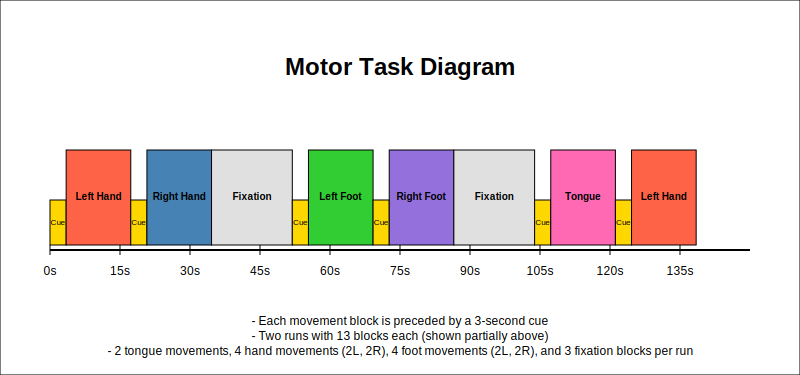

In [22]:
task = "motor"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [23]:
config = study_details[task]
numvols = 284
boldtr = .720
run = '2'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


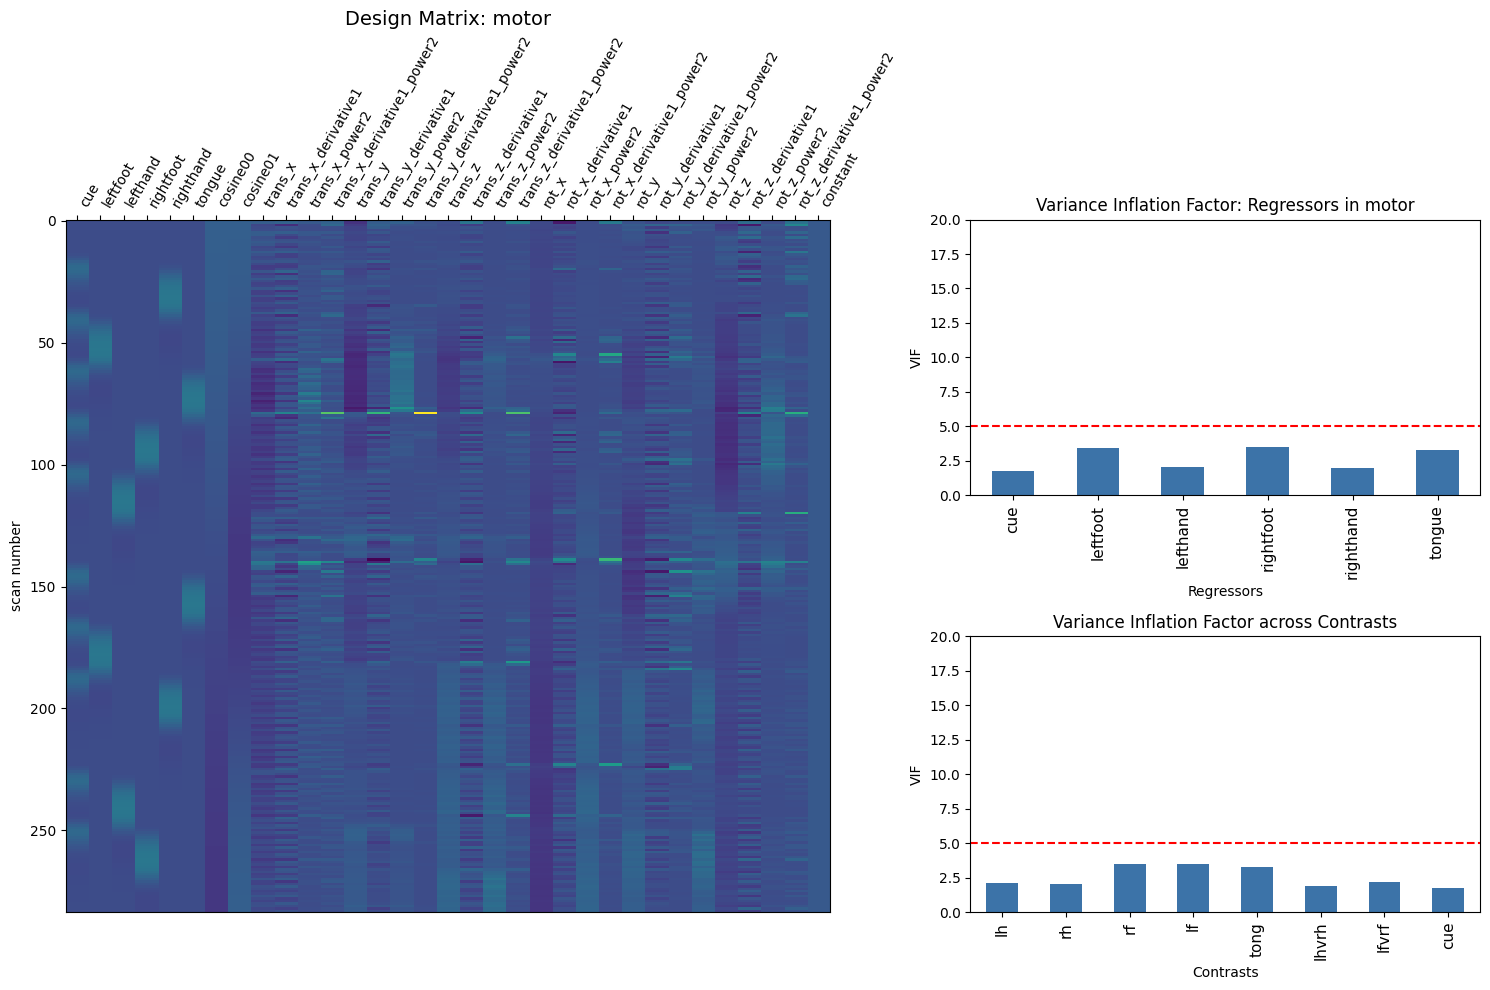

In [19]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_motor_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], incl_trialtypes=mod_config['trialtype_filter'],
                 modtype=mod_spec)
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

In [ ]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [7]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

    Working on contrast lh with weight lefthand
        Successfully saved contrast lh
    Working on contrast rh with weight righthand
        Successfully saved contrast rh
    Working on contrast rf with weight rightfoot
        Successfully saved contrast rf
    Working on contrast lf with weight leftfoot
        Successfully saved contrast lf
    Working on contrast tong with weight tongue
        Successfully saved contrast tong
    Working on contrast lhvrh with weight lefthand - righthand
        Successfully saved contrast lhvrh
    Working on contrast lfvrf with weight leftfoot - rightfoot
        Successfully saved contrast lfvrf
    Working on contrast cue with weight cue
        Successfully saved contrast cue


### Alt Model

This alternative model introduces a simple modification to the HCP modeling approach. In HCP, the Cue regressor serves as a single regressor for each block, irrespective of the condition type. However, as illustrated [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_motor), the duration of Cue is, on average, 2970 ms. Given this length, it is likely that motor-relevant preparatory signals contribute to the response. Therefore, instead of using a generic cue signal, the regressors should account for the cognitively relevant signal specific to each block. To achieve this, the model is expanded to include separate regressors for each movement condition, along with a cue regressor for each condition.

**Expected Difference in Activation between HCP and Alt Model**: Minor

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


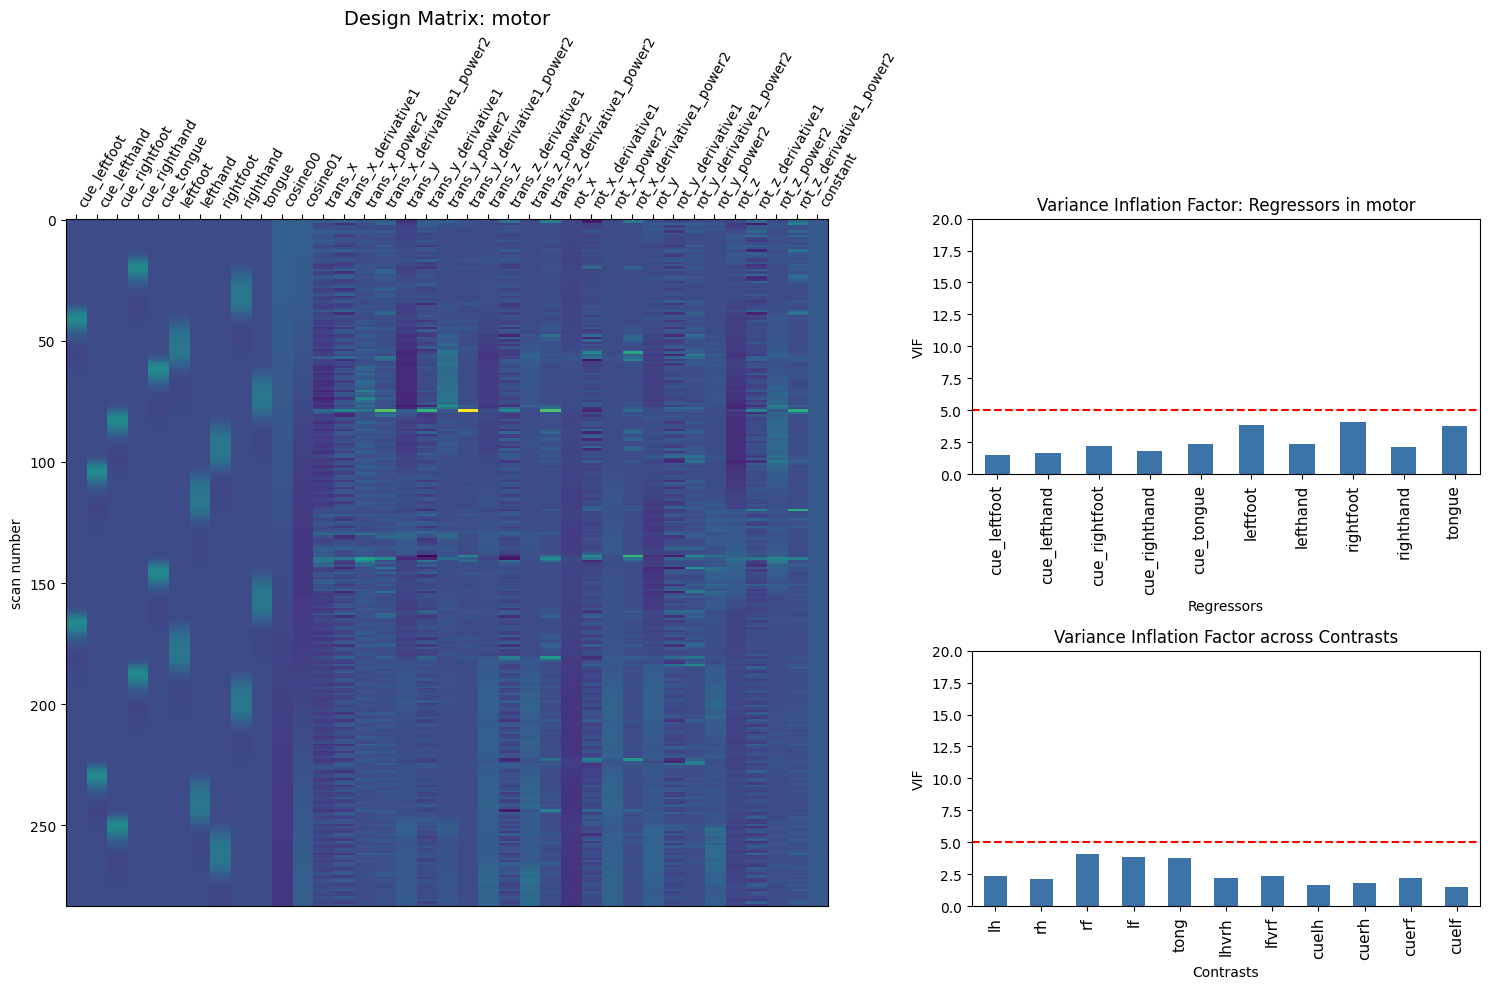

In [8]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_motor_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                               incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec)
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

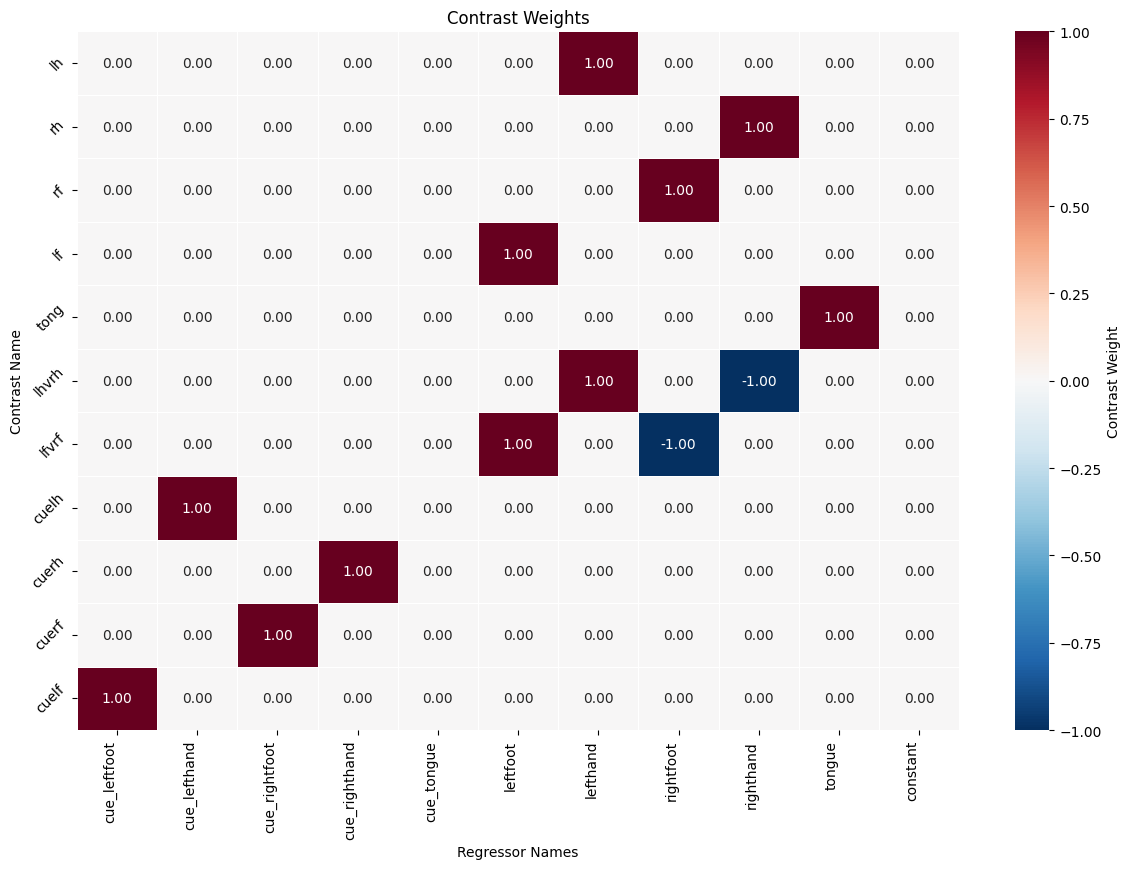

In [9]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

#### Run Fixed Effect 

In [ ]:
compute_fixedeff(subjid=subj_id, task=task, sess_lab=ses, condict=mod_config["contrasts"], 
                 inpfold=analysis_out, outfold=f'{analysis_out}/fixeff',prec_weight=True)

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


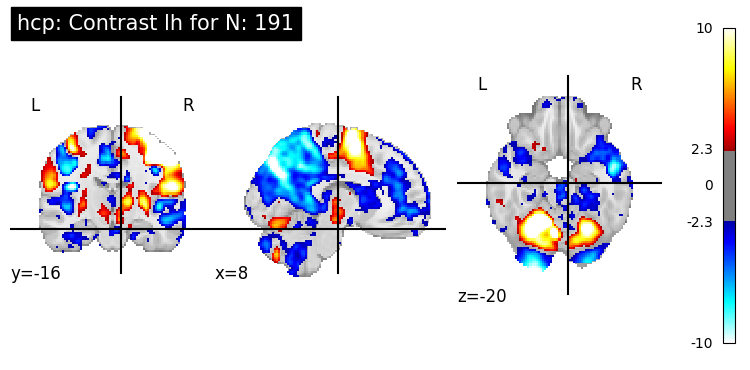

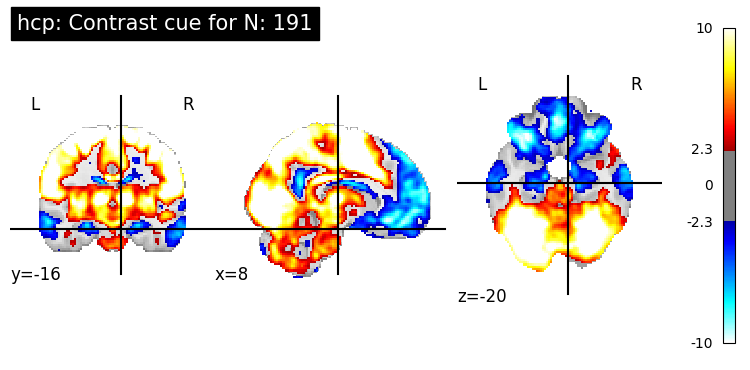

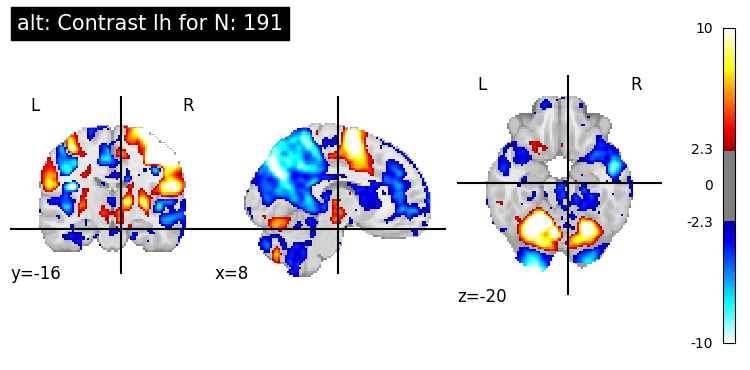

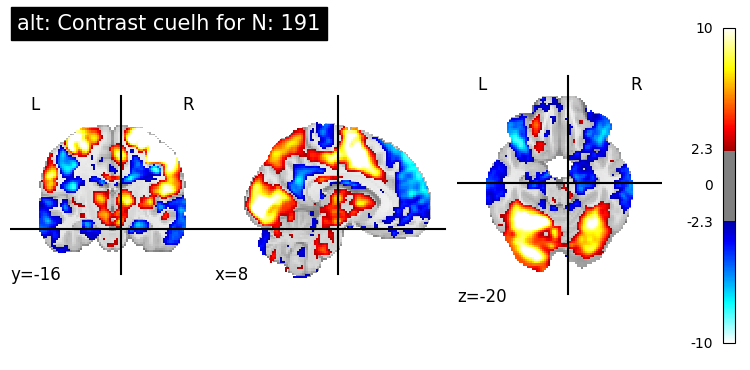

In [32]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=10, cut_coords=xyz_cord)

### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


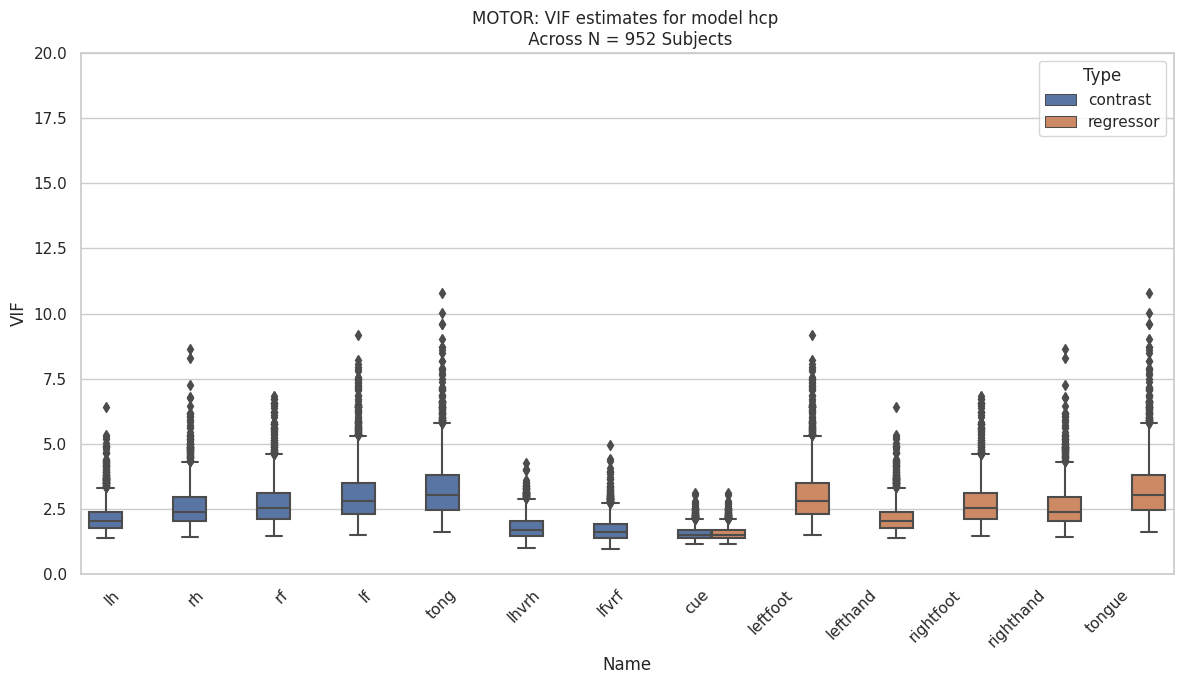

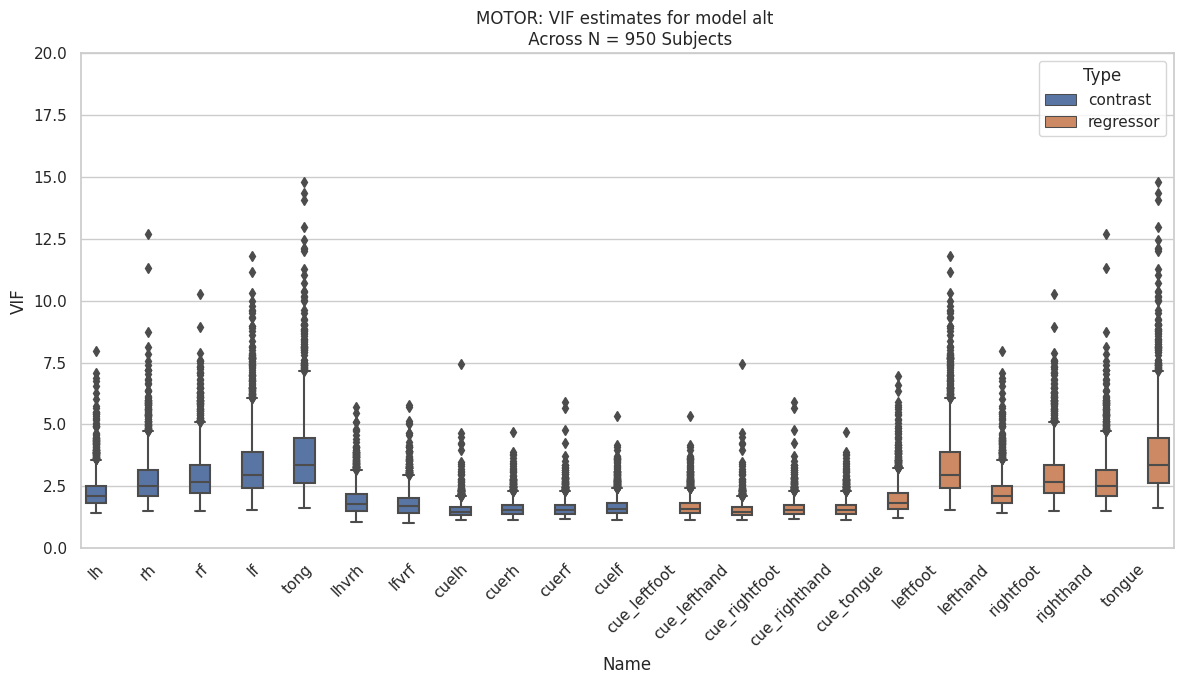

In [24]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [ ]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


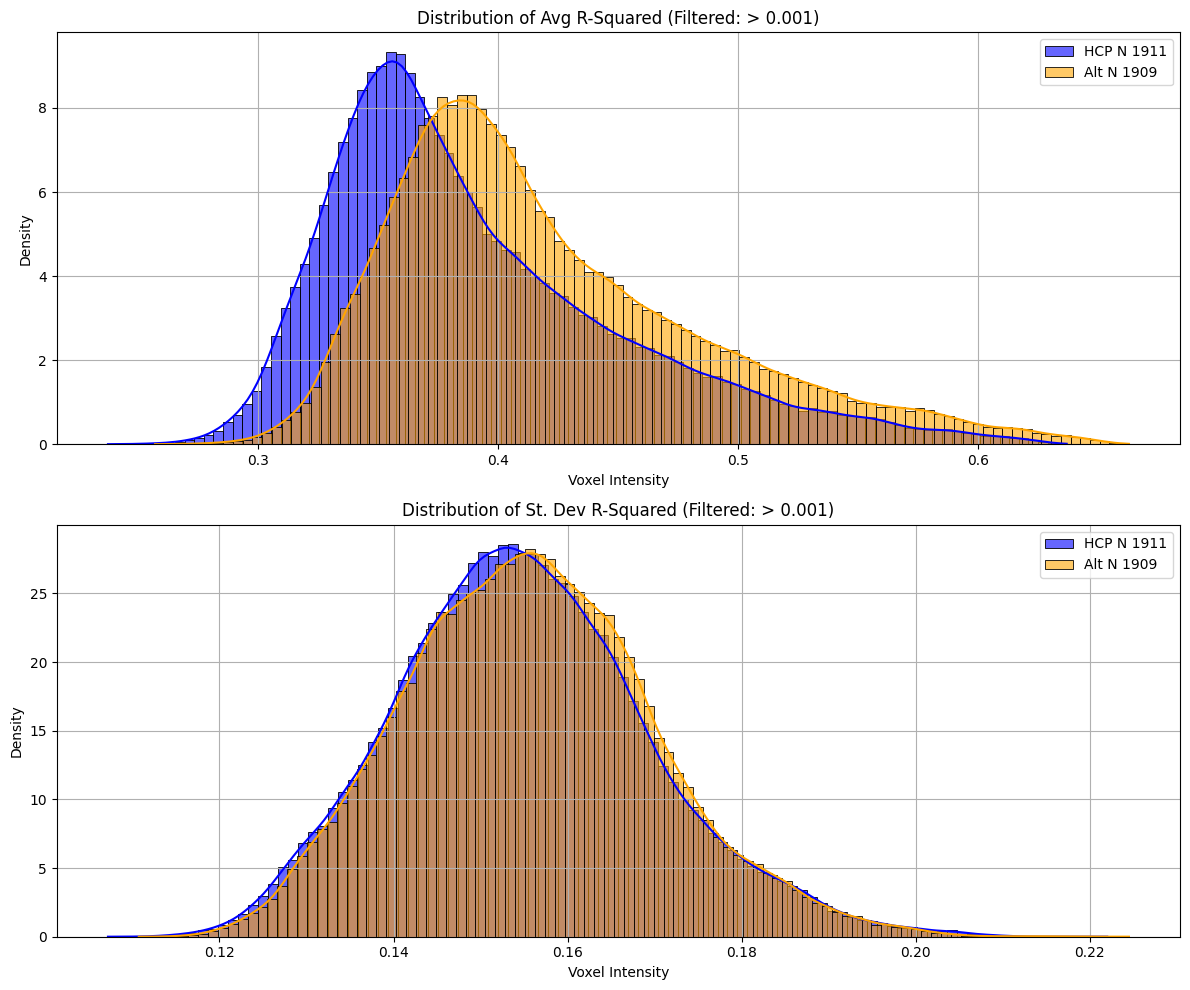

In [11]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Gambling

Barch et al. (2013, pg 181). "Two predictors were included in the model for **Incentive Processing** — mostly reward and mostly loss blocks, each covering the duration of 8 trials (28 s). For this task, as with all other tasks, linear contrasts of the parameter estimates were computed to compare each condition to baseline and to each other."

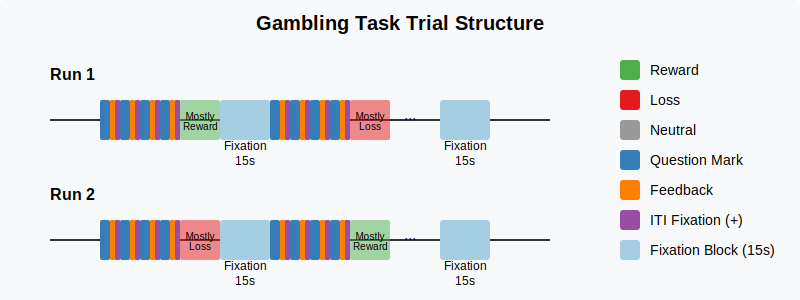

In [25]:
task = "gambling"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Events Design Matrix

In [11]:
config = study_details[task]
numvols = 253
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['quest_mark', 'full_gamble', 'filler', 'feedback', 'isi_1sec',
       'fixation', 'tooslow'], dtype=object)

### HCP Model

Dropping 1 rows with None/NaN in 'onsets' column.
    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


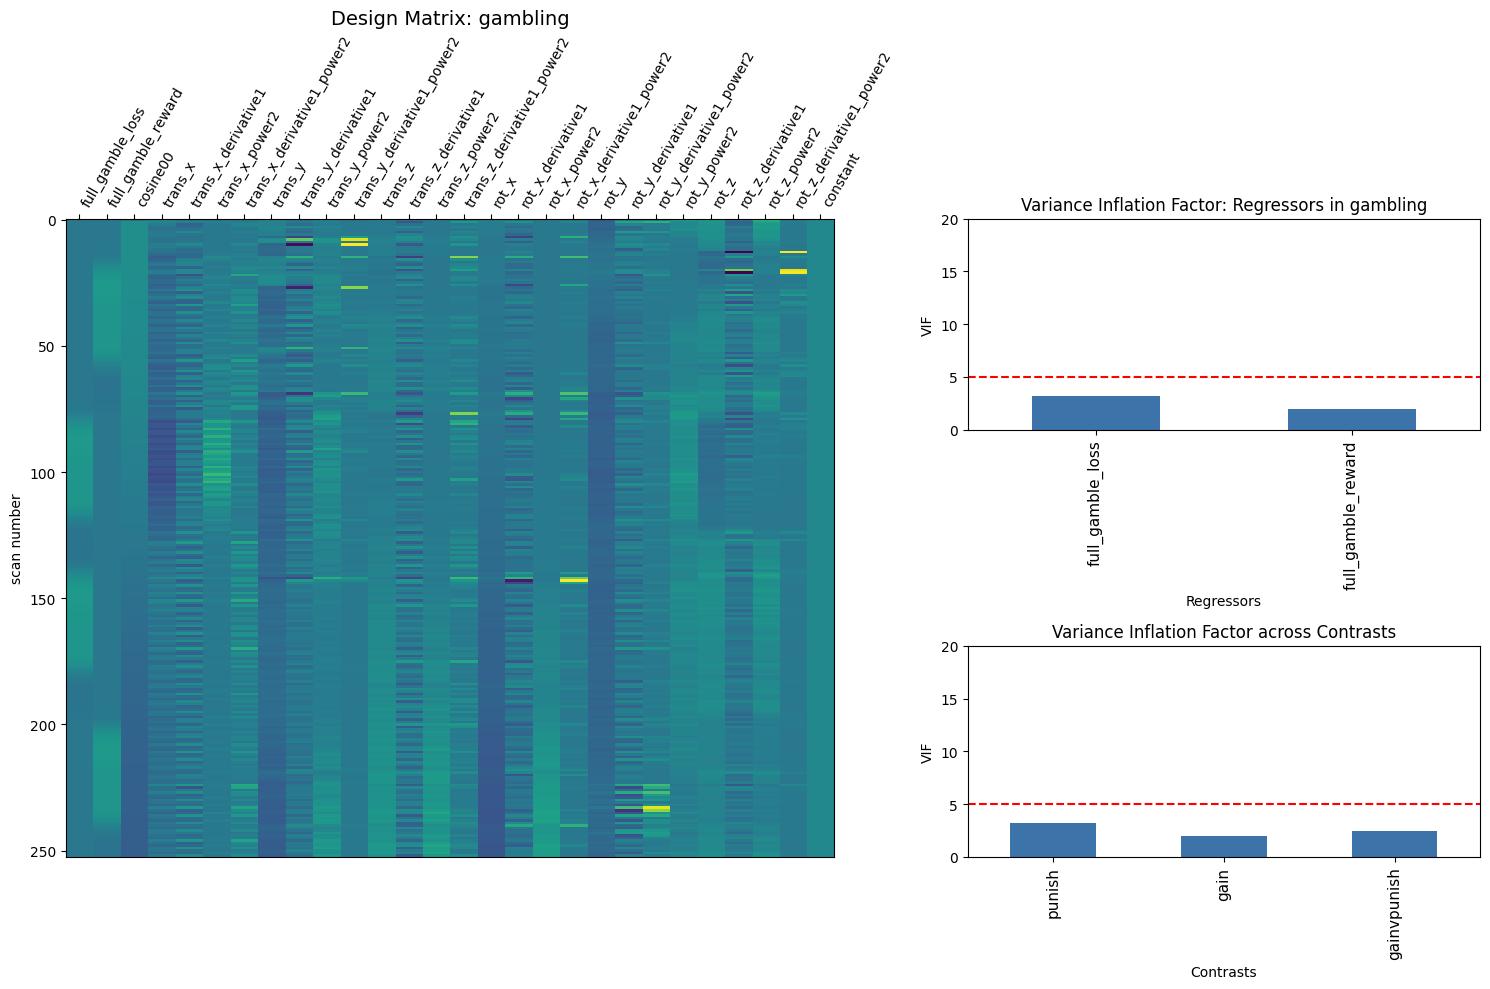

In [12]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_gamble_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

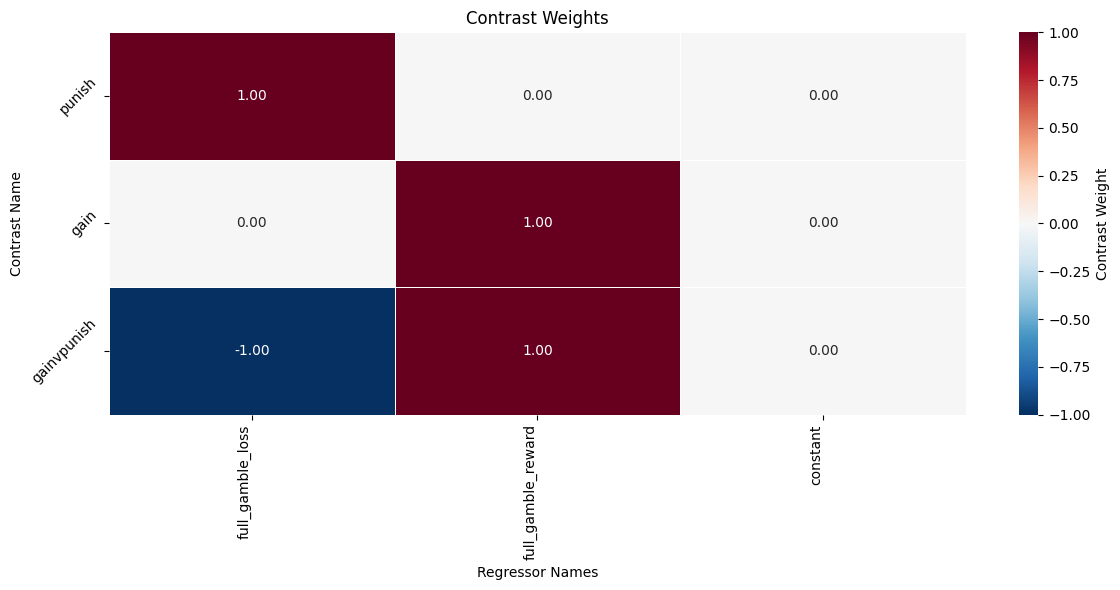

In [13]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
fmri_glm = FirstLevelModel(subject_label=subj_id, mask_img=brain_mni_mask,
                            t_r=float(config['boldtr']), smoothing_fwhm=fwhm,
                            standardize=False, noise_model=ar_noisemod, drift_model=detrend, high_pass=highpass)
run_fmri_glm = fmri_glm.fit(bold_path, design_matrices=design_matrix)

compute_save_contrasts(glm_res=run_fmri_glm, sess_lab=ses, condict=mod_config["contrasts"], outfold=analysis_out, 
                       subjid=subj_id, task=task, run=run)

### Alt Model

In the HCP model, entire blocks are categorized as either "mostly reward" or "mostly punishment." This approach compresses all within-trial variability—such as differences in selecting above or below and variations in responses to feedback—into a single parameter. Consequently, the resulting construct is noisy, difficult to interpret, and highly variable. For example, the difference between "mostly reward" and "mostly punishment" conditions can be as little as one or two trials. As a result, reward- and punishment-related effects are attenuated.

For a visualization of the timing distribution, see the figures [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_gambling).

An alternative approach is to model the decision phase (question mark) and the outcome phase (feedback) separately. This has two key advantages:

1. It distinguishes the cognitive processes involved in decision-making from those involved in outcome evaluation.
2. It allows for within-trial estimates of BOLD fluctuations related to decision-making (higher vs. lower choices) and feedback type (Neutral, Gain, or Loss).

However, this approach has limitations. First, the events are rapid—on average, participants make a decision within 550 ms. Second, the decision and feedback phases are temporally close, sometimes separated by only an 850 ms filler and variable presentation. Specifically, if participants fail to respond or exceed the threshold (~1500ms), no filler is presented (i.e., a fixation cross screen). Response times (RTs) also differ across conditions, particularly in reward trials within mostly punishment blocks, where RTs are, on average, nearly 200 ms slower. The feedback duration and interstimulus intervals remain relatively constant at 990–1020 ms and 1000–1070 ms, respectively.

In modeling these independent components, accounting for RT in trial-by-trial models might seem important. However, the duration of the decision phase (question mark) is contingent on RT. This introduces collinearity into the design, meaning that including an RT regressor would result in an exceedingly high variance inflation factor (VIF), making estimation unreliable. In a way, the question mark regressor would account for the trial-by-trial RT variability.


**Expected Difference in Activation between HCP and Alt Model**: Substantial

Dropping 1 rows with None/NaN in 'onsets' column.
    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


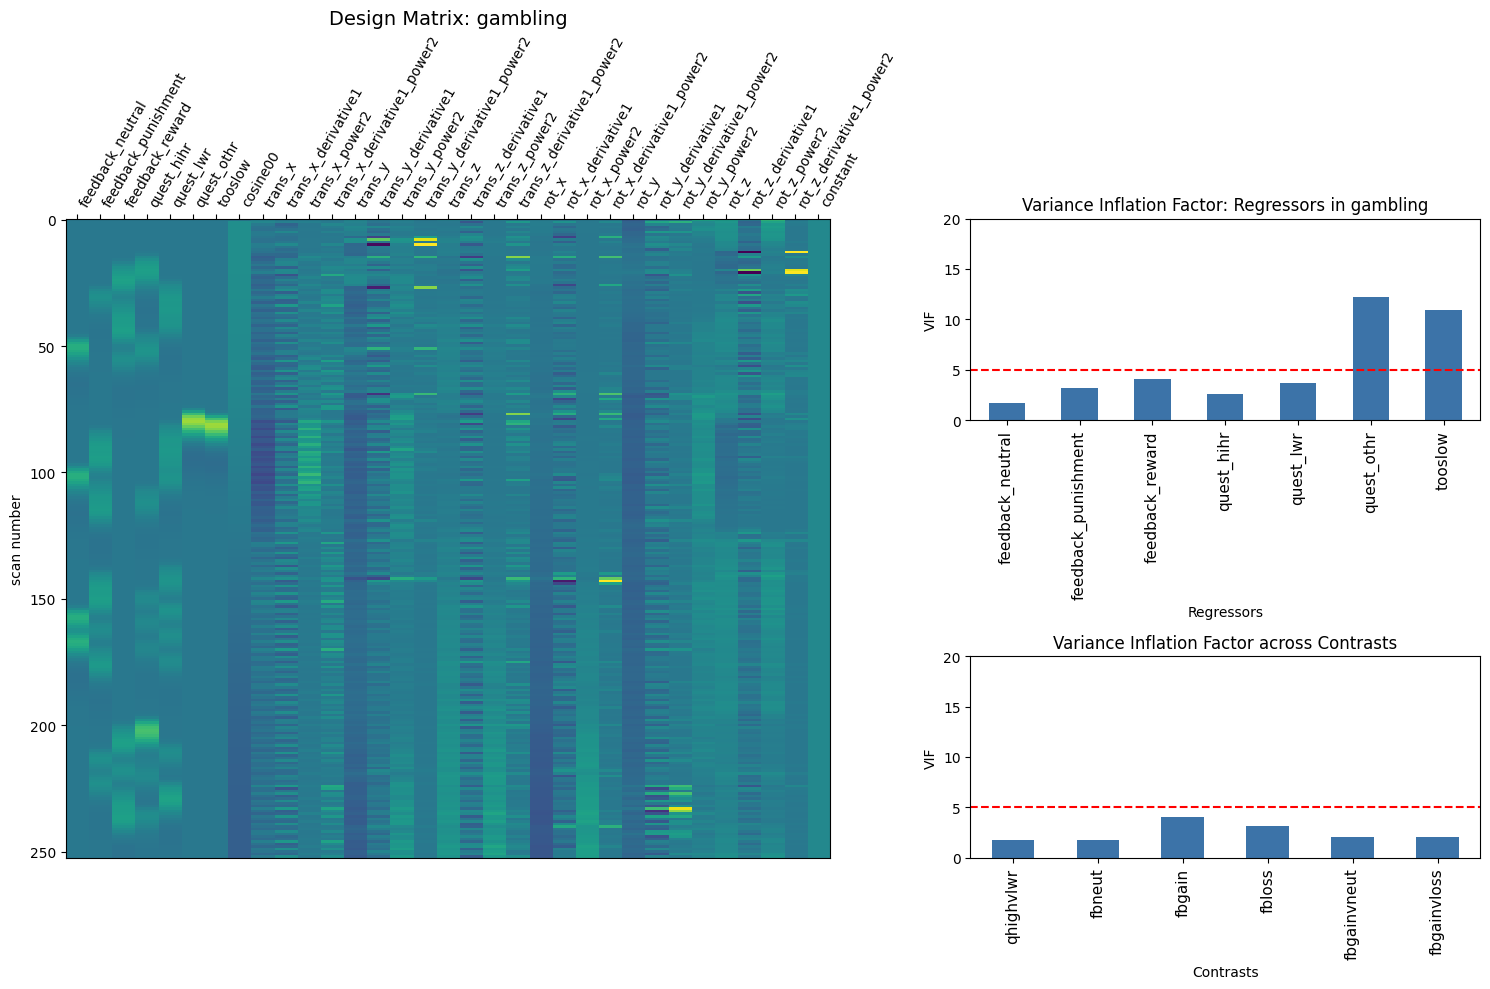

In [14]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_gamble_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

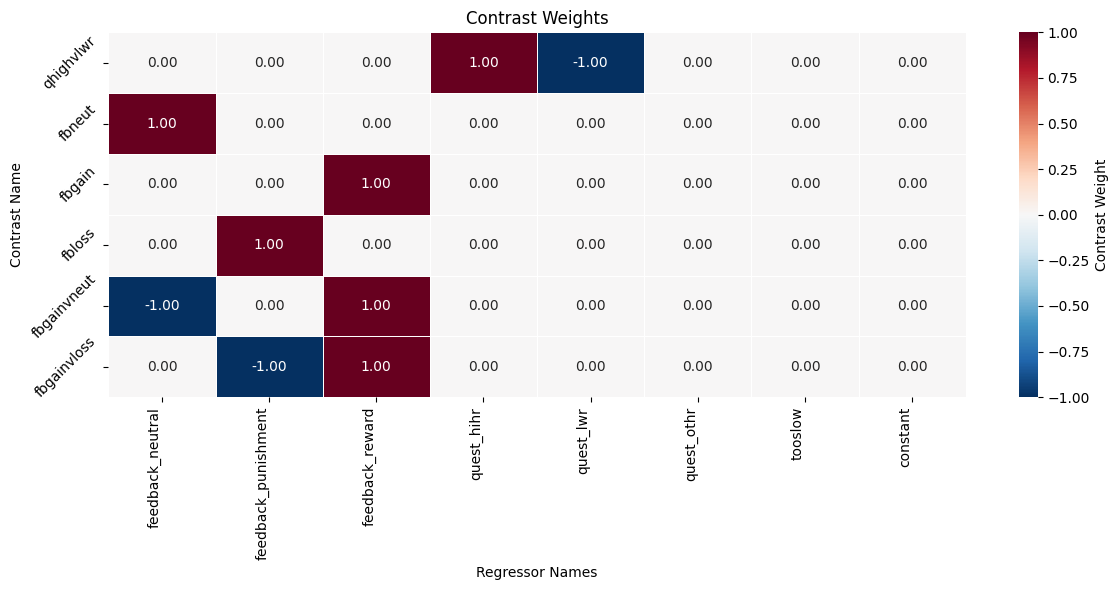

In [15]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group 

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


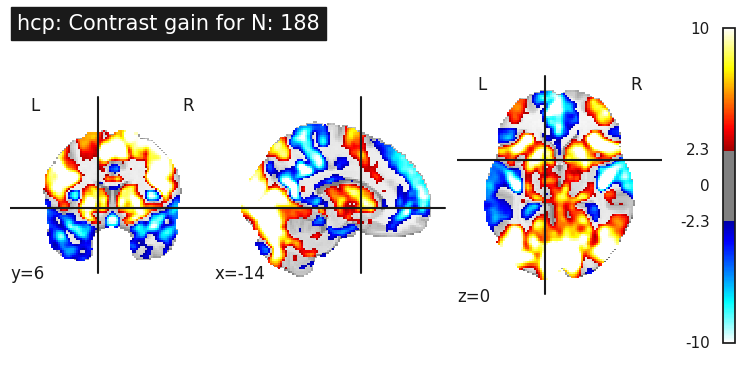

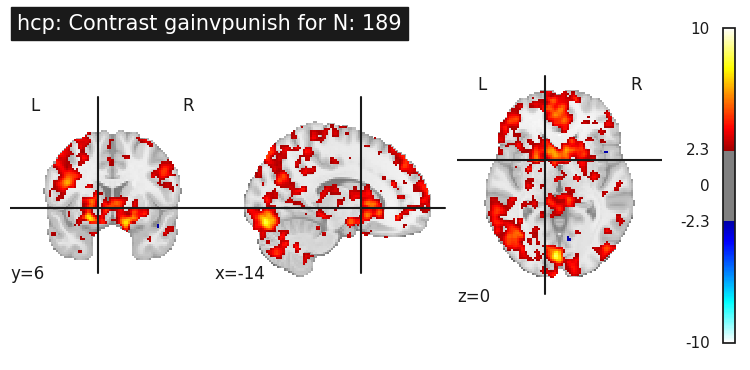

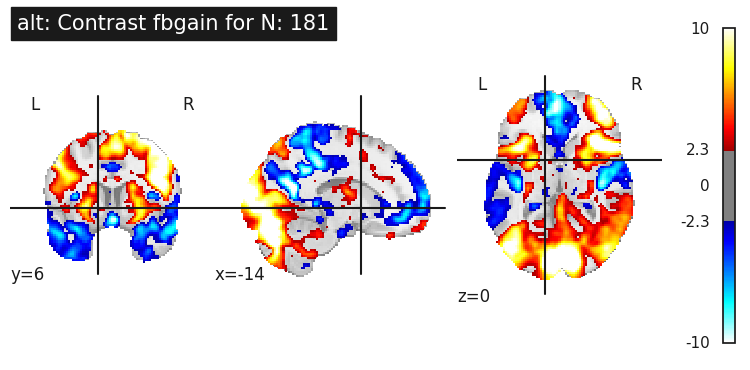

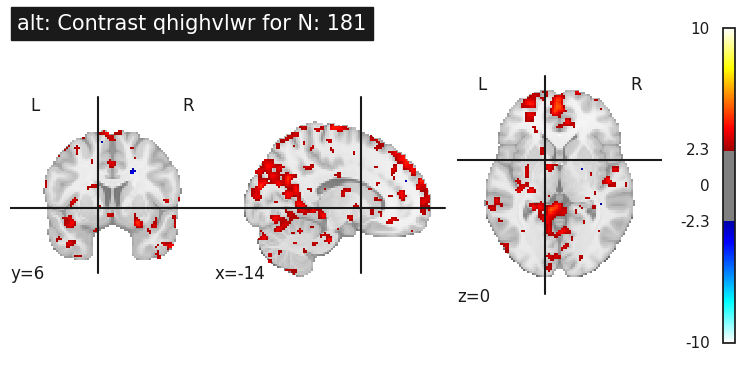

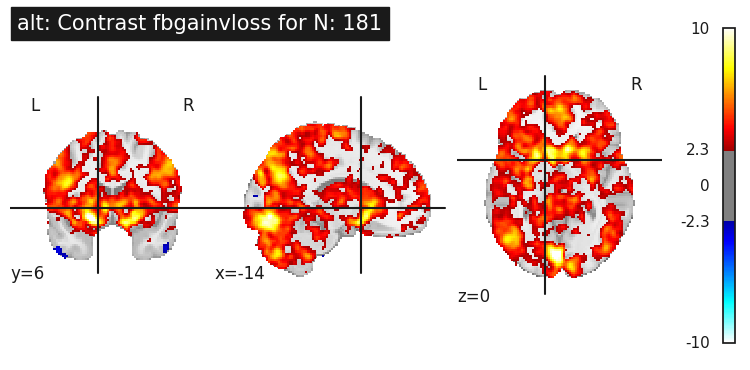

In [40]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=10, cut_coords=xyz_cord)


### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


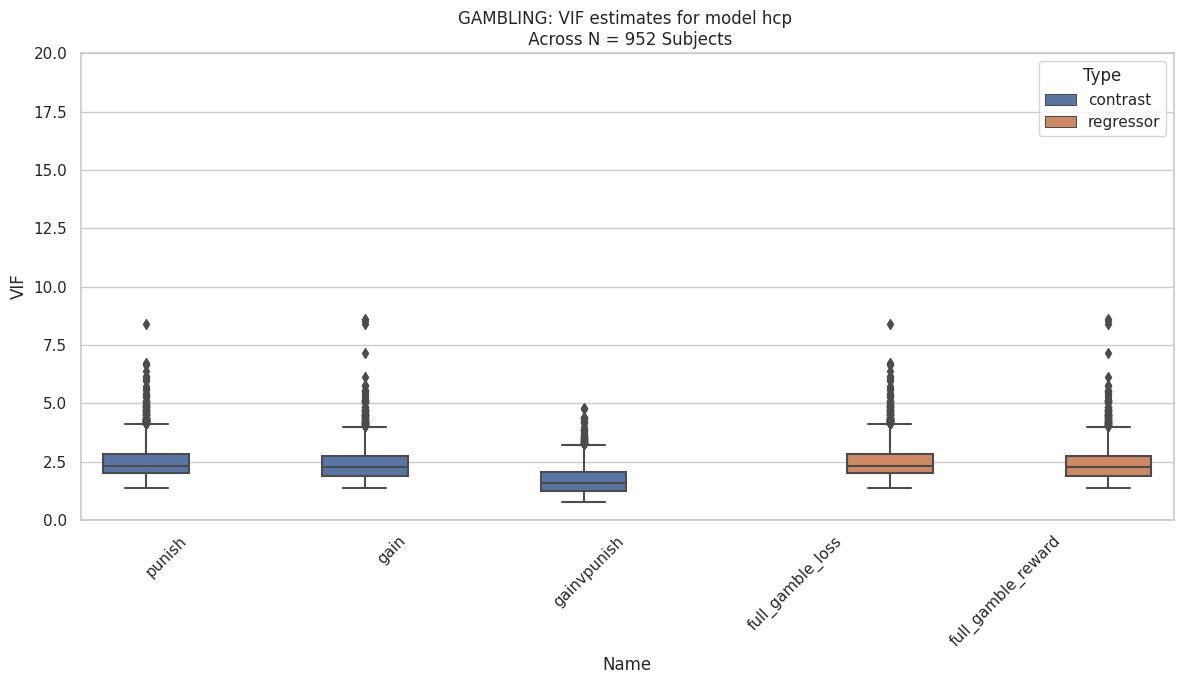

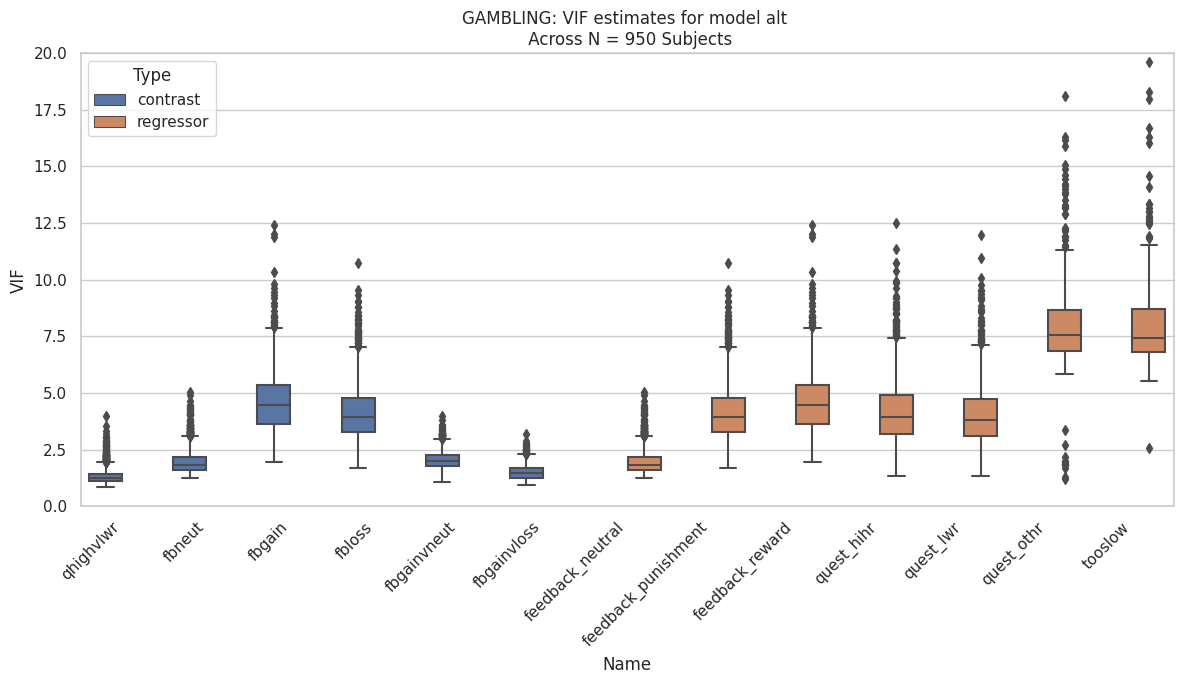

In [26]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [ ]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

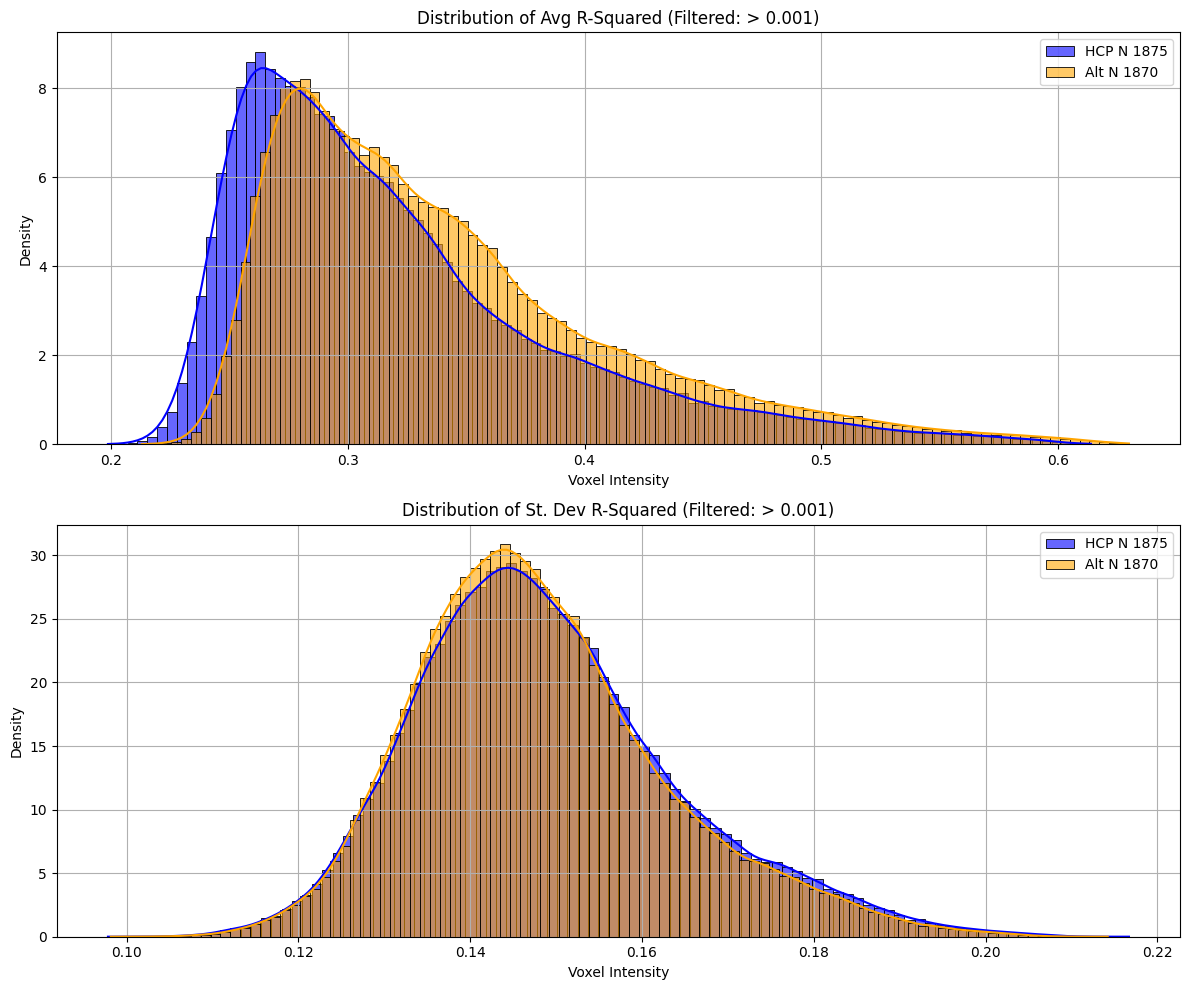

In [8]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Social 

Barch et al. (2013, pg 181). "Two predictors were included in the Social Cognition model — Social and Random motion. Predictors were based on the category of the video clip rather than the rating of the individual. Each predictor covered the duration of a single video clip (20 s)."

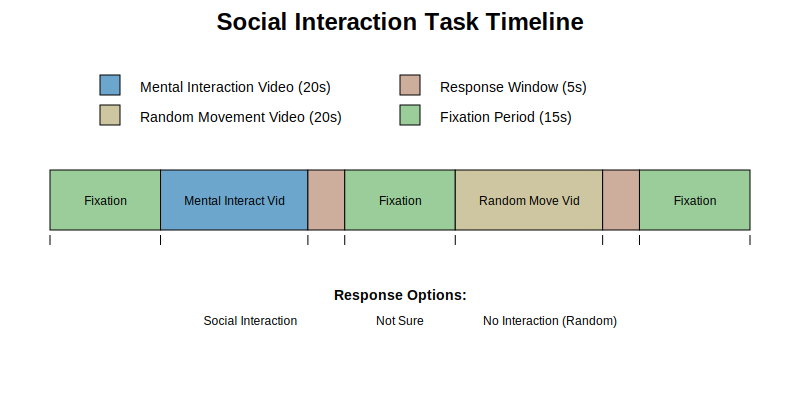

In [27]:
task = "social"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix 

In [17]:
config = study_details[task]
numvols = 274
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['movie', 'social_full', 'response', 'fixation'], dtype=object)

The HCP only modeled the Movie durations for Social and Random categories. So no response windows are modeled and considered in their subject-level models. Based on the timing distributions, which you can find [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_social), there are minor differences in response times (RT) between the random and mental interaction conditions. With 'not sure', often having a slowest response times. However, it may be of interest to account for the response time window and the RT times.

**Expected Difference in Activation between HCP and Alt Model**: Movie-relevant, Minimal; Response-relevant, high.

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


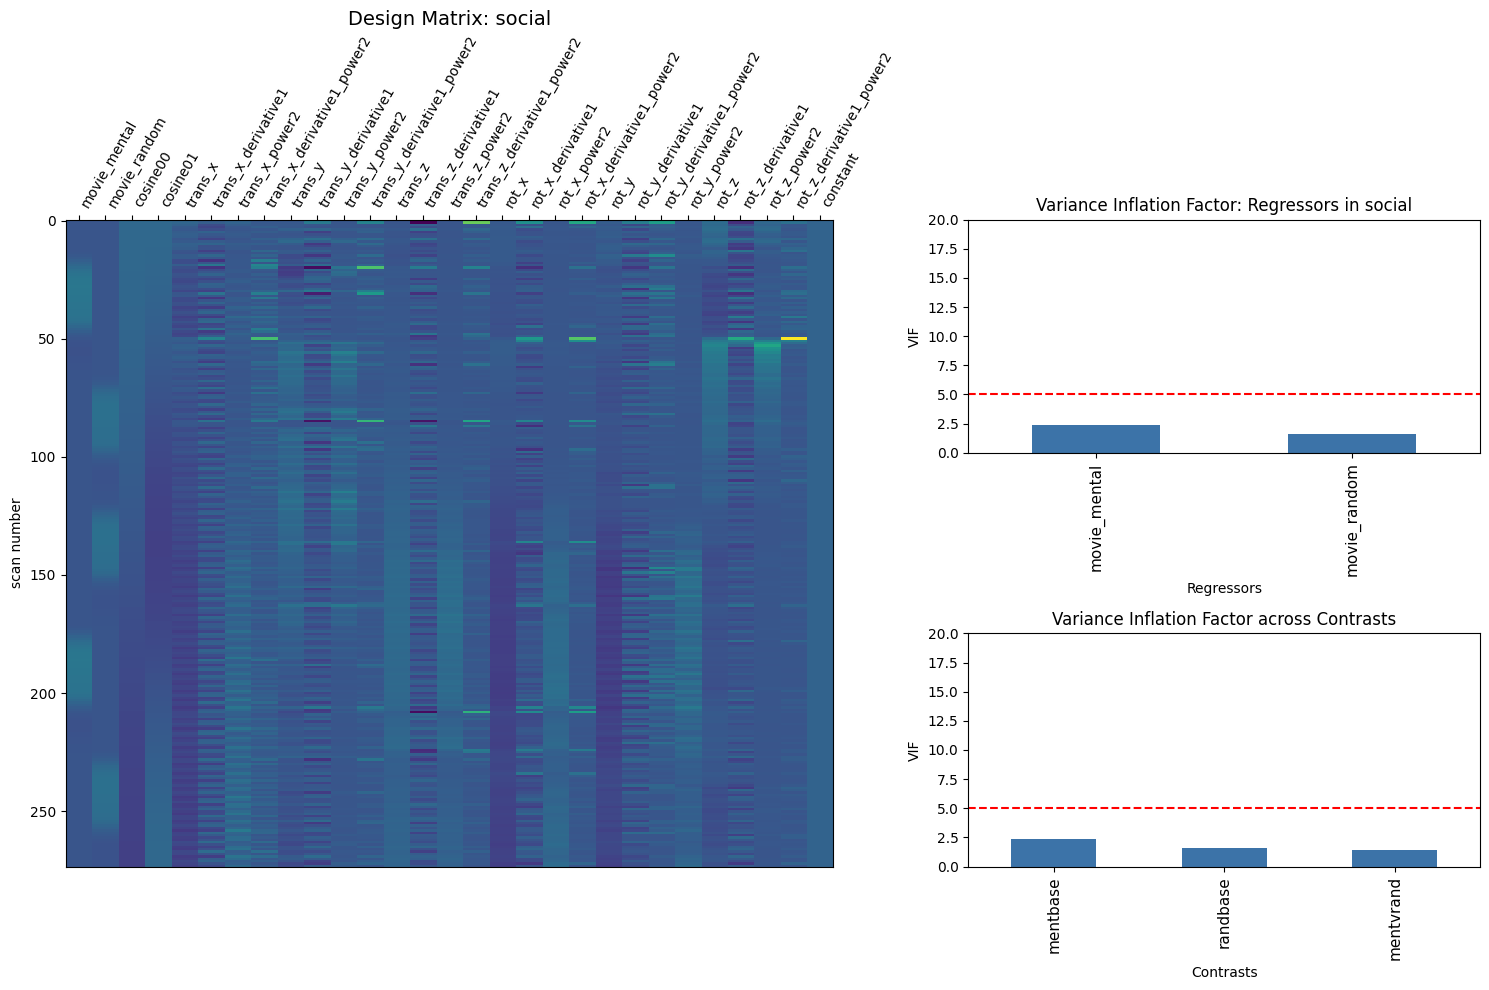

In [18]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_social_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

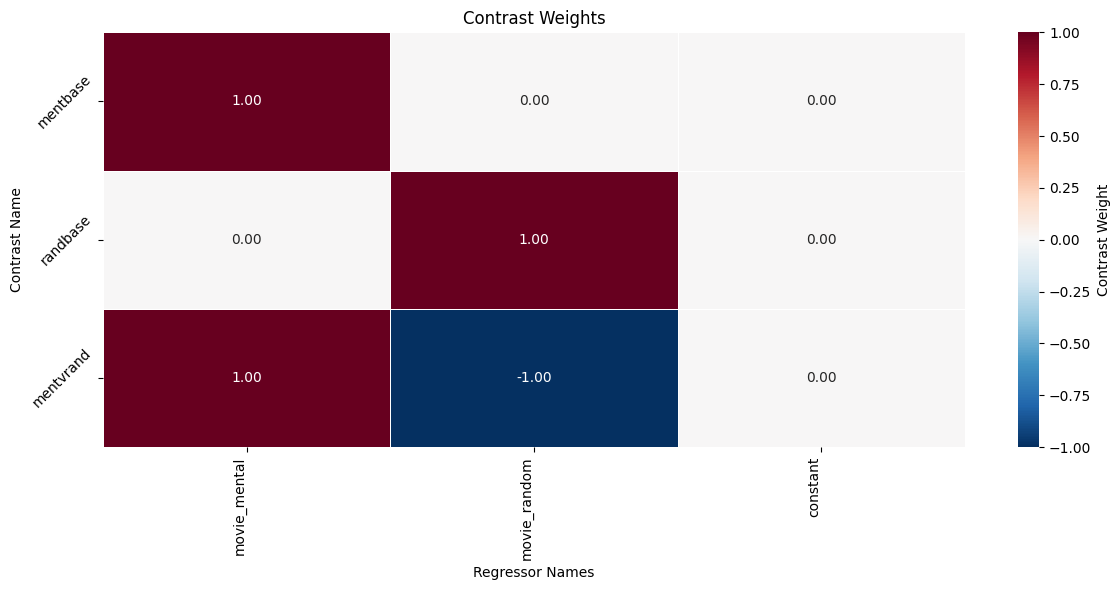

In [19]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

### Alt Model

/panfs/jay/groups/2/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/.venv/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
rt.
  warnings.warn(


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


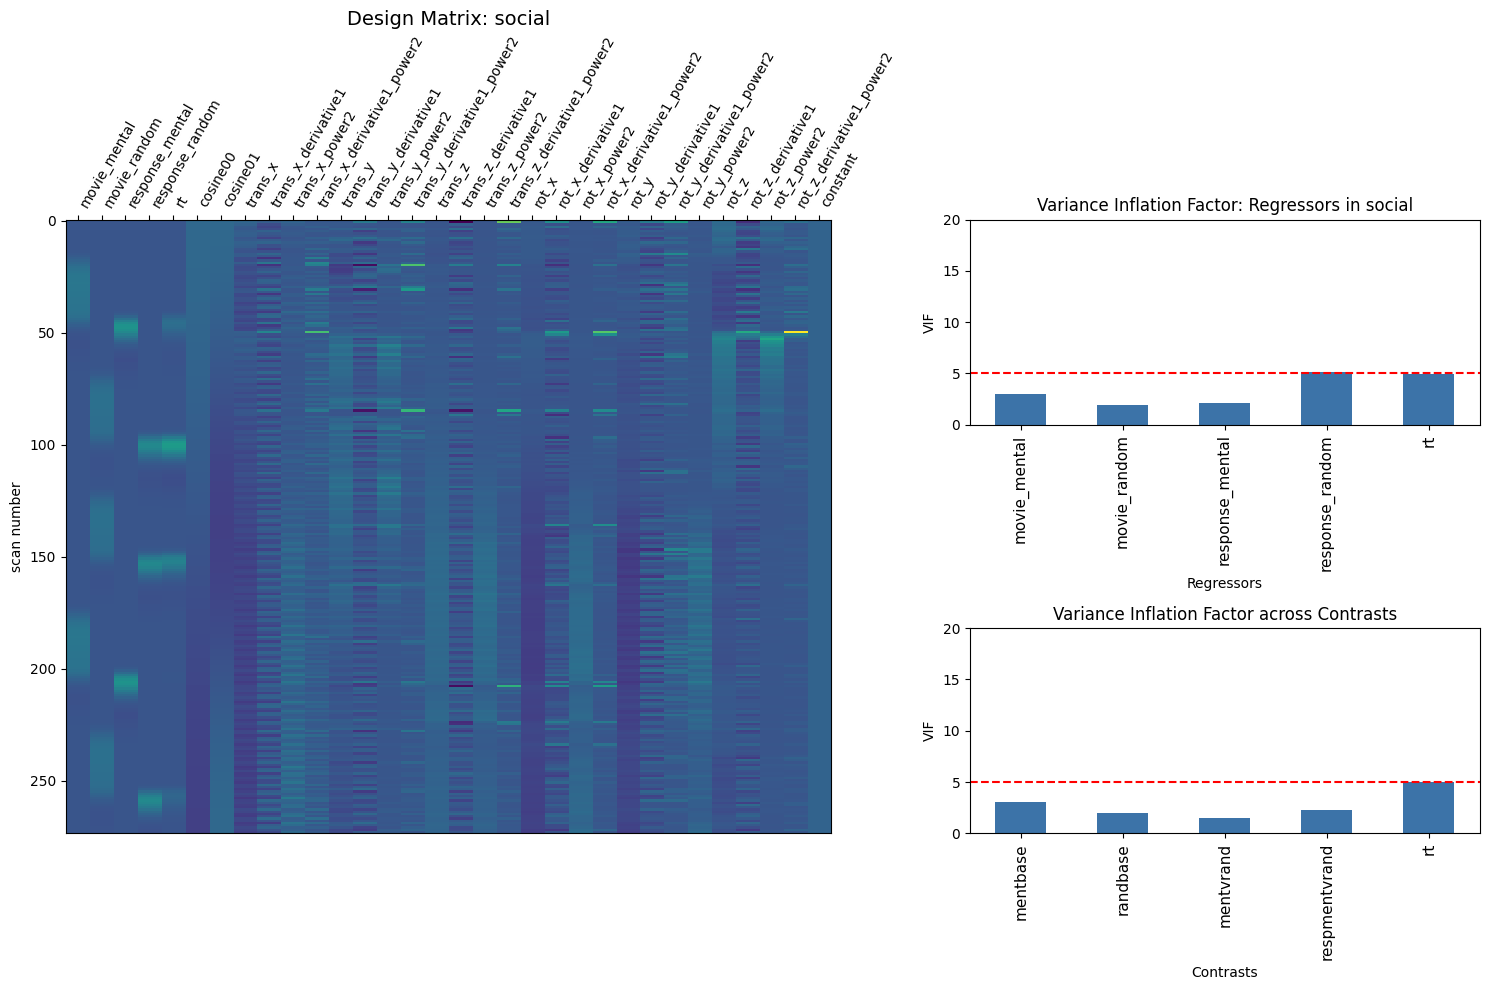

In [20]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_social_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

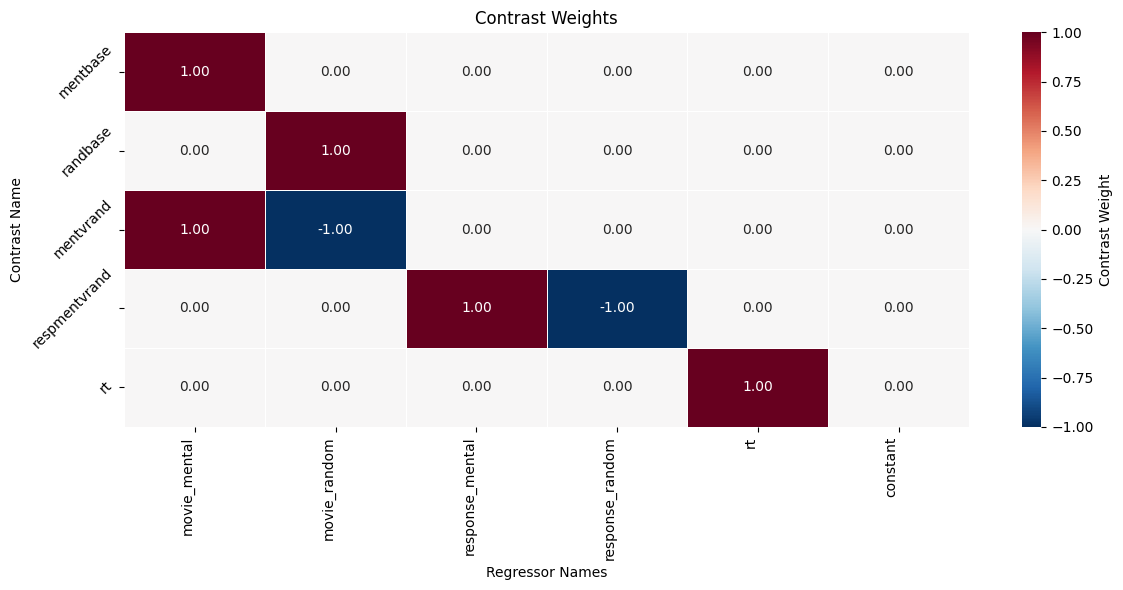

In [21]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


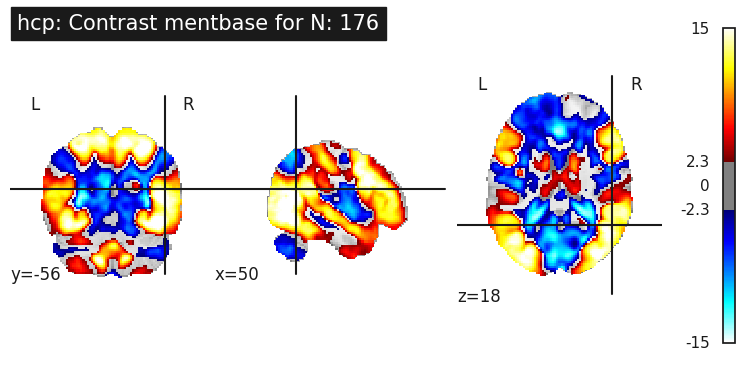

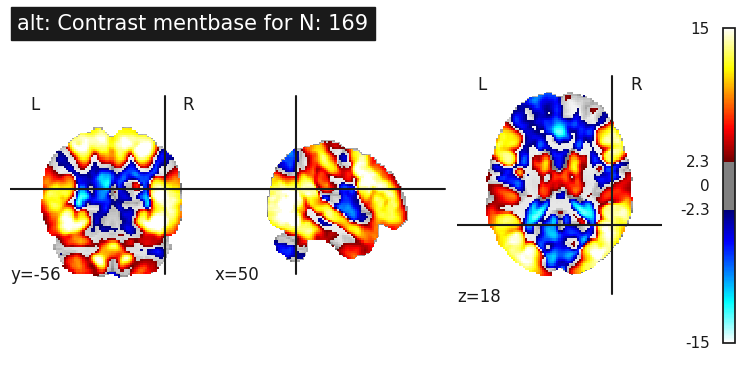

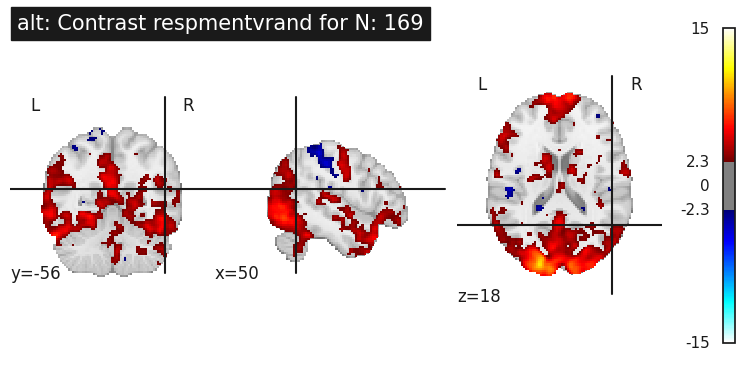

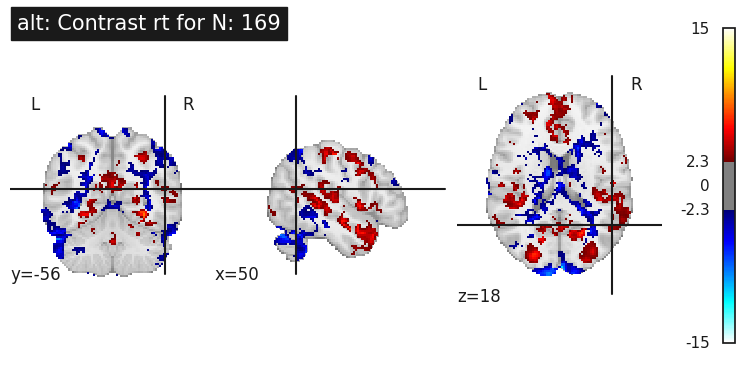

In [51]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-zstat.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-zstat.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=15, cut_coords=xyz_cord)


### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


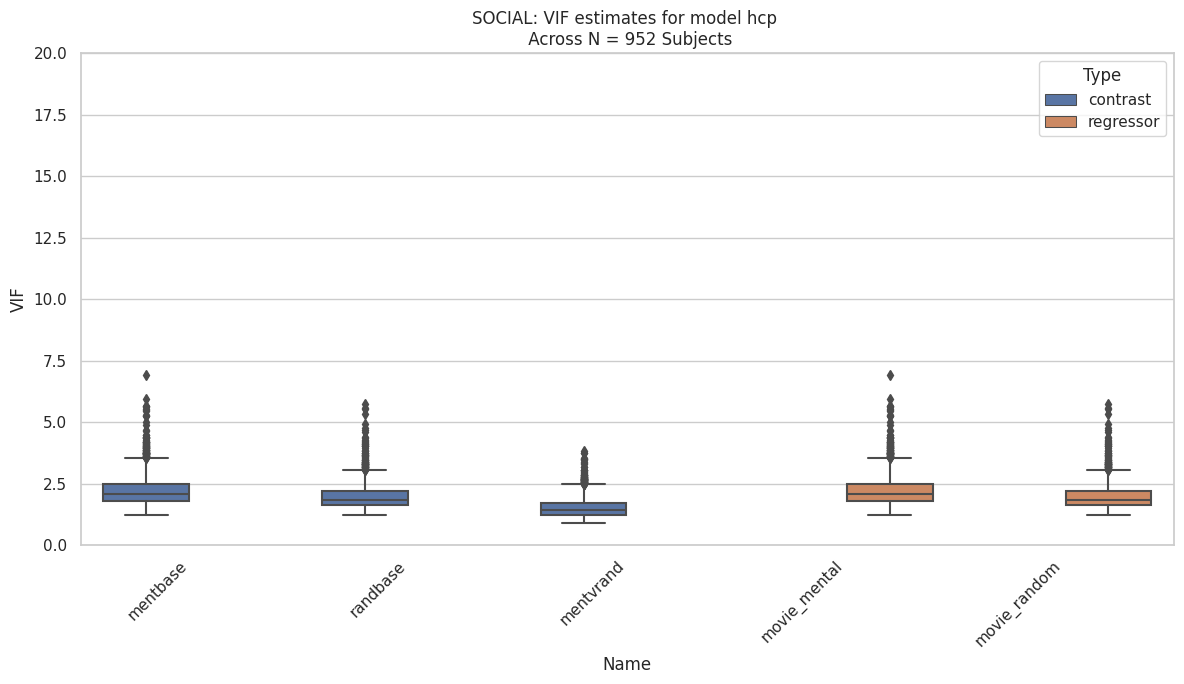

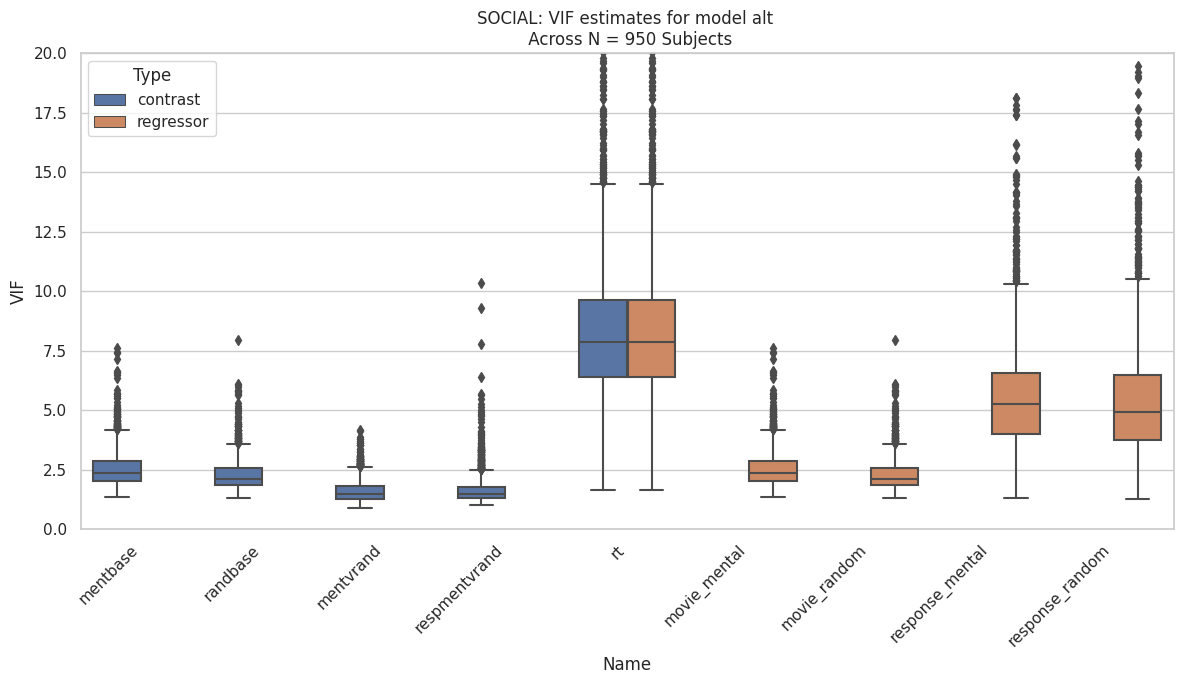

In [28]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [13]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

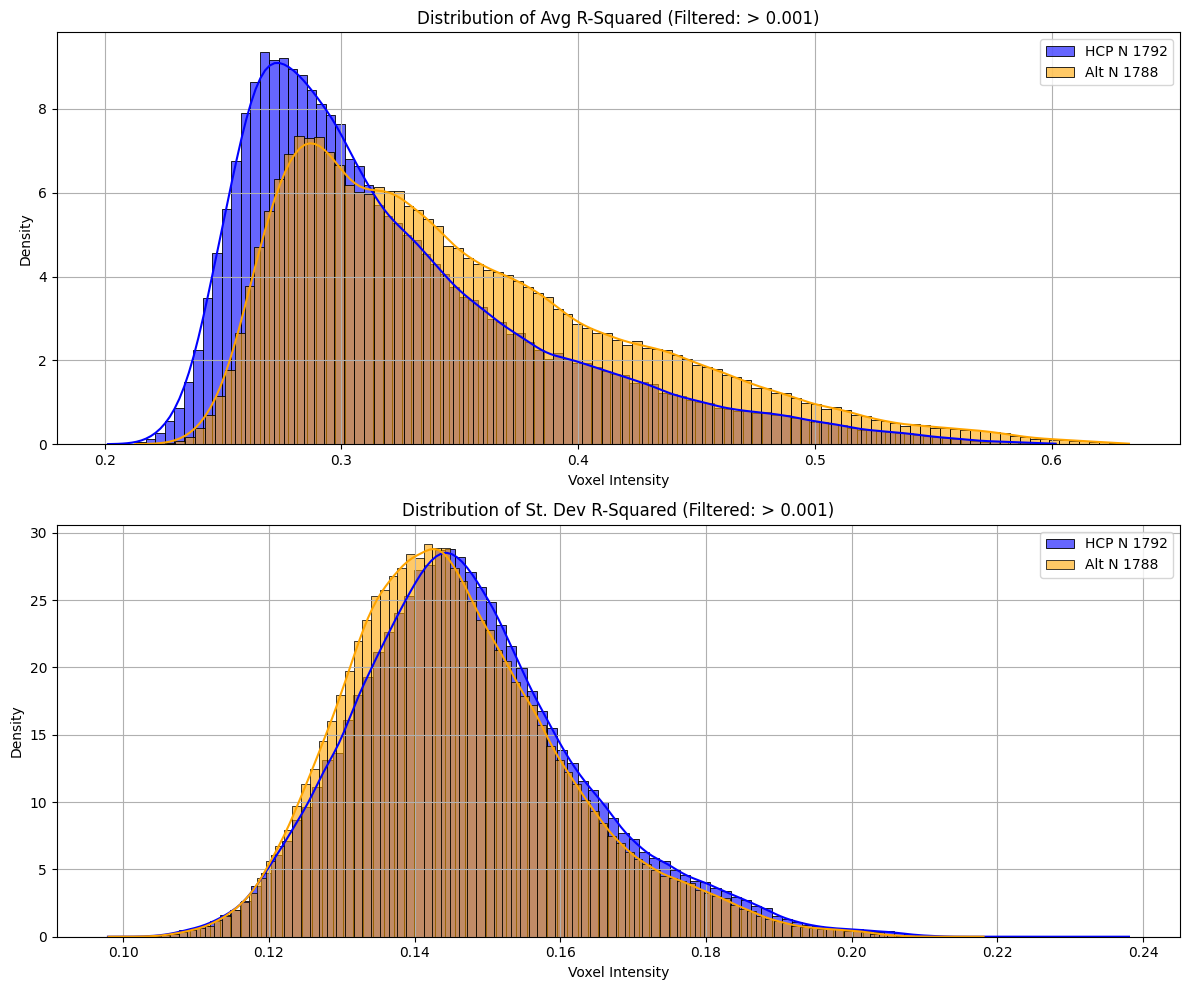

In [14]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Language

Barch et al. (2013, pg 181). "Two predictors were included in the Language Processing model — Math and Story. The Story predictor covered the variable duration of a short story, question, and response period (~30 s). The Math predictor covered the duration of a set of math questions designed to roughly match the duration of the story blocks."

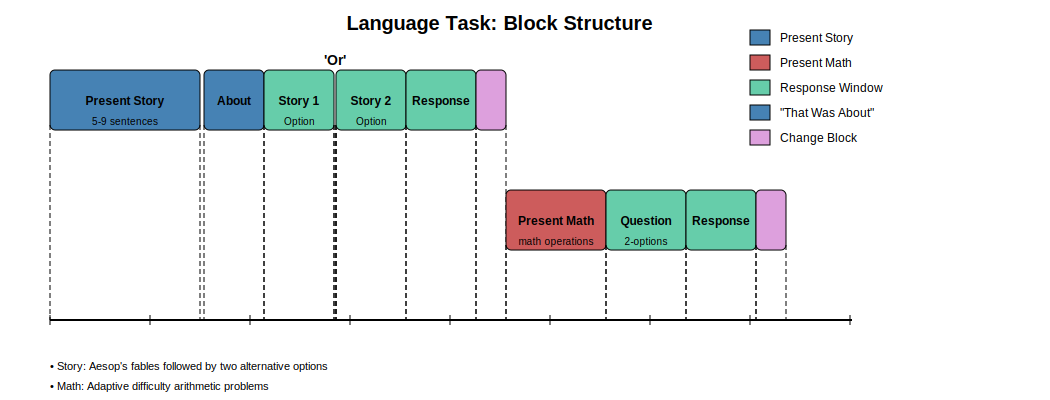

In [3]:
task = "language"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [16]:
config = study_details[task]
numvols = 316
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['present_story', 'story_wait', 'present_storyquest',
       'story_to_question', 'full_story', 'question_story', 'story_opt1',
       'story_opt2', 'story_answerfull', 'story_answer', 'change',
       'present_math', 'full_math', 'math_to_question', 'question_math',
       'math_answer', 'math_answerfull'], dtype=object)

The HCP models the entirety of the Story and Math blocks, including the presentation, question, and response/answer window. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_language), the answer duration windows are relatively similar across math and story blocks (~2900ms). However, the total durations of the full story and math blocks (including presentation, question, and answer) differ significantly: 24,000ms for story and 12,300ms for math. Additionally, the average response time varies between story (3200ms) and math (3900ms), suggesting distinct cognitive processes unfolding across these blocks. These differences should be considered when modeling. The alternative model attempts to account for these task-level differences. Notably, a decision to include/exclude RTs as an individual regressor would result in higher variance inflation factors for the story & and math answer regressors. If the VIFs are exceddingly high, using in contrasts is not recommended.

**Expected Difference in Activation between HCP and Alt Model**: Moderate

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


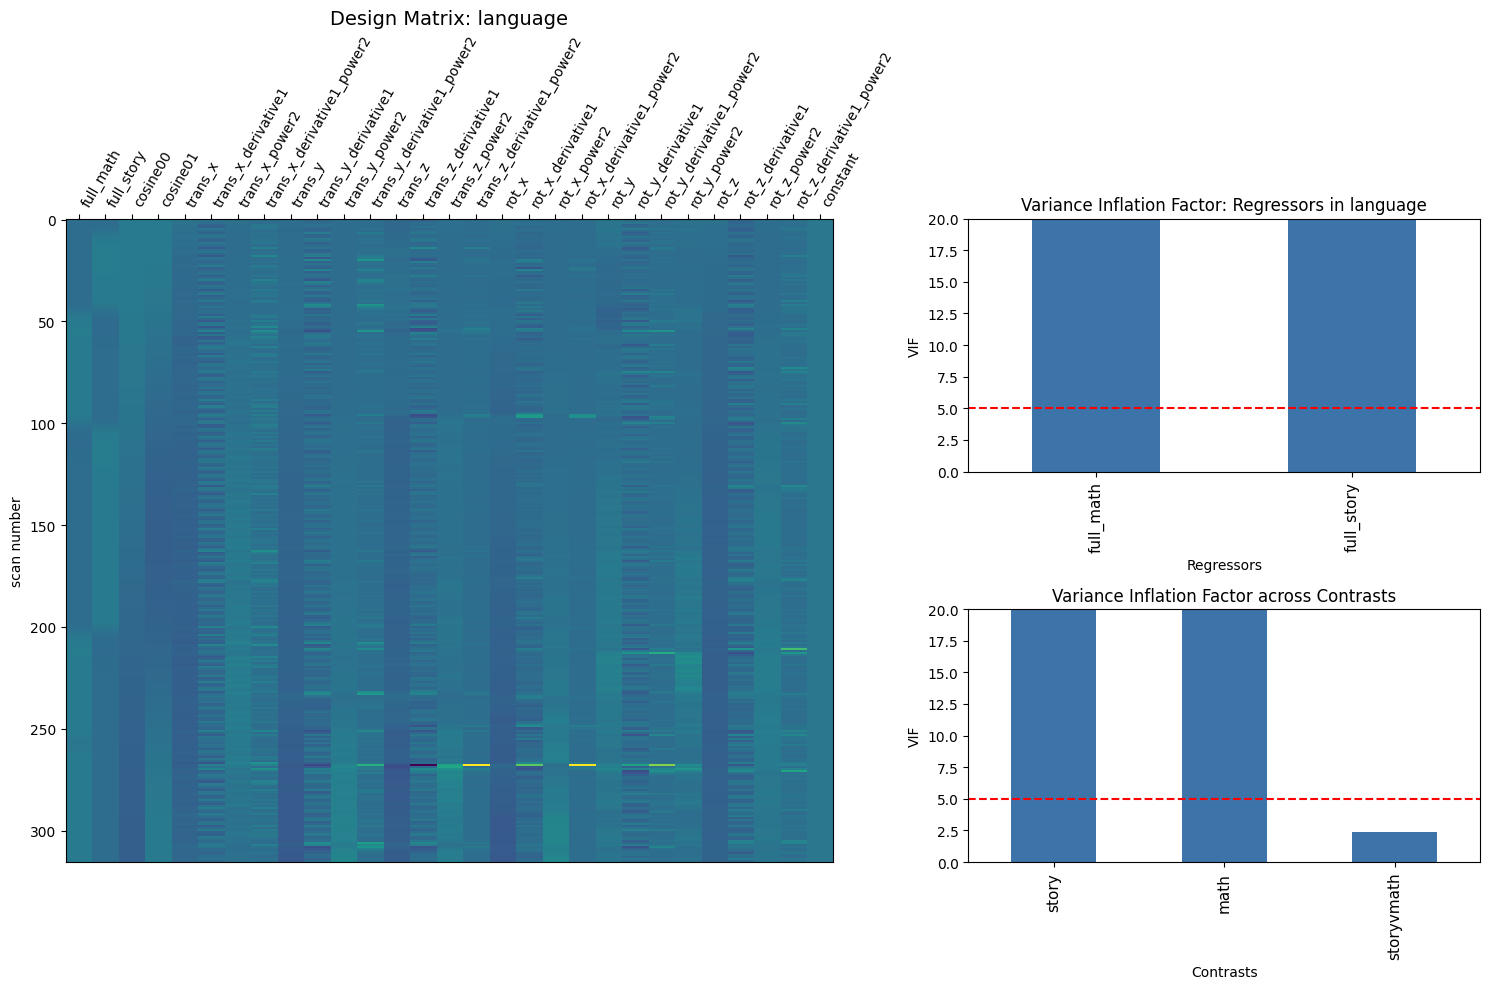

In [24]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_language_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

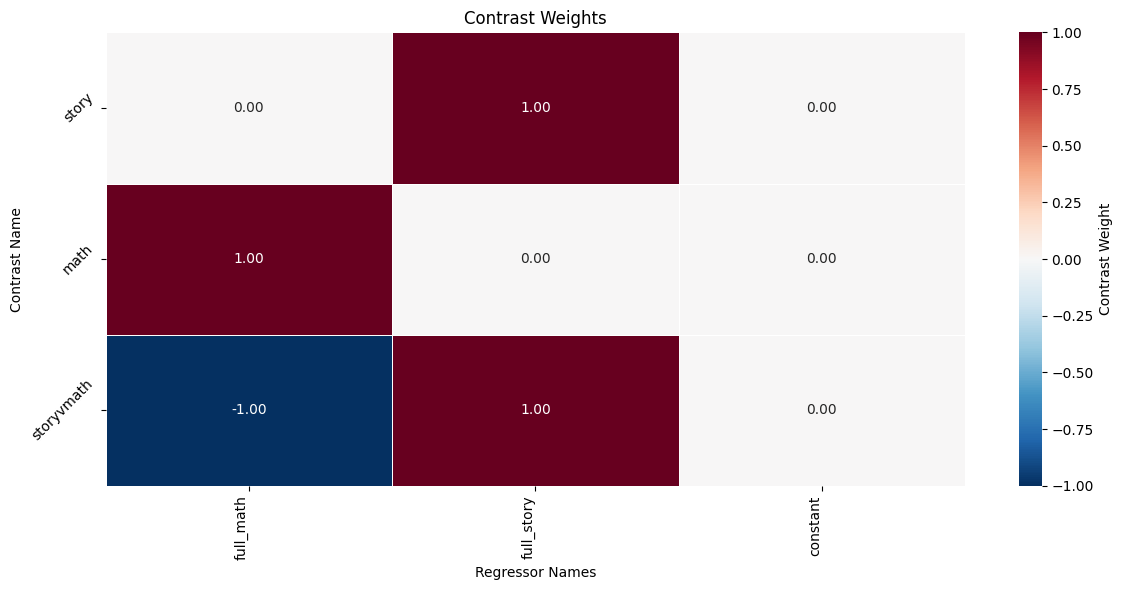

In [25]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

### Alt Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


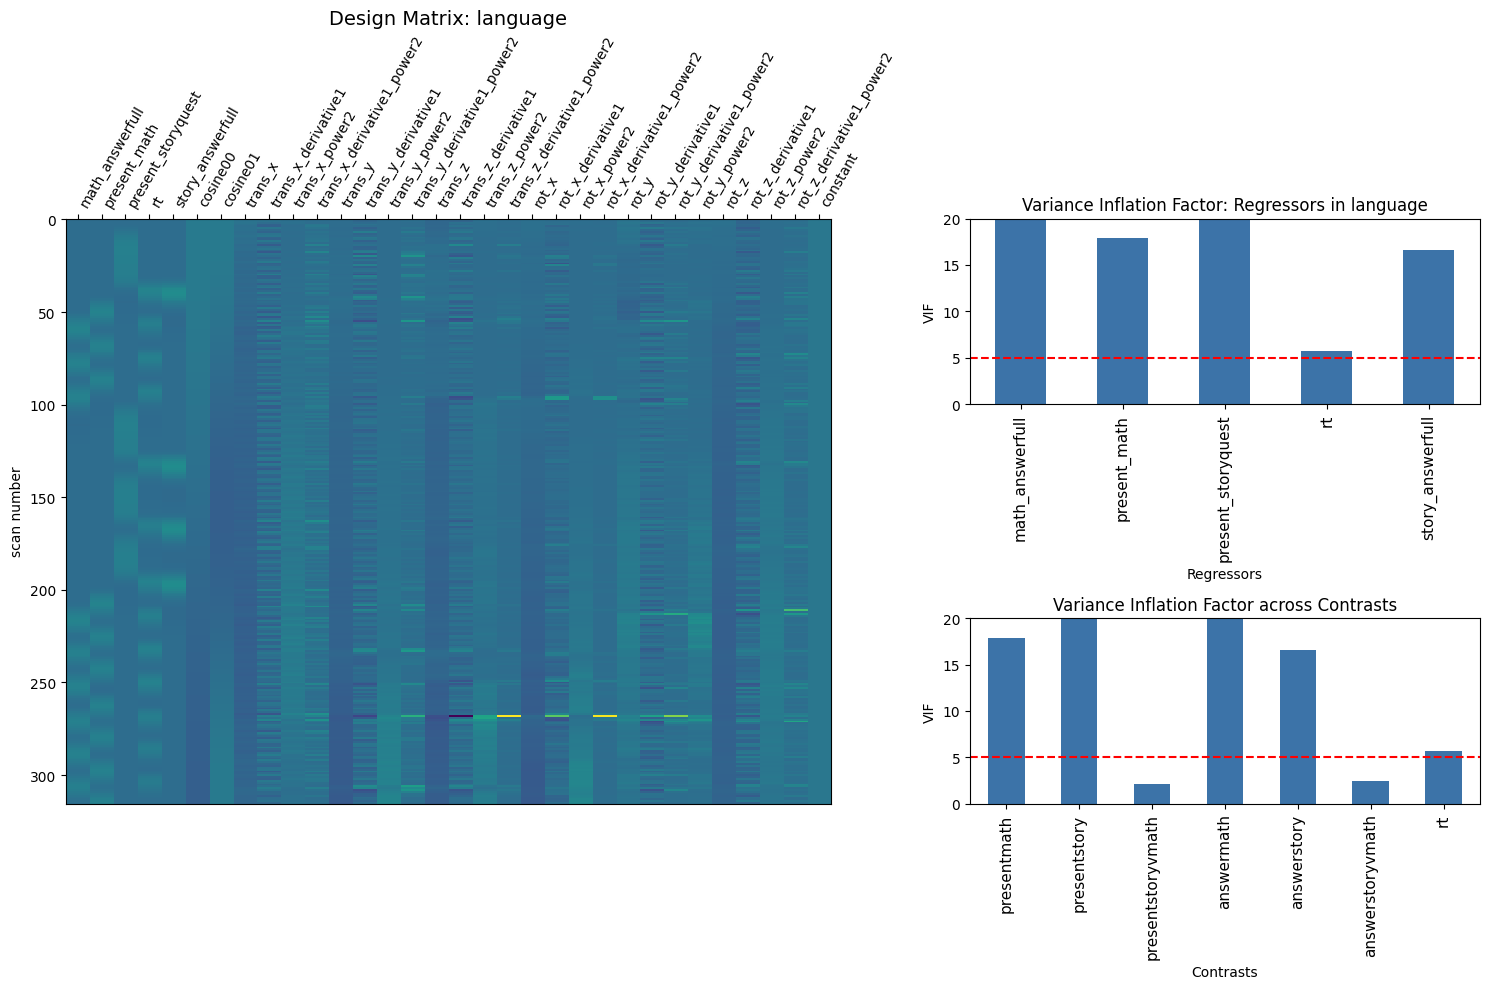

In [17]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_language_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

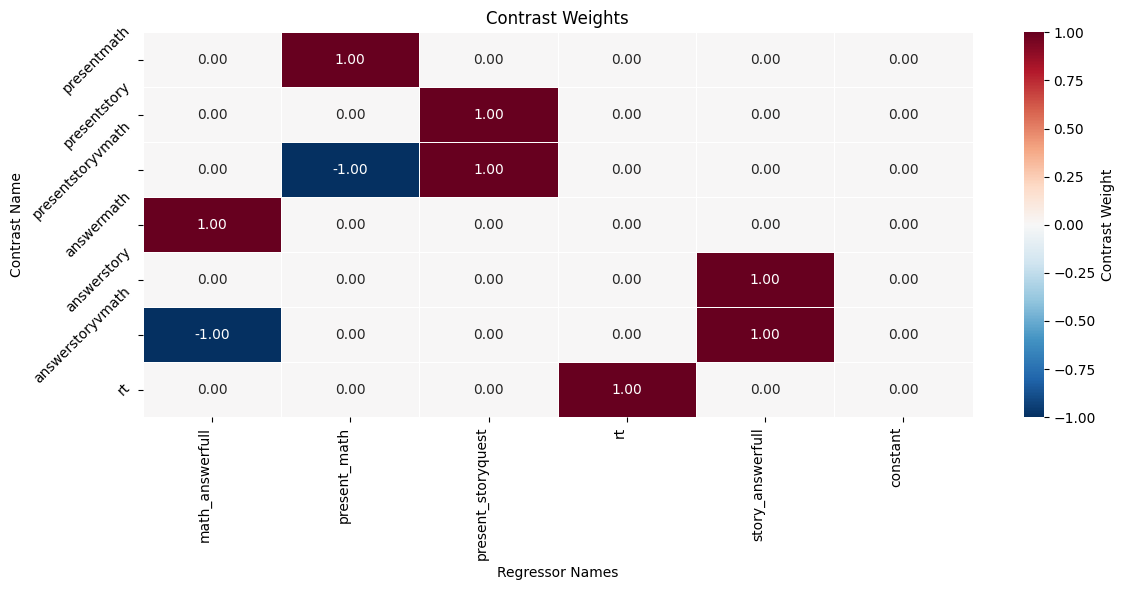

In [18]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


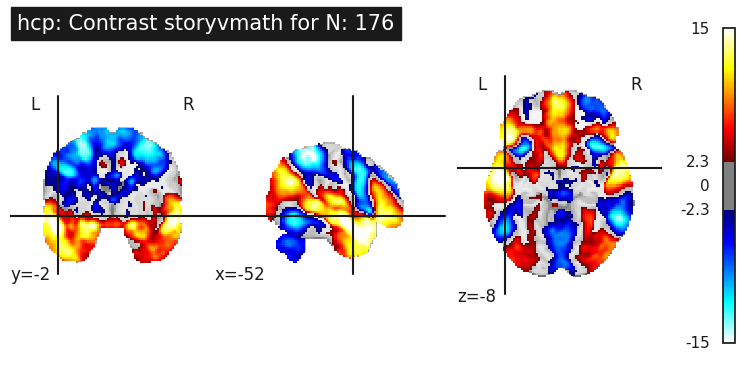

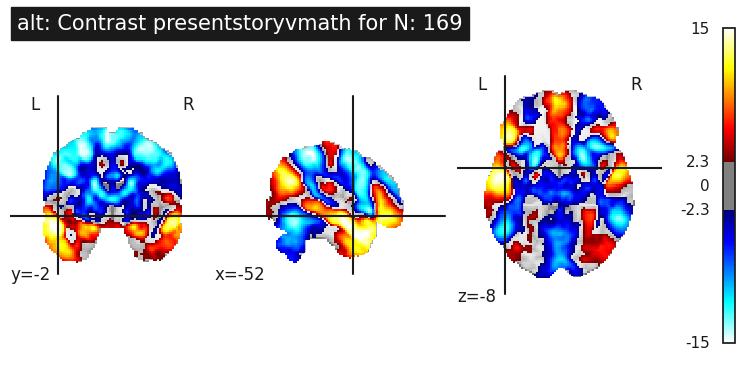

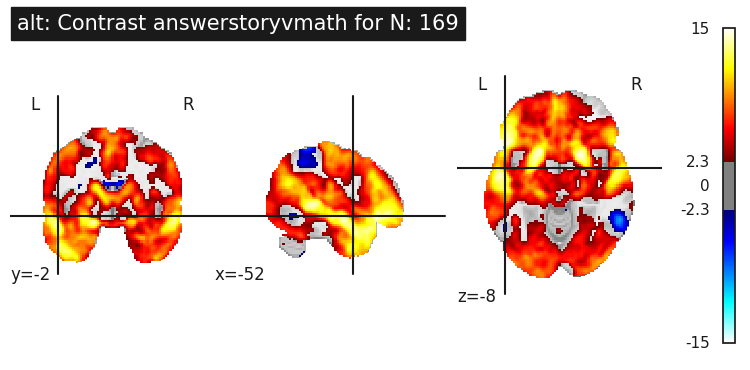

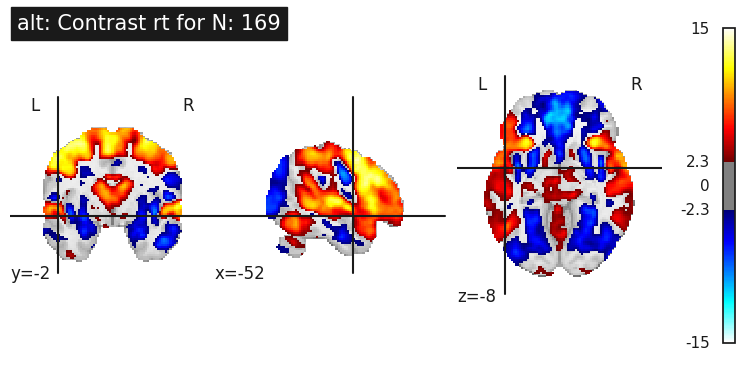

In [59]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=15, cut_coords=xyz_cord)


### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


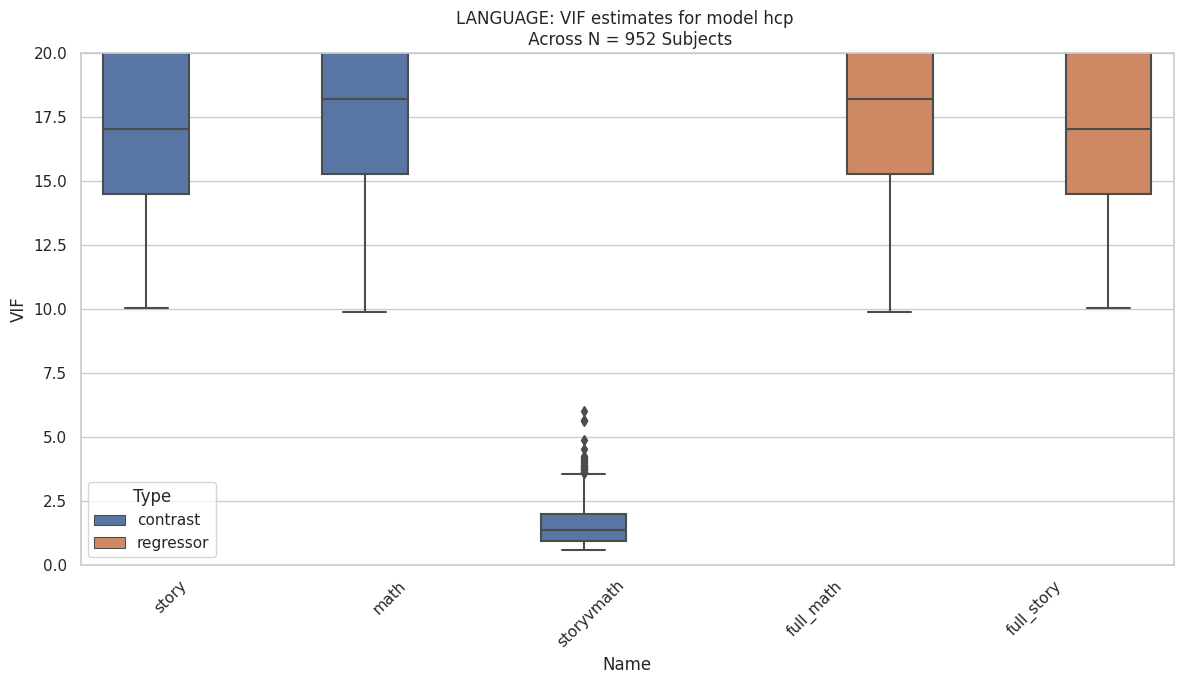

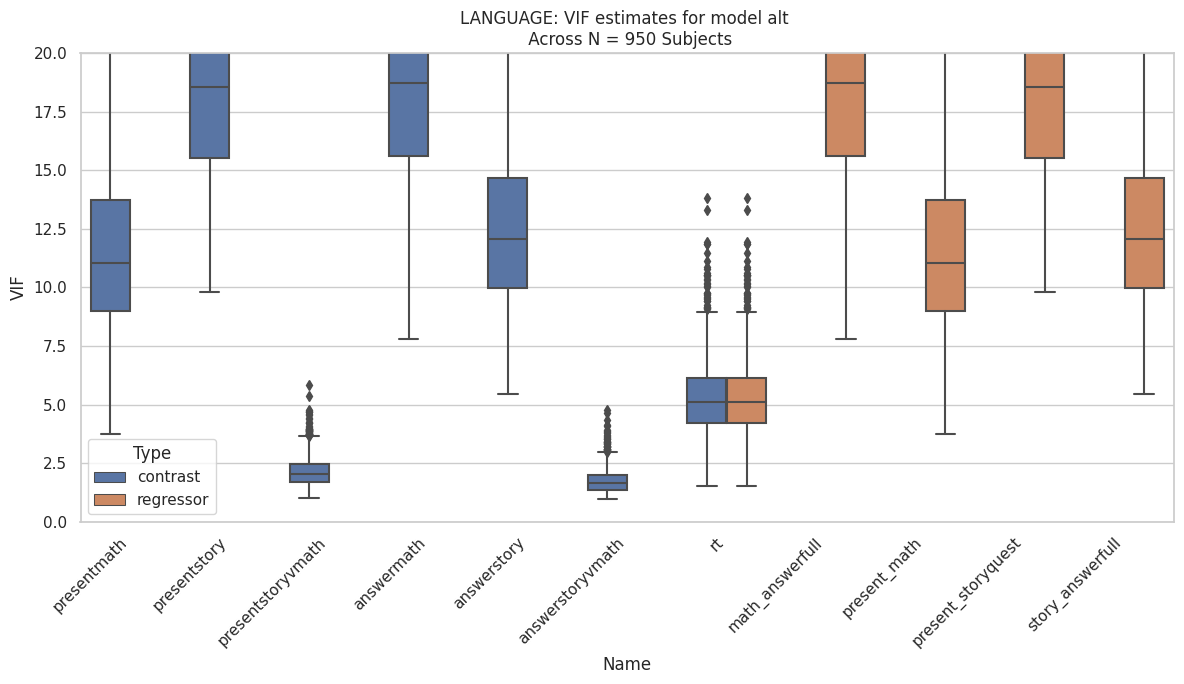

In [30]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [ ]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

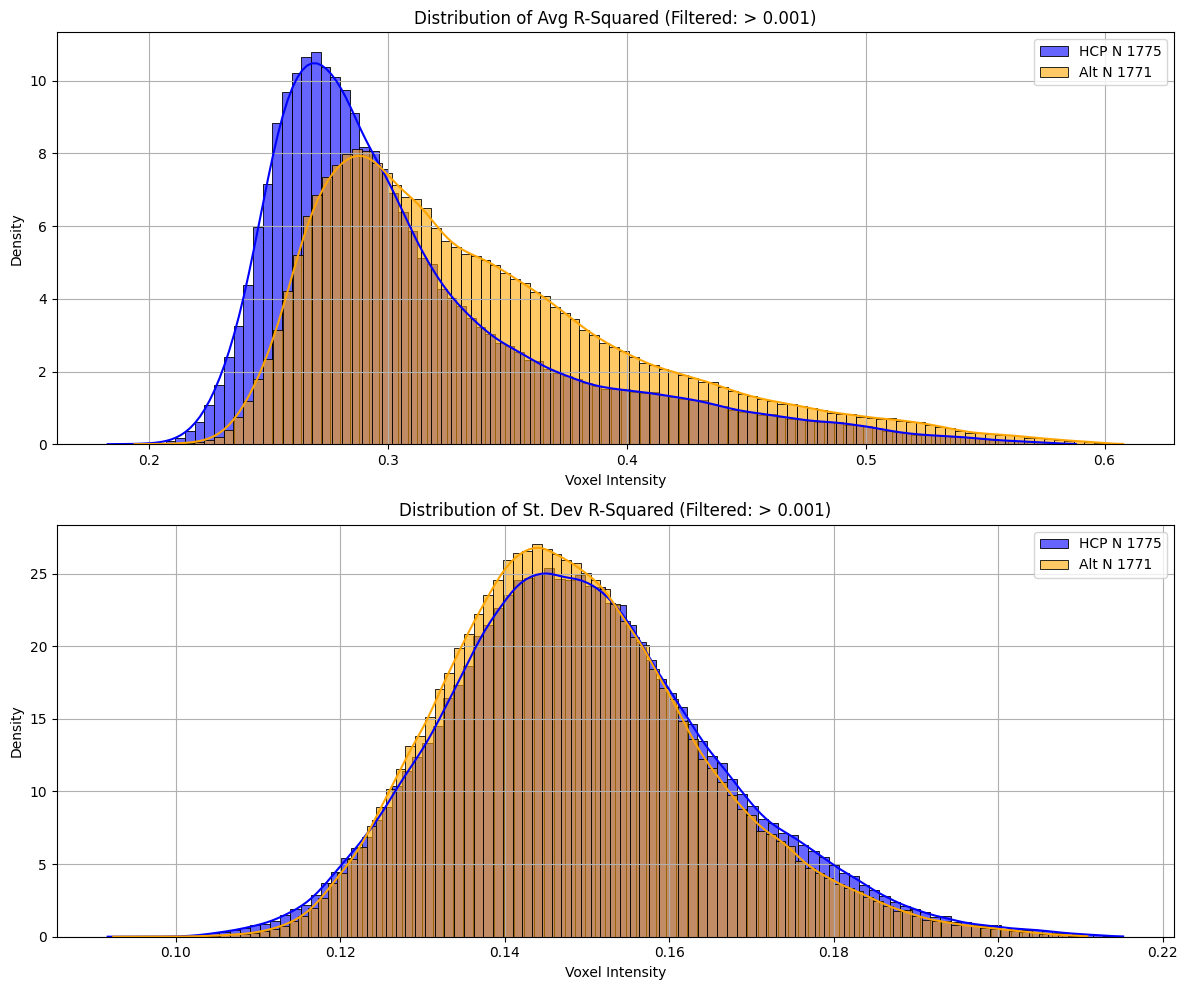

In [5]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Relational

Barch et al. (2013, pg 181). "Two predictors were included in the Relational Processing model — Relational processing and a control Matching condition. Each predictor covered the duration of 18 s composed of four trials for the Relational condition and five trials for the Matching condition."

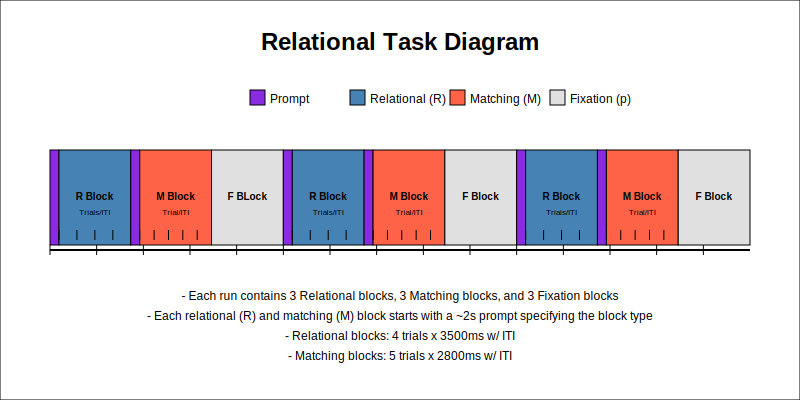

In [3]:
task = "relational"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [29]:
config = study_details[task]
subj_id="105115"
numvols = 232
boldtr = .720
run = '2'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['relation_prompt', 'relation_stim', 'relation_block',
       'relation_blank', 'control_prompt', 'control_block',
       'control_stim', 'control_blank', 'fix_block'], dtype=object)

The HCP models consecutive trials for the Relational and Control/Matching conditions as complete blocks, disregarding modeling prompts and/or response times. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_relational), the prompts for the Control and Relational blocks are similar, averaging 1970 ms and 1960 ms, respectively.

While the paper indicates that trial durations for the Control and Relational blocks are 2800 ms and 3500 ms, respectively, timing data from E-Prime suggests some variation, with average durations of 1570 ms for Control and 2130 ms for Relational. Additionally, the ISI durations differ between the Control and Relational blocks, averaging 1670 ms and 1910 ms, respectively. Notably, response times (RTs) vary across stimulus types and blocks.

**Expected Difference in Activation between HCP and Alt Model**: Moderate


### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


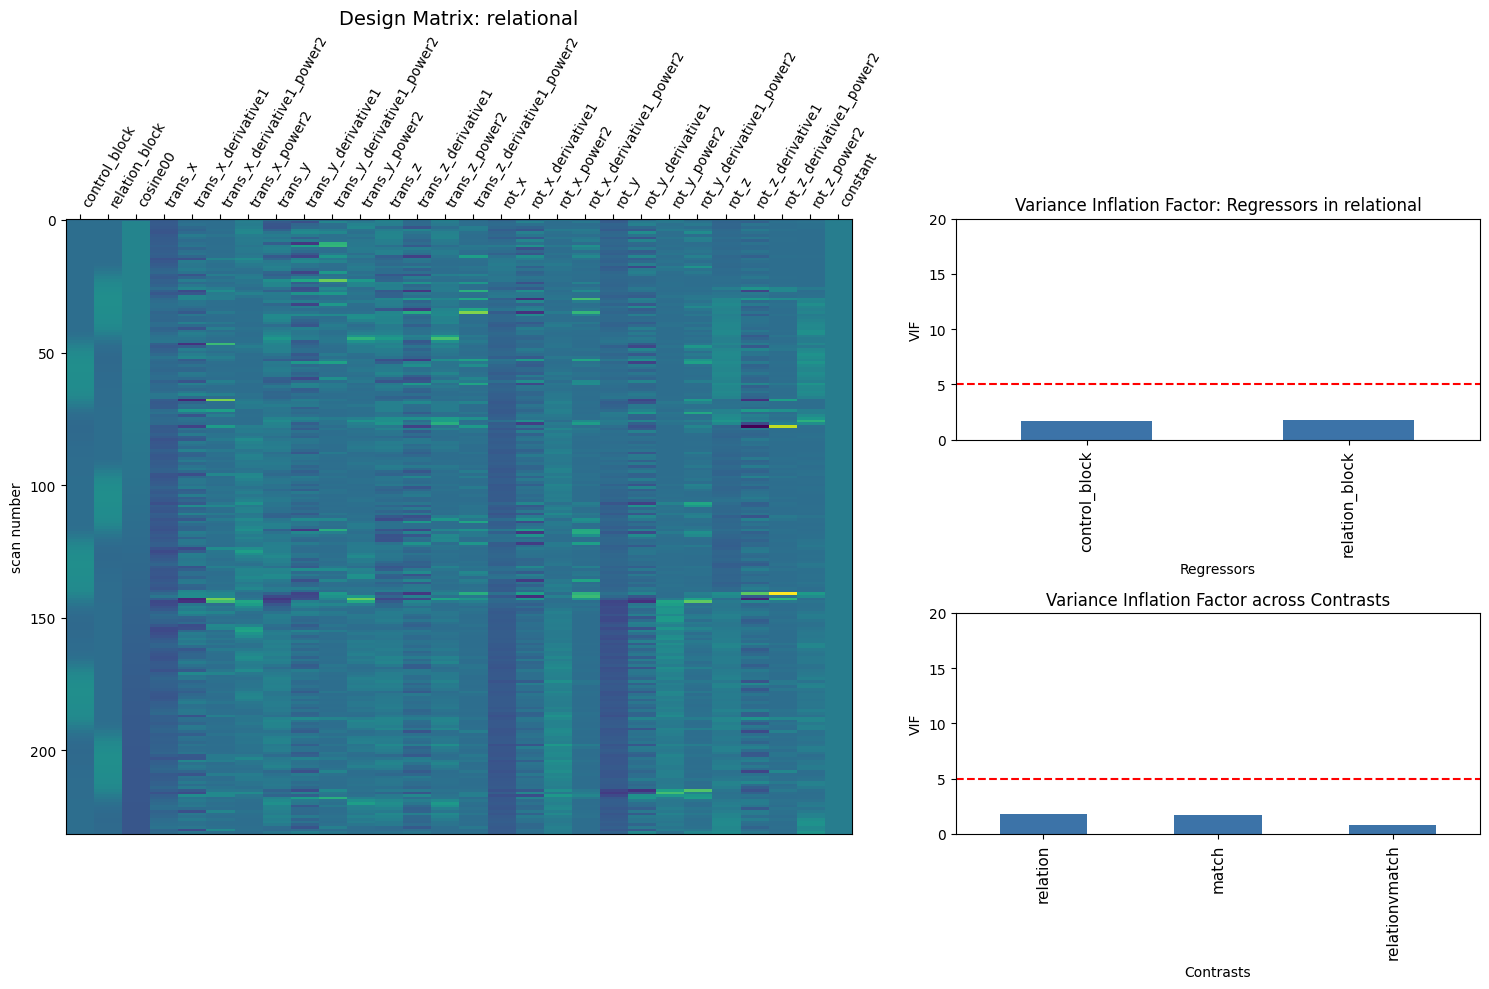

In [30]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_relation_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

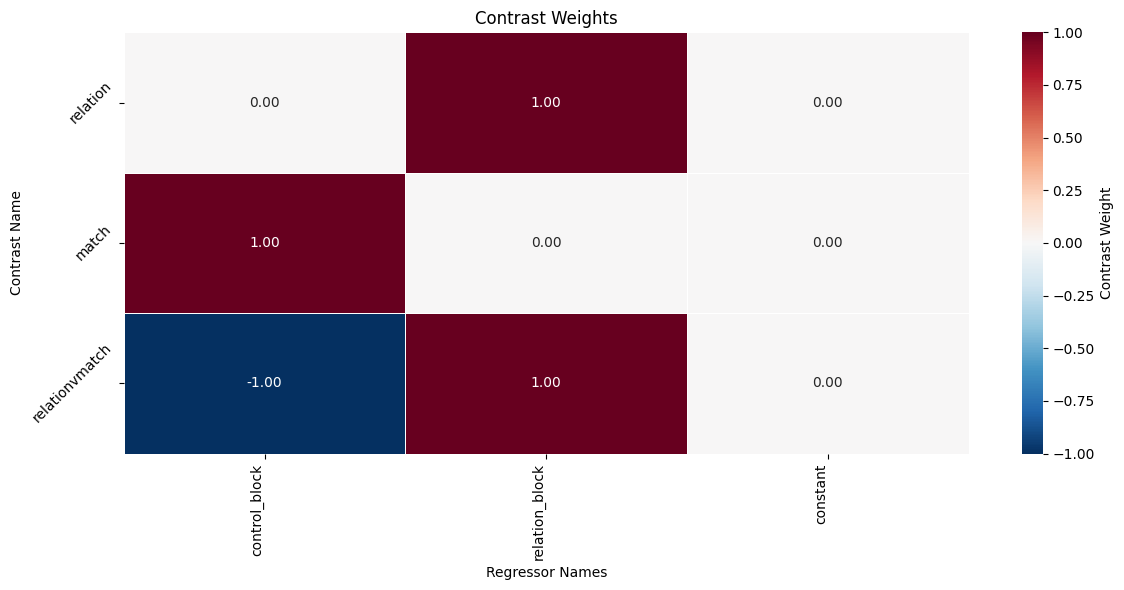

In [31]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

### Alt Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


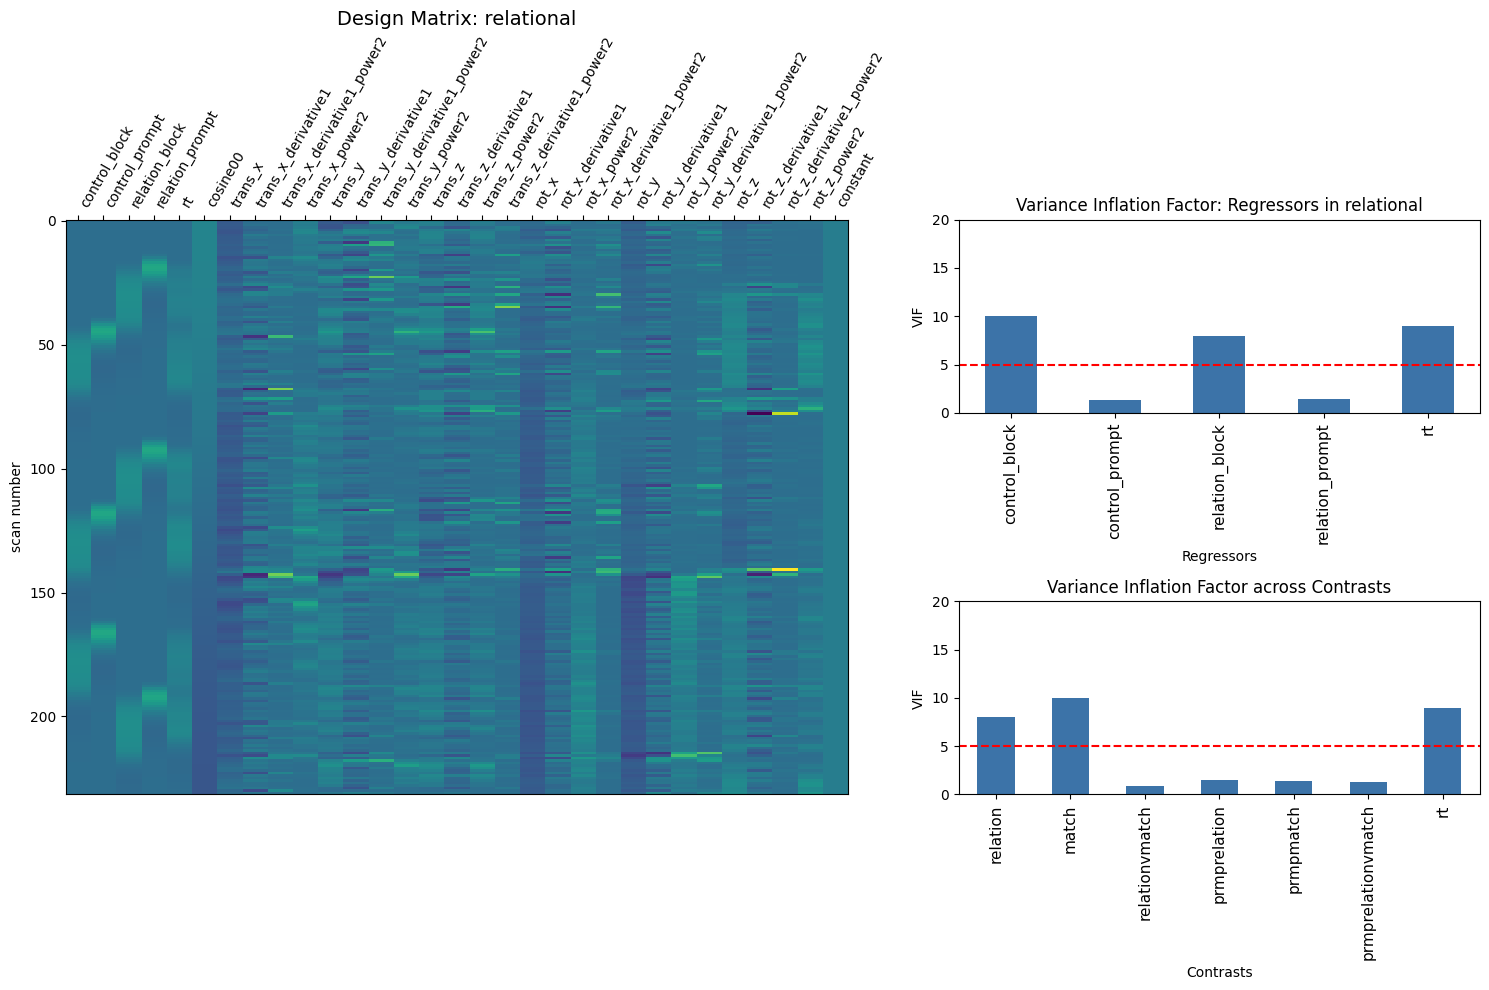

In [32]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_relation_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec)

design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

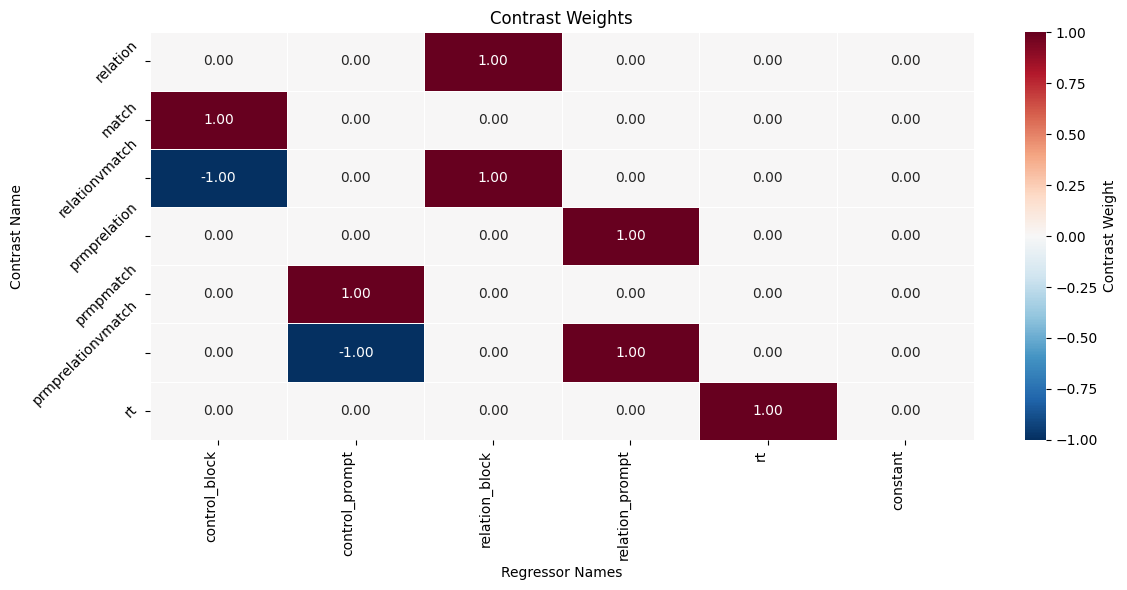

In [33]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


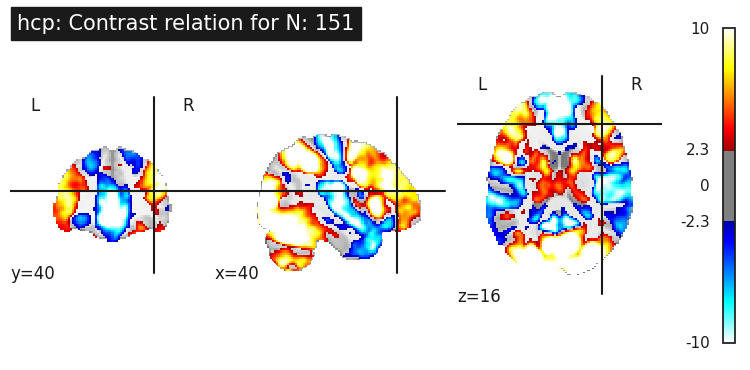

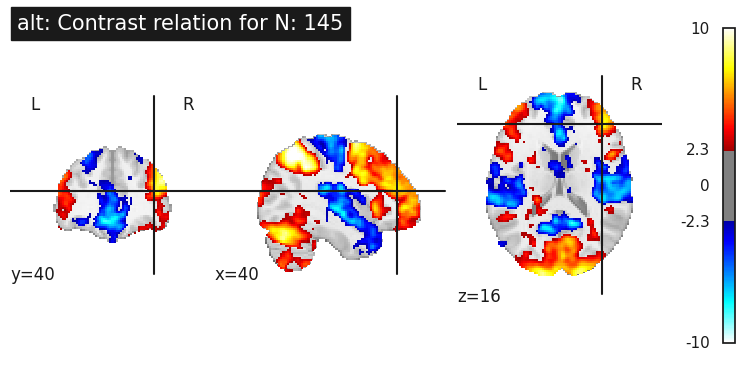

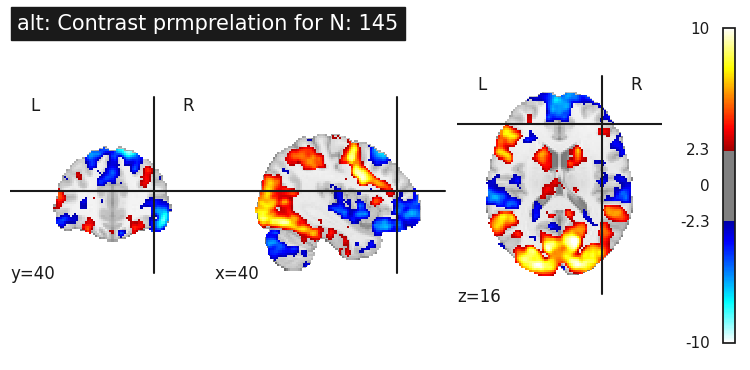

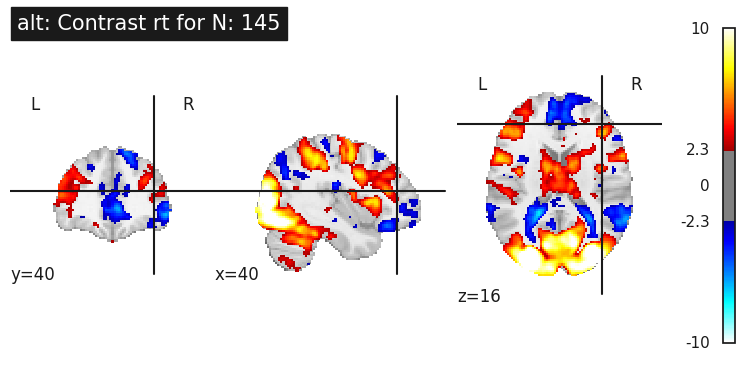

In [67]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=10, cut_coords=xyz_cord)

### VIF Distrbutions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


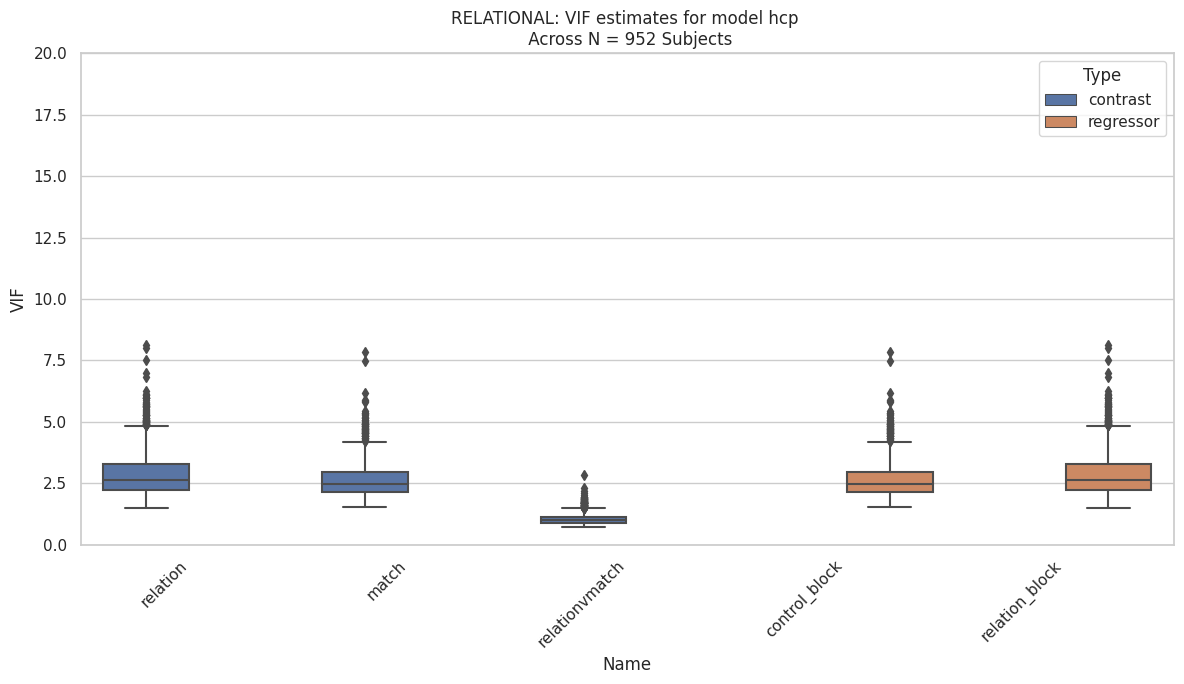

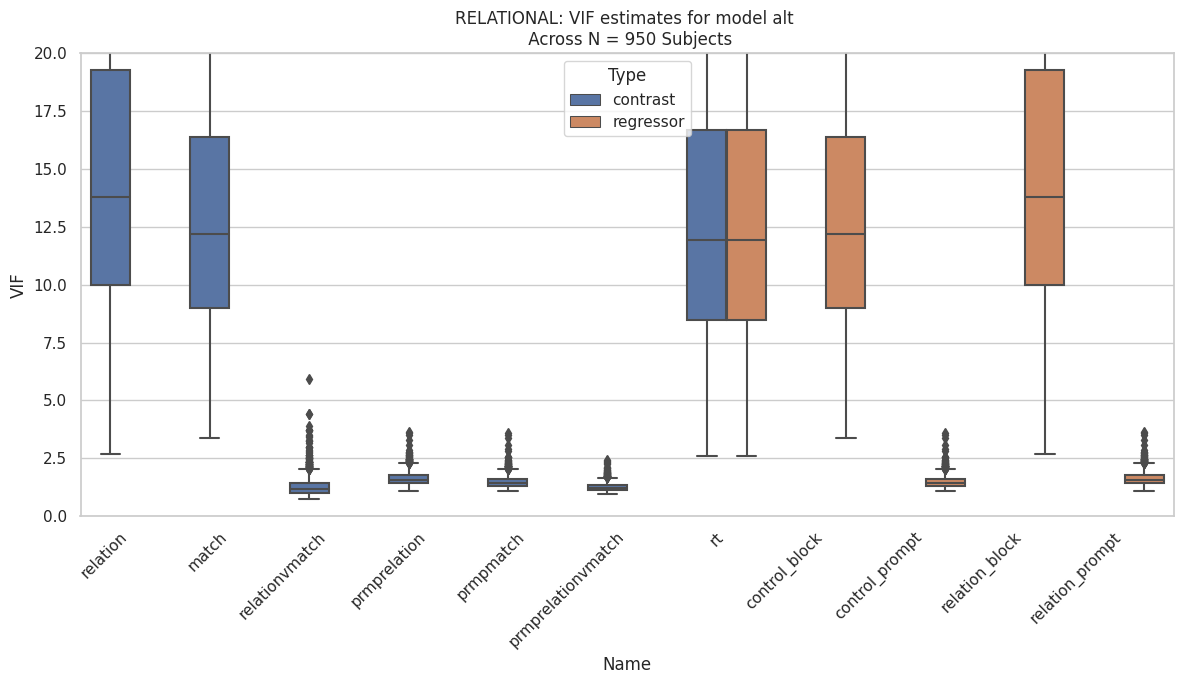

In [8]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [4]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

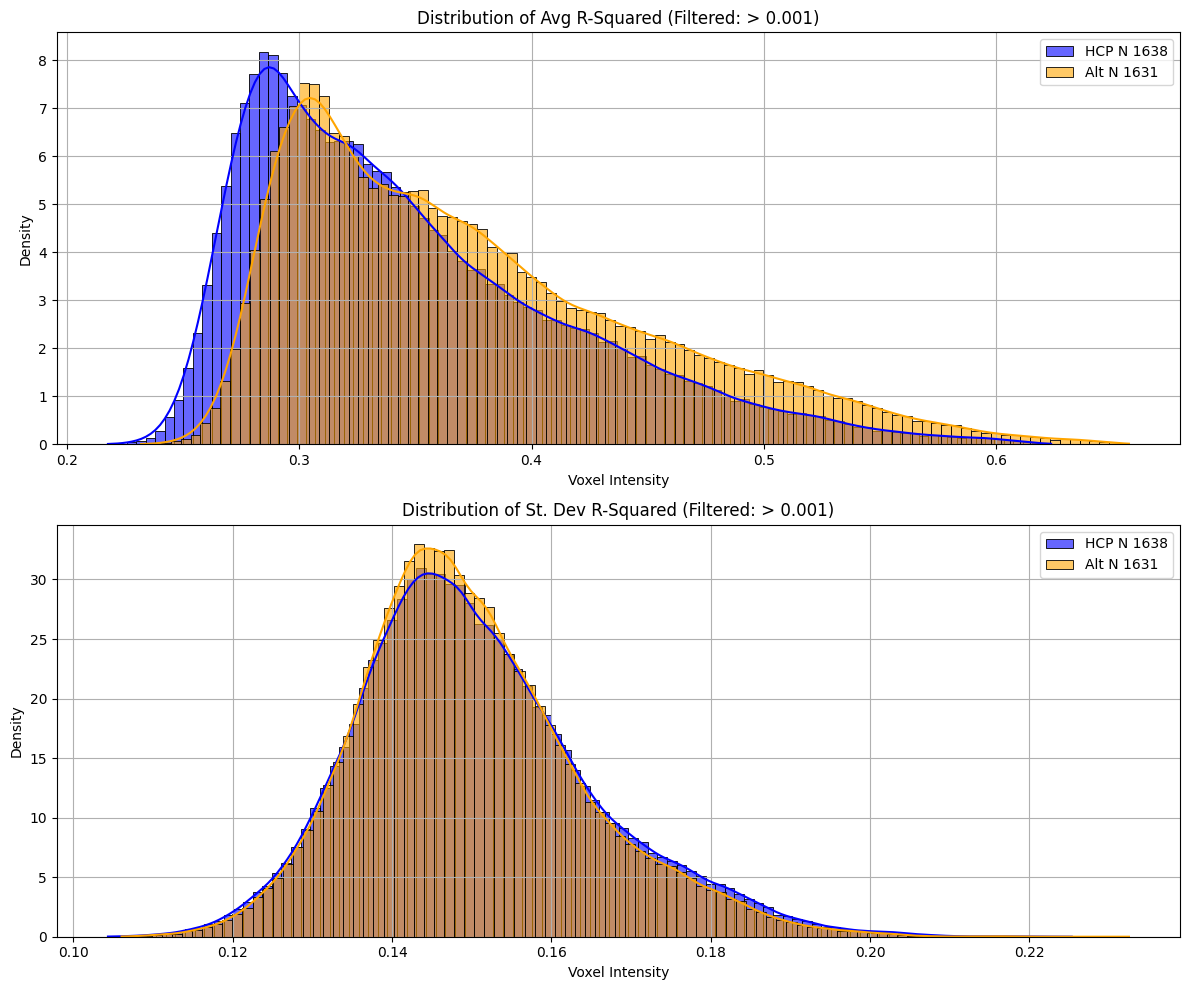

In [5]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Emotion

Barch et al. (2013, pg 181-182). "Two predictors were included in the Emotion Processing model — Emotional Faces and a Shape control condition. Each predictor covered a 21 s duration composed of a cue and six trials."

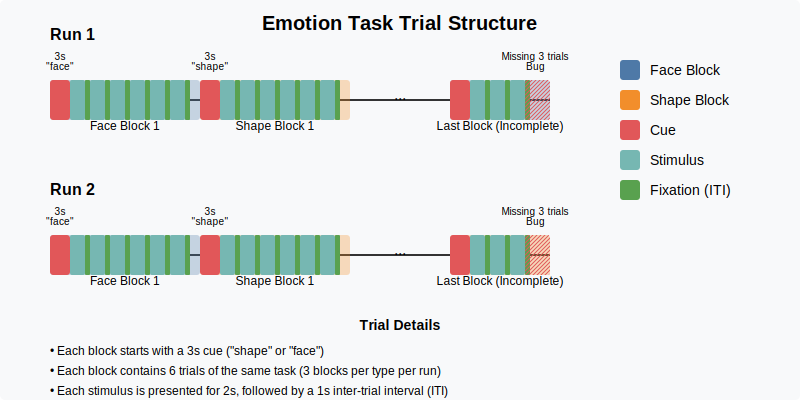

In [6]:
task = "emotion"
task_img = f"{schematic_path}/info_{task}/{task}_task_diagram.svg"
display(SVG(filename=task_img))

## Events Design Matrix

In [35]:
config = study_details[task]
numvols = 176
boldtr = .720
run = '1'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['cue_shape', 'shape_block', 'shape_stim', 'shape_isi', 'cue_face',
       'face_stim', 'face_block', 'face_isi'], dtype=object)

### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


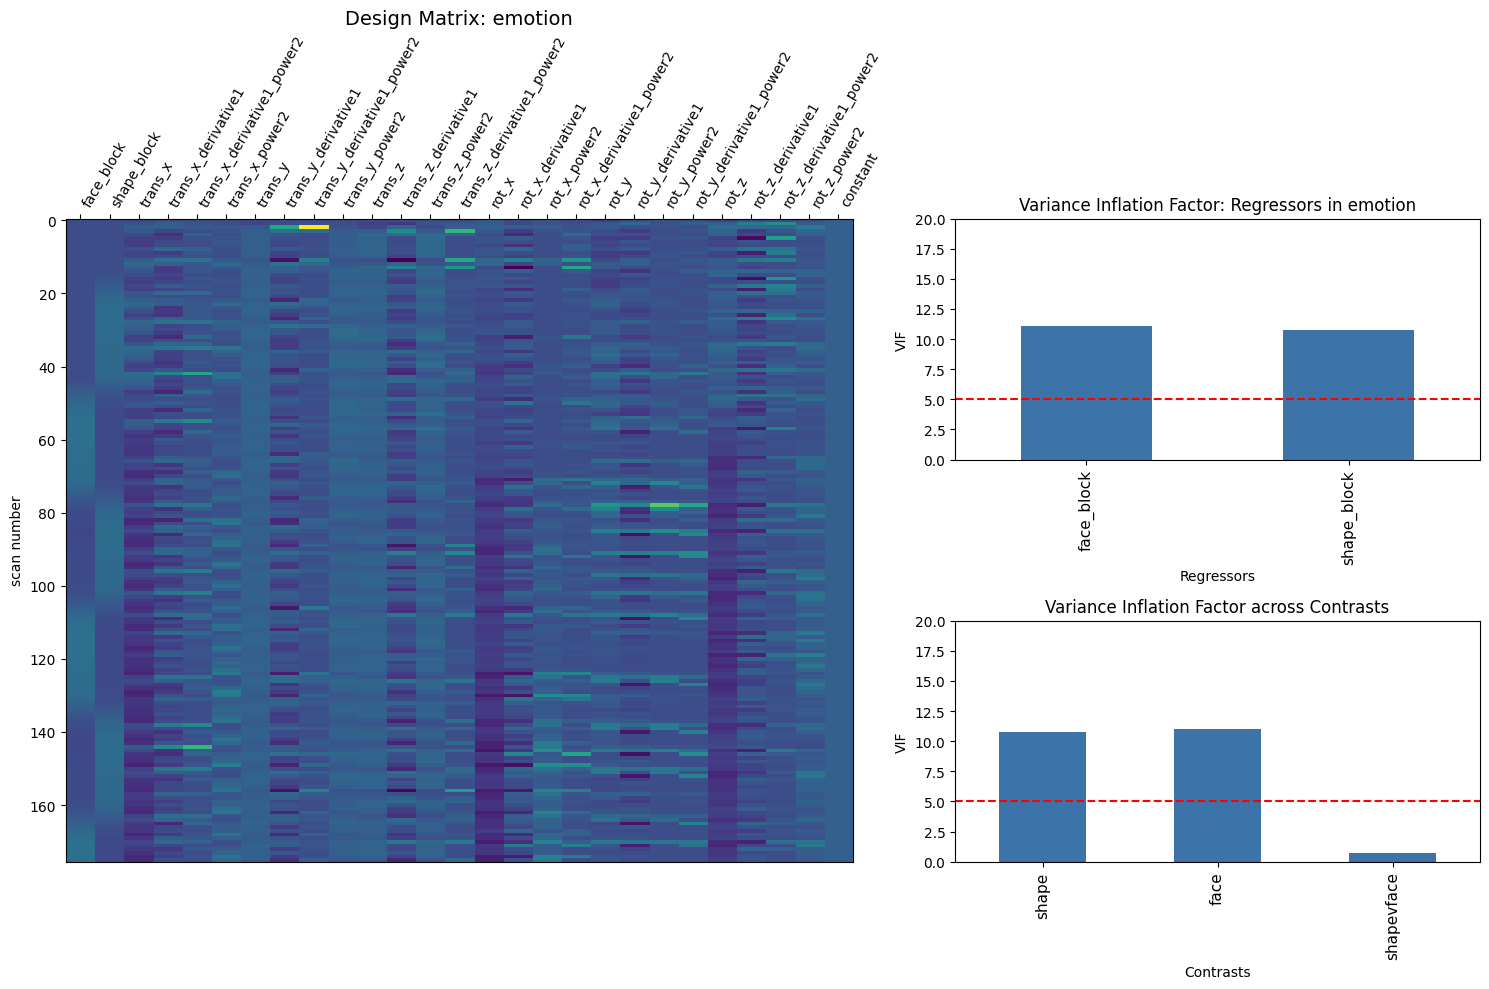

In [36]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_emotion_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

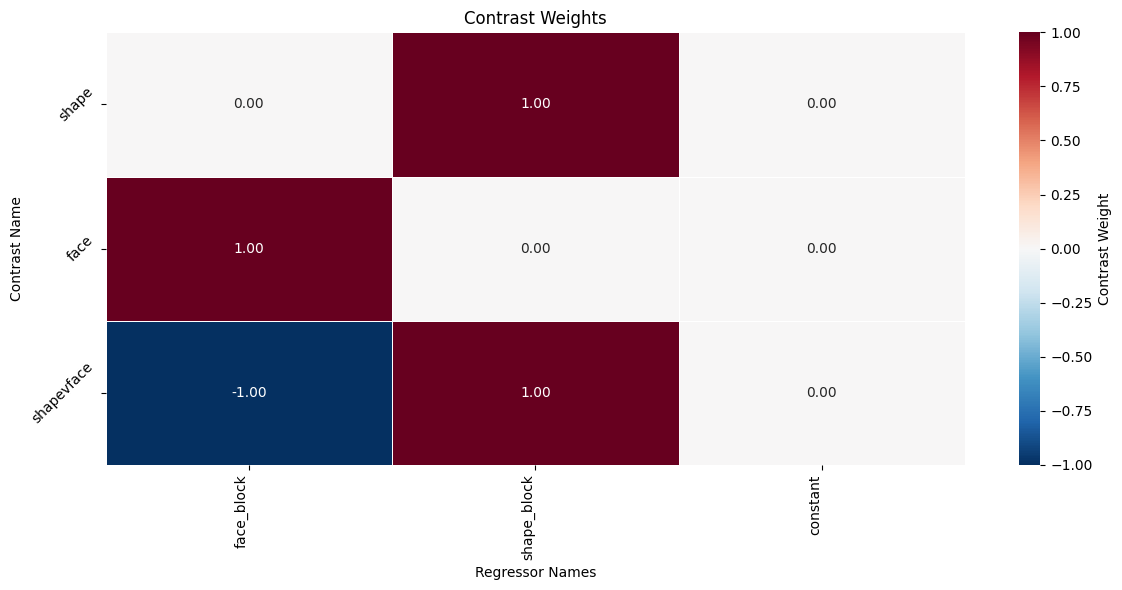

In [37]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

### Alt Model

The HCP models the consecutive trials with cue for the faces and shape blocks. As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_emotion), there are some differences in distributions. Consistent with the description of the e-prime coding in the paper, the final block has a duration error but it is unique for the final faces block and not the shapes block. Notably, the timings are impact more by block rather than trial type. In this alternate design, we model cues for each block type and the each block type separately. 

**Expected Difference in Activation between HCP and Alt Model**: Minimal


    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


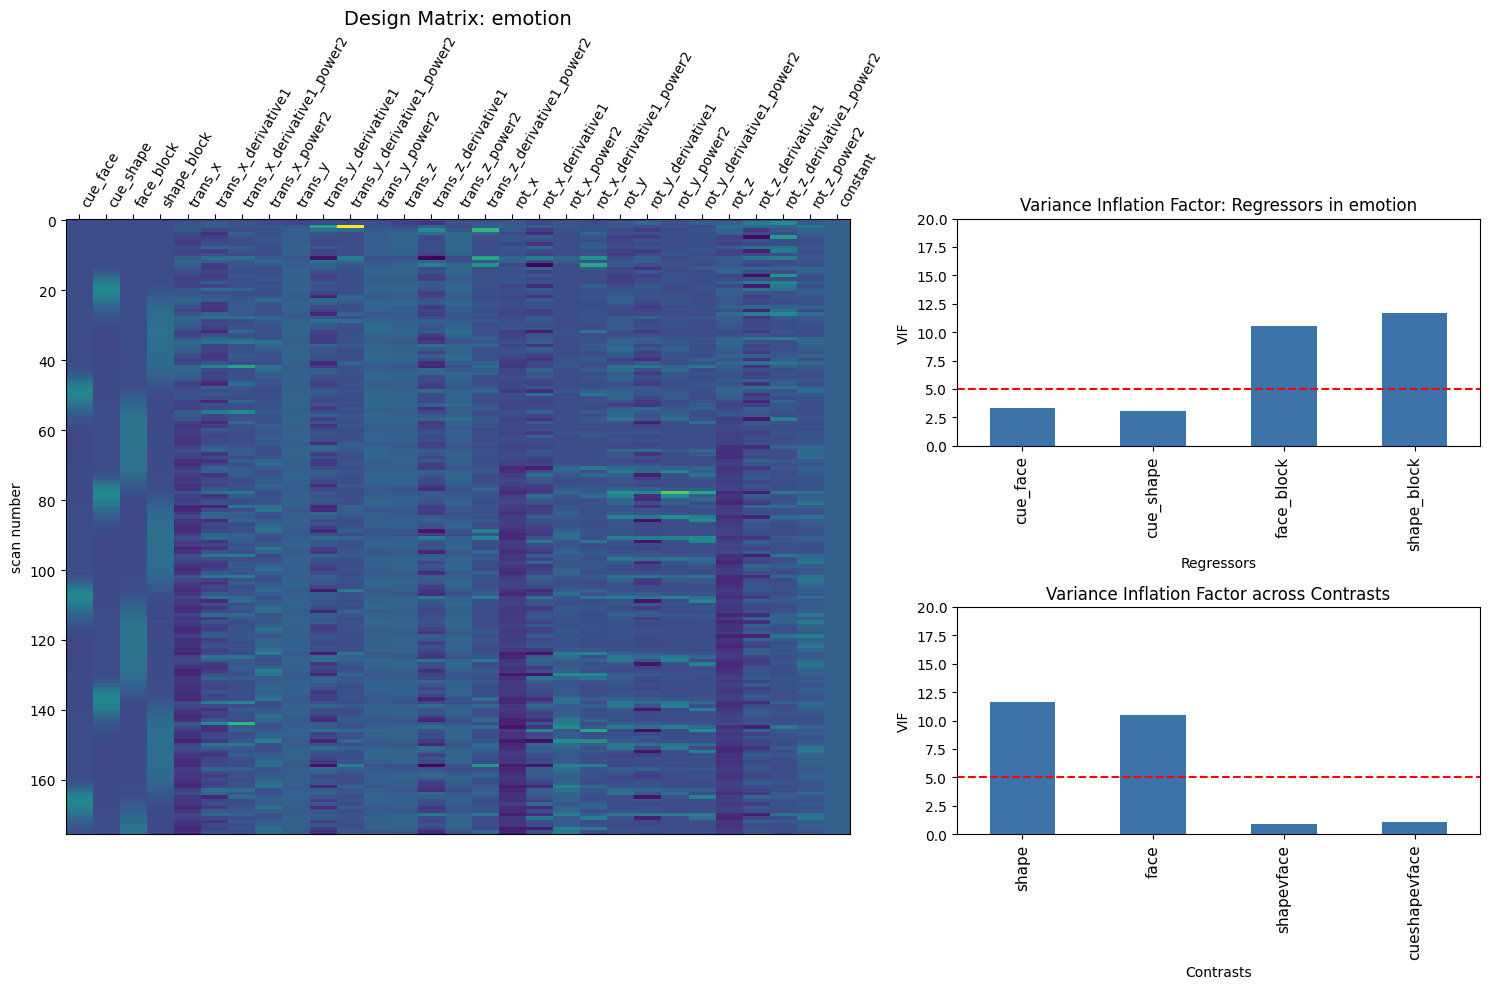

In [38]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_emotion_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass)

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

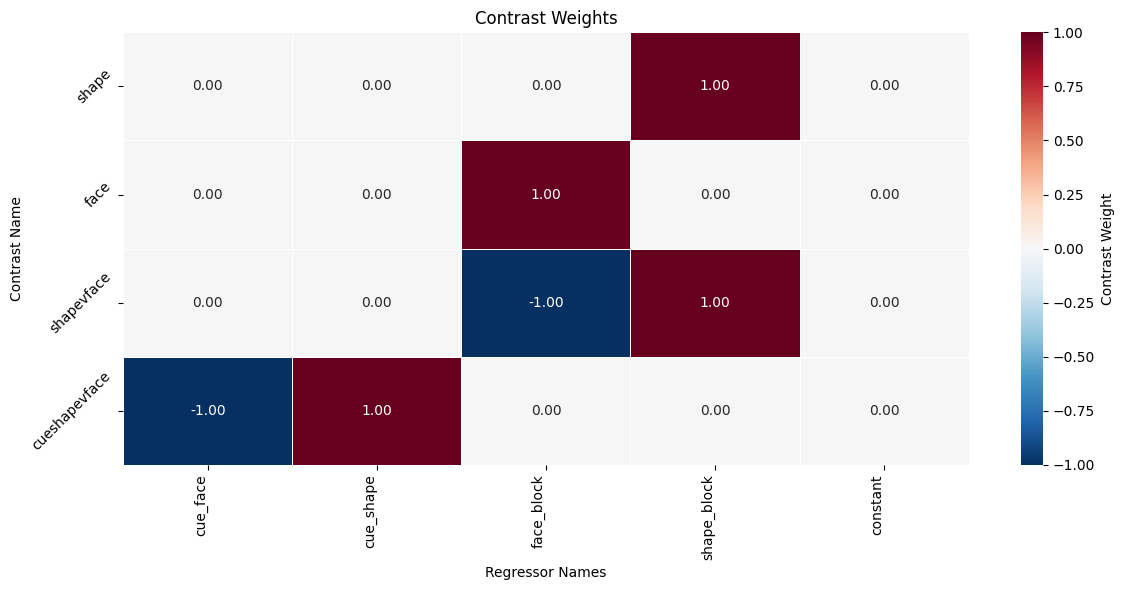

In [39]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


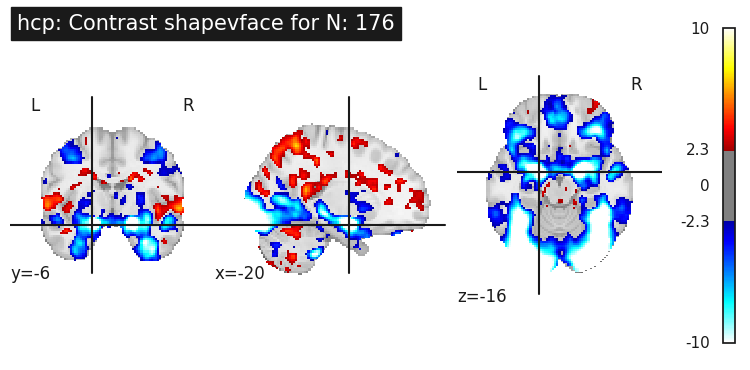

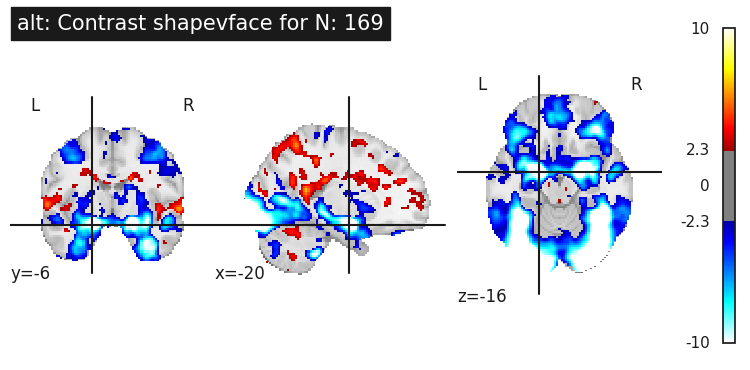

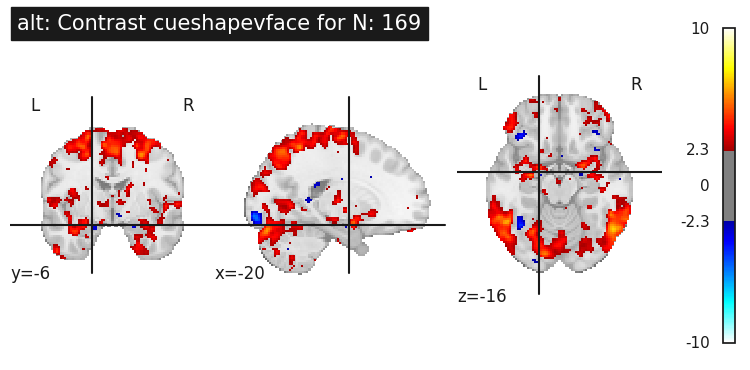

In [75]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=10, cut_coords=xyz_cord)


### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


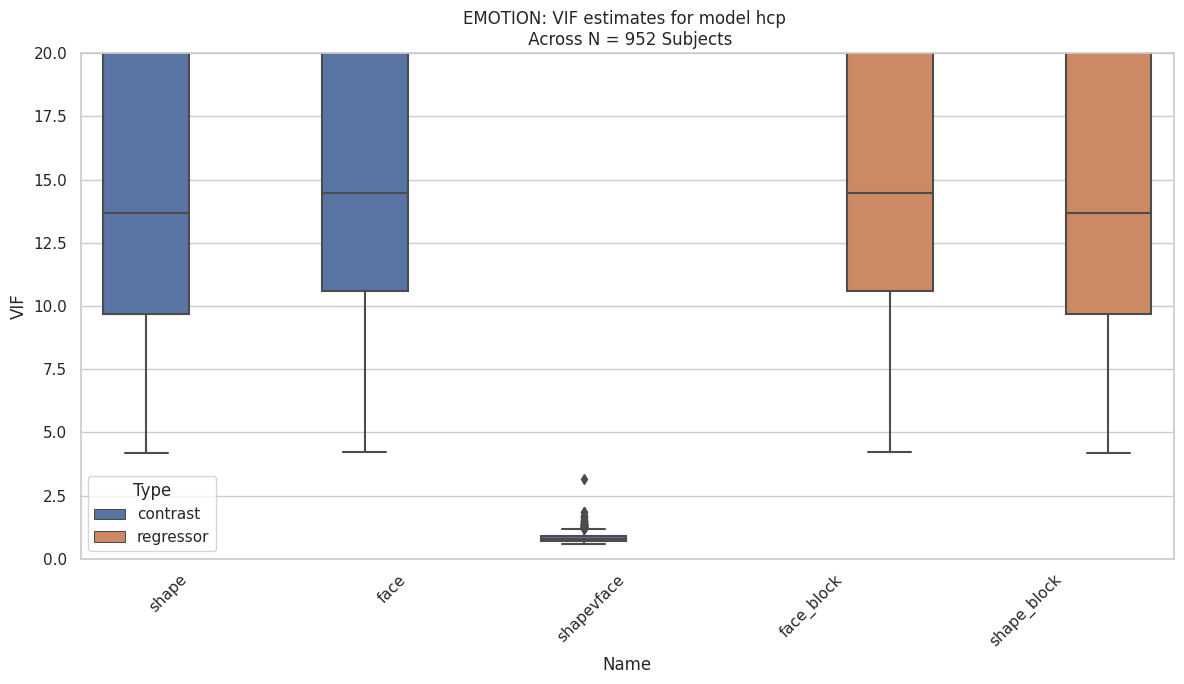

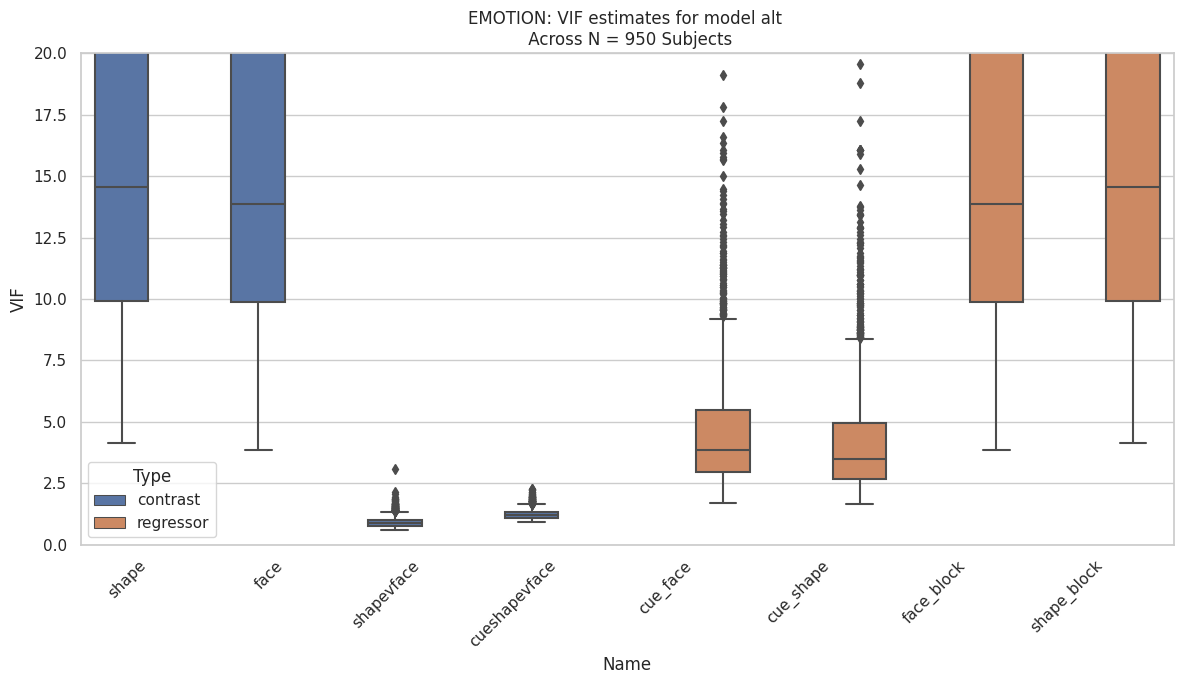

In [7]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [8]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

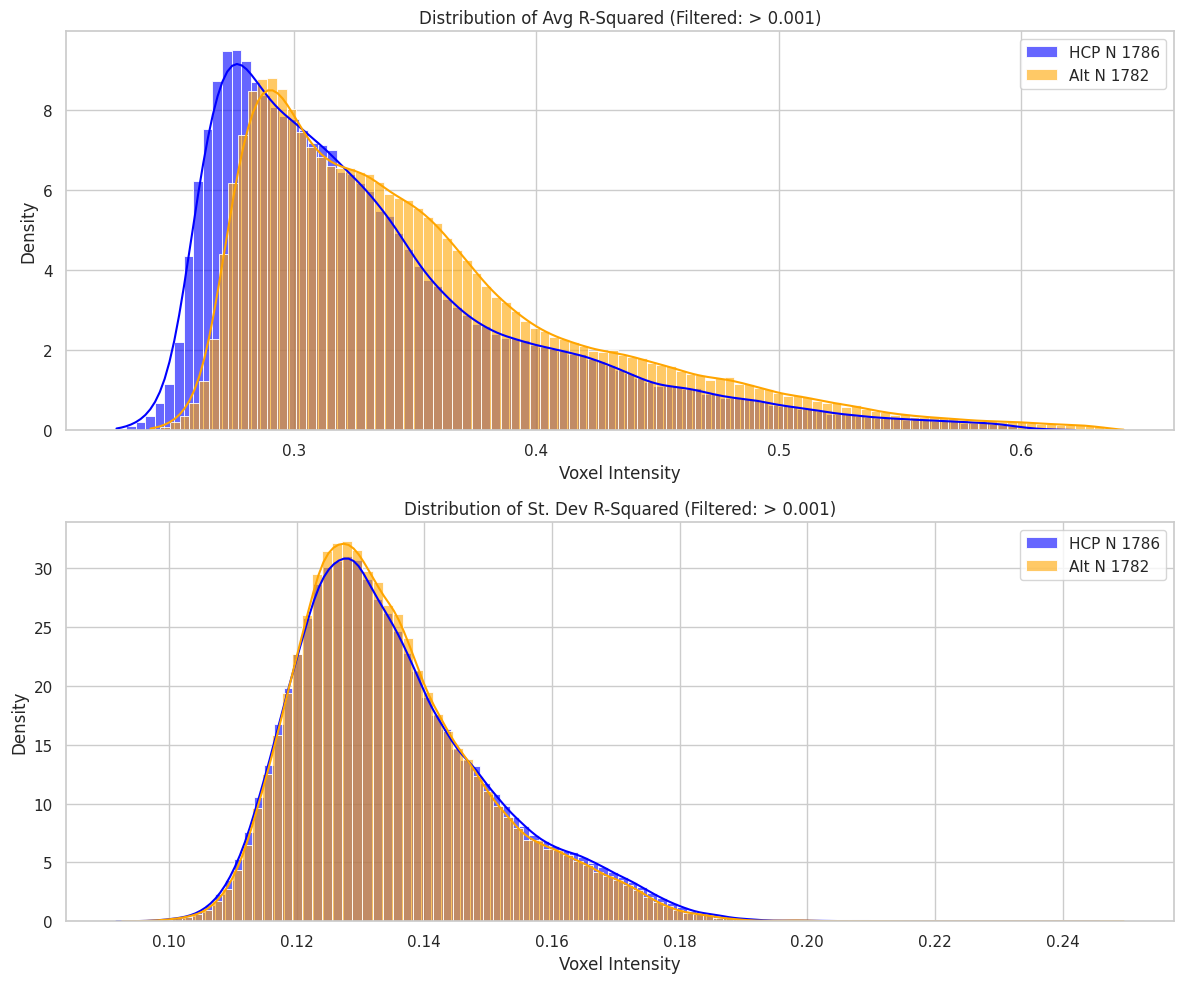

In [9]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Working Memory

Barch et al. (2013, pg 181).  "For both analysis streams, eight predictors were included in the model for Working Memory/Category Specific Representations — one for each type of stimulus in each of the N-back conditions (i.e., 2-Back Body, 0-Back Body, 2-Back Face and  0-Back Face). Each predictor covered the period from the onset of the cue to the offset of the final trial (27.5 s). Linear contrasts for these predictors were computed to estimate effects of interest: 2-back (vs. fixation), 0-back, 2-back vs. 0-back, each stimulus type versus baseline (e.g., Body vs. fixation, collapsing across memory load), and each stimulus type versus all others."

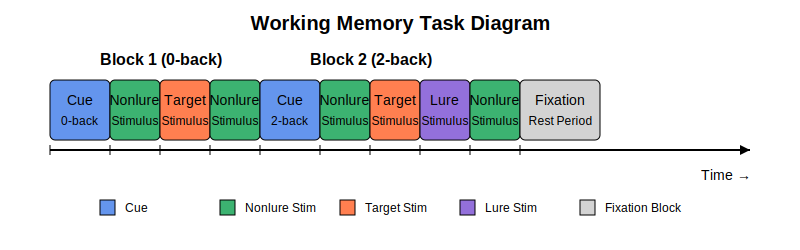

In [10]:
task = "WM" # WM for fmriprep output
task_img = f"{schematic_path}/info_{task.lower()}/workmemory_task_diagram.svg"
display(SVG(filename=task_img))

## Event Design Matrix

In [41]:
config = study_details[task]
numvols = 405
boldtr = .720
run = '2'
event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
event_df['trial_type'].unique()

array(['cue_2back', '2back_nonlure', '2back_full', '2back_lure',
       '2back_target', 'cue_0back', '0back_nonlure', '0back_full',
       '0back_lure', '0back_target', 'fixation'], dtype=object)

The HCP models consecutive trials with cues for the 0-back and 2-back blocks across different trial types (e.g., body, faces, tools). As reported [here](https://github.com/demidenm/hcpya_preprocess/tree/main/scripts/taskevents/info_wm), differences in distributions exist. As expected, average response times vary by trial type, with the 2-back conditions being meaningfully slower than the 0-back conditions across non-lure, target, and lure trials. The alternative model takes into account the activation for cue that differ by memory load type (0- and 2-back), the block-level stimuli (0- and 2-back across face, place, tools, body) and the response trial-level response times.

**Expected Difference in Activation between HCP and Alt Model**: Moderate


### HCP Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


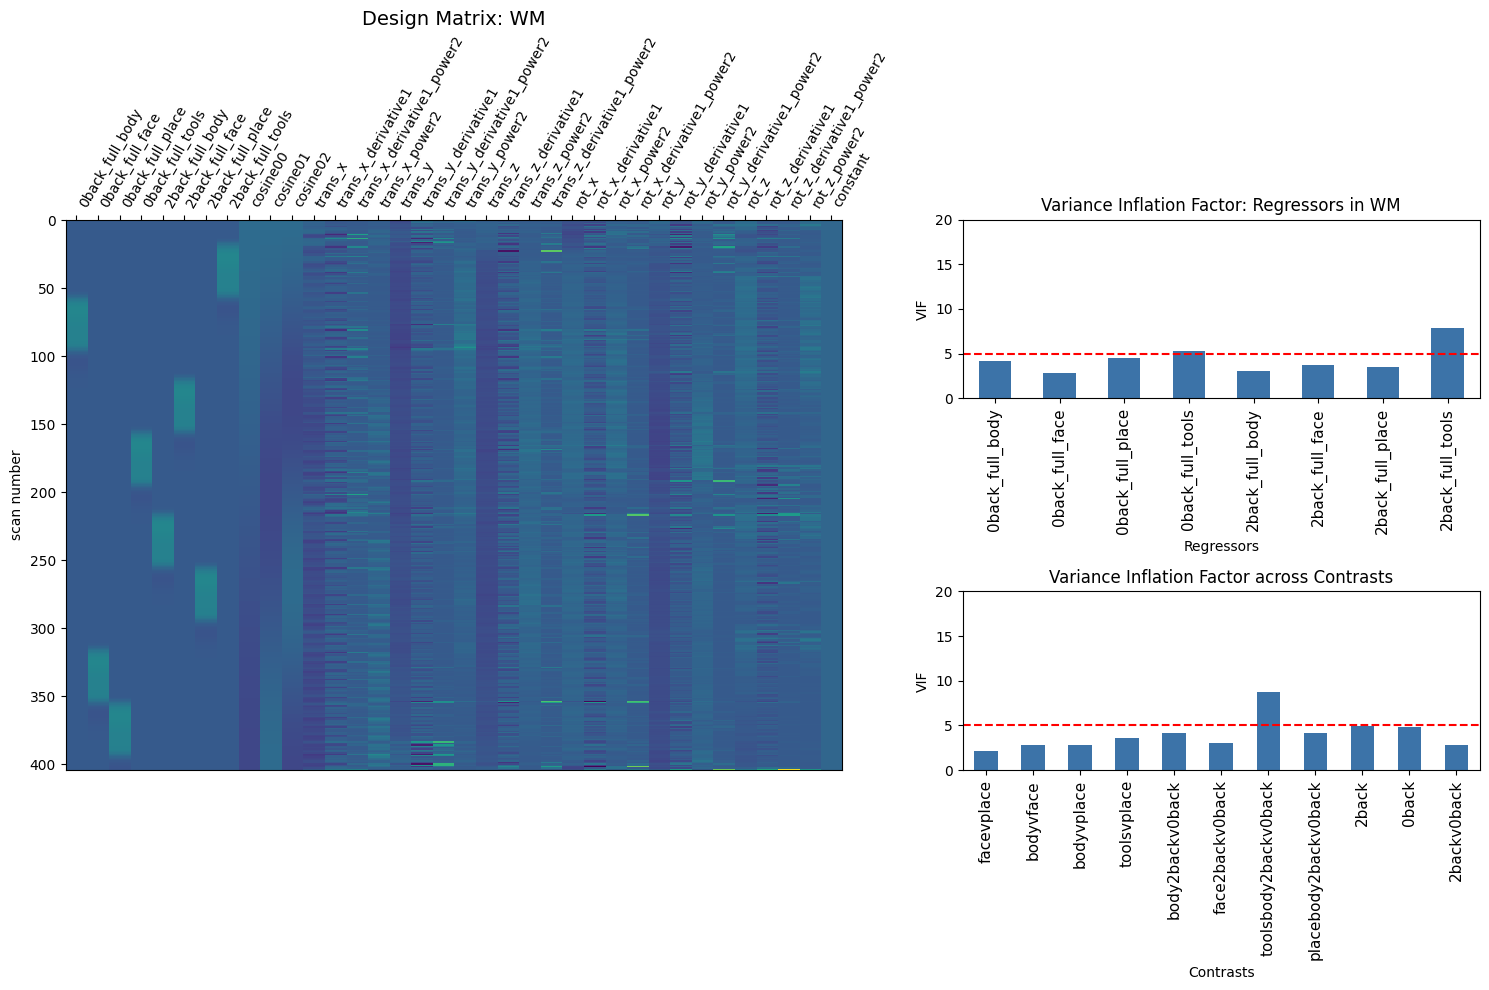

In [42]:
mod_spec = "hcp"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files UPDATE MEMORY TO UPPERCASE
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_wm_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

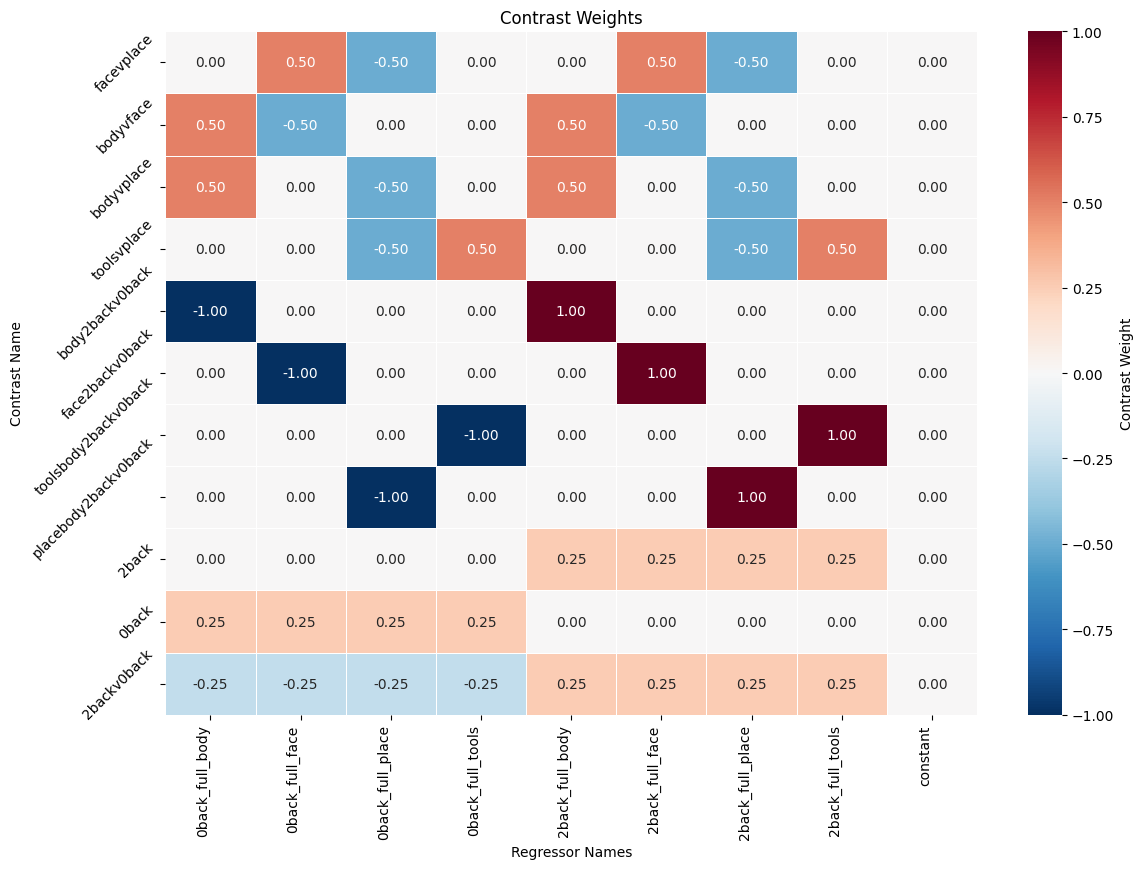

In [43]:
fig, contrast_weights, weights_df = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
# task name should be upper for WM
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

### Alt Model

    For variables in confounds: cosine|trans|rot, NaNs were replaced with 0


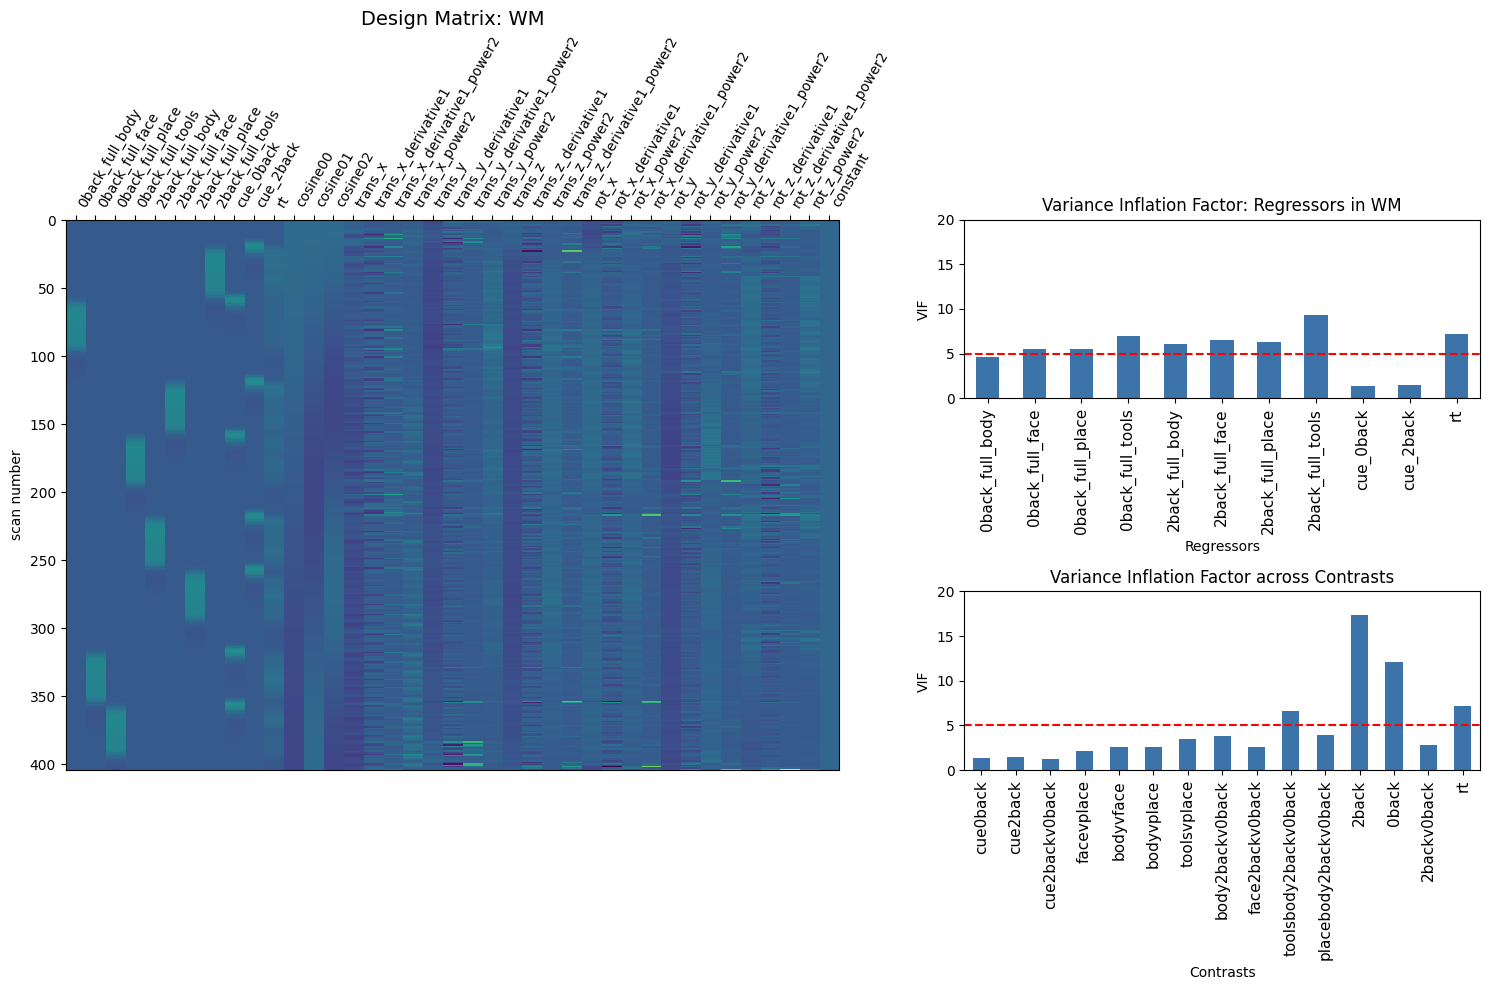

In [44]:
mod_spec = "alt"
mod_config = config[mod_spec]
fwhm = float(config['fwhm'])
ar_noisemod = str(config['noise_mod'])
highpass = int(config['highpass']) if config['highpass'] else None
detrend = str(config['detrend']) if config['detrend'] else None
n_vols = numvols

event_path = sorted(Path(events_path).rglob(f"sub-{subj_id}_{ses}_task-{task.upper()}_dir-*_run-{run}_events.tsv"))
event_df = pd.read_csv(event_path[0], sep = '\t')
eventdf_cpy = event_df[event_df['trial_type'].isin(mod_config['trialtype_filter'])].copy()

# conf files UPDATE MEMORY TO UPPERCASE
conf_fullpath = f"sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_desc-confounds_timeseries.tsv"
conf_path = next(Path(test_fmriprep_path).glob(conf_fullpath), None)

events_dat = prep_wm_events(eventsdf=event_df, trialtype_colname=mod_config['trialtype_colname'], 
                                incl_trialtypes=mod_config['trialtype_filter'], modtype=mod_spec, new_trialcol_name='new_trialtype')
design_matrix = create_design_matrix(eventdf=events_dat, conf_path=conf_path, conflist_filt=mod_config['nuisance_regressors'], 
                     stc=bool(config['slice_time_corr']), mod_dict=mod_config, volumes=n_vols, 
                     time_rep=float(config['boldtr']), hrf_type=config['hrf_type'],
                     driftmod=detrend, highpass=highpass, trialtype_colname='new_trialtype')

# VIFs ESTIMATE WITH ALL TASK REGRESSORS
con_vifs, reg_vifs, _ = gen_vifdf(designmat=design_matrix, modconfig=mod_config)
fig = plot_design_vifs(designmat=design_matrix, regressor_vifs=reg_vifs, contrast_vifs=con_vifs, task_name=task)
plt.show()

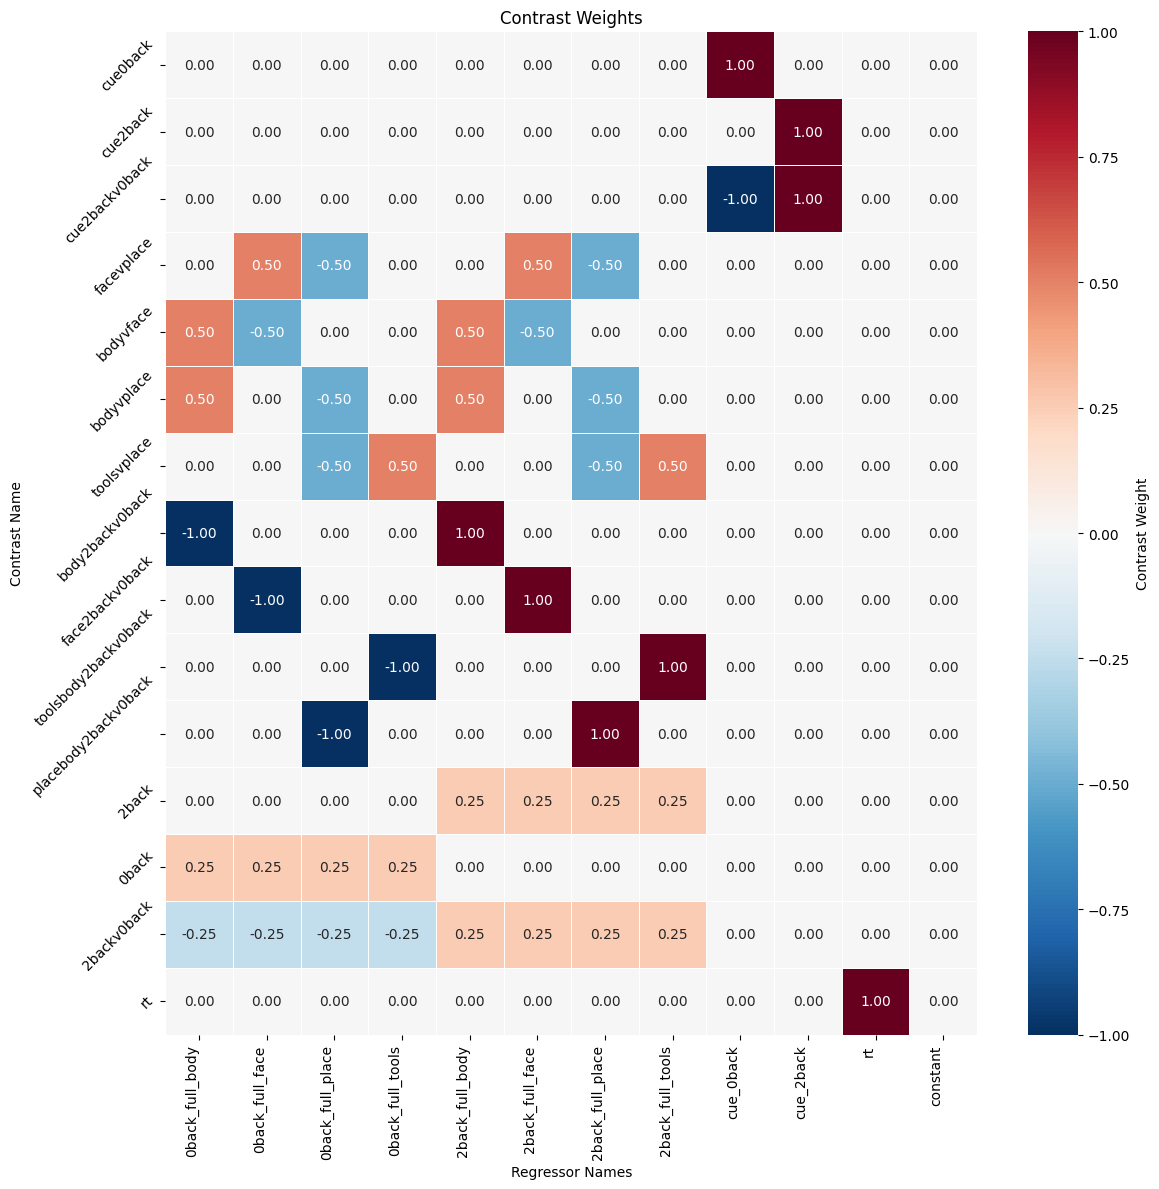

In [45]:
fig, _, _ = visualize_contrastweights(design_matrix=design_matrix, config_contrasts=mod_config['contrasts'], 
                                      var_exclude=mod_config['nuisance_regressors'])
plt.show()

#### First Level GLM

In [ ]:
# bold file
# task name should be upper for WM
bold_fullpath = f"sub-{subj_id}_ses-3T_task-{task.upper()}_dir-*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
bold_path = next(Path(test_fmriprep_path).glob(bold_fullpath), None)

# first lvl model & compute contrasts
firstglm_res = run_firstlvl_computecons(subjid=subj_id, boldpath=bold_path, designmatrix=design_matrix, sesid=ses, taskname=task, 
                                        runnum=run, boldtr=float(config['boldtr']), brain_mask=brain_mni_mask, 
                                        contrastlist=mod_config["contrasts"], firstlvl_out=analysis_out, fwhm=fwhm, 
                                        ar_mod=ar_noisemod, detrend=detrend, highpass=highpass
                                       )

## Group

### Contrast Maps

Directory ensured: /scratch.global/mdemiden/hcp_glms/hcp/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp
Directory ensured: /scratch.global/mdemiden/hcp_glms/alt/grp


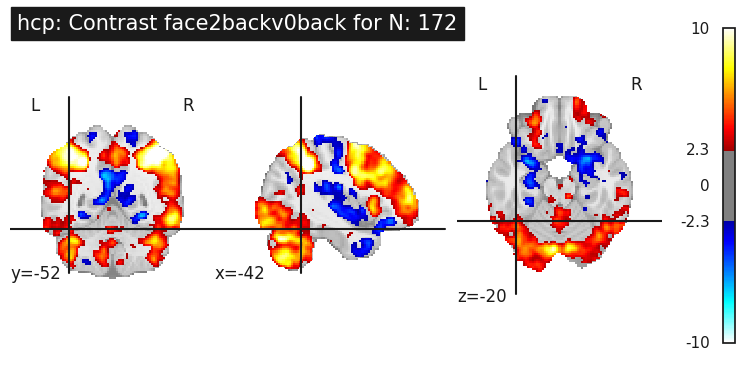

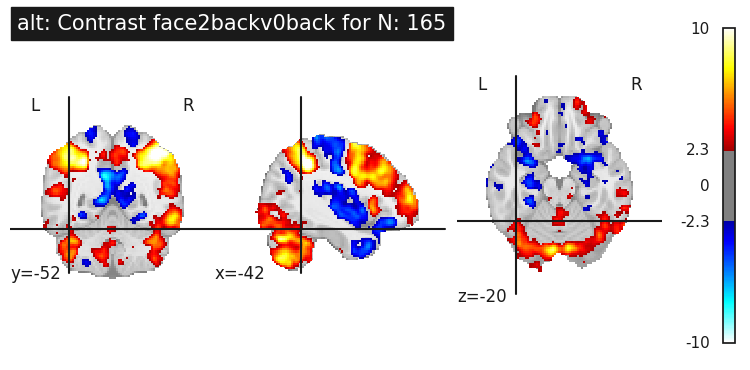

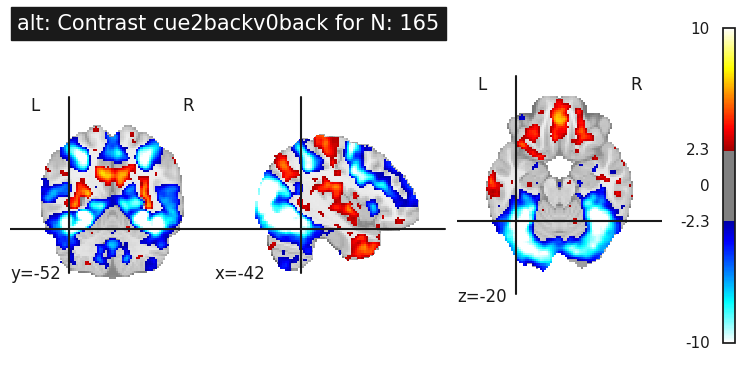

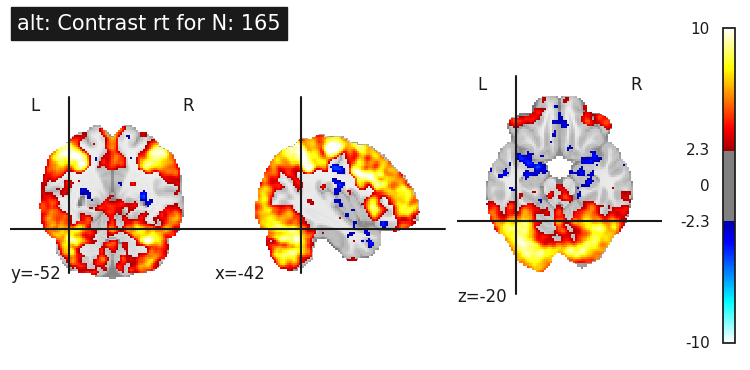

In [83]:
spec = xyz_coords_barch[task]
xyz_cord = spec["coord"]

for mod in ['hcp', 'alt']:
    mod_type = spec[mod]
    grpout = f"{analysis_out}/{mod}/grp"

    for contrastlab in mod_type["con"]:
        statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))
        grpcon_maps = sorted(Path(f'{analysis_out}/{mod}/fixedeff/').rglob(
                f"*_ses-3T_task-{task}_contrast-{contrastlab}_stat-fixeff.nii.gz"))
        if not statimg_path:  # Run only if the group map doesn't exist
            group_onesample(fixedeffect_paths=grpcon_maps, session=ses, task_type=task,
                            contrast_type=contrastlab, group_outdir=grpout, save_zscore=True, save_cohensd=True)
            # Refresh the stat image path after running group map
            statimg_path = sorted(Path(grpout).rglob(f"*ses-3T_task-{task}_contrast-{contrastlab}_stat-cohensd.nii.gz"))

        if statimg_path:  # Only plot if the image exists
            plot_stat_map(statimg_path[0], title=f"{mod}: Contrast {contrastlab} for N: {len(grpcon_maps)}",
                          threshold=2.3, vmax=10, cut_coords=xyz_cord)


### VIF Distributions

Error reading file /scratch.global/mdemiden/hcp_glms/hcp/vifs/sub-558960/all-tasks_vif-estimates.tsv: No columns to parse from file


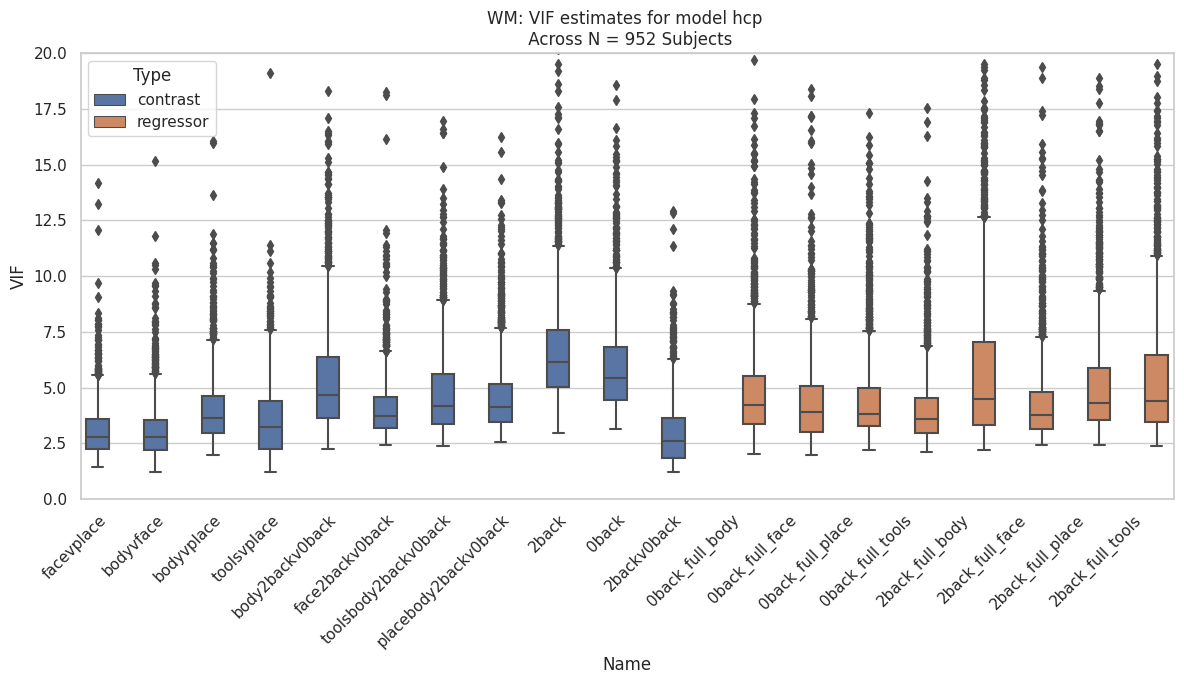

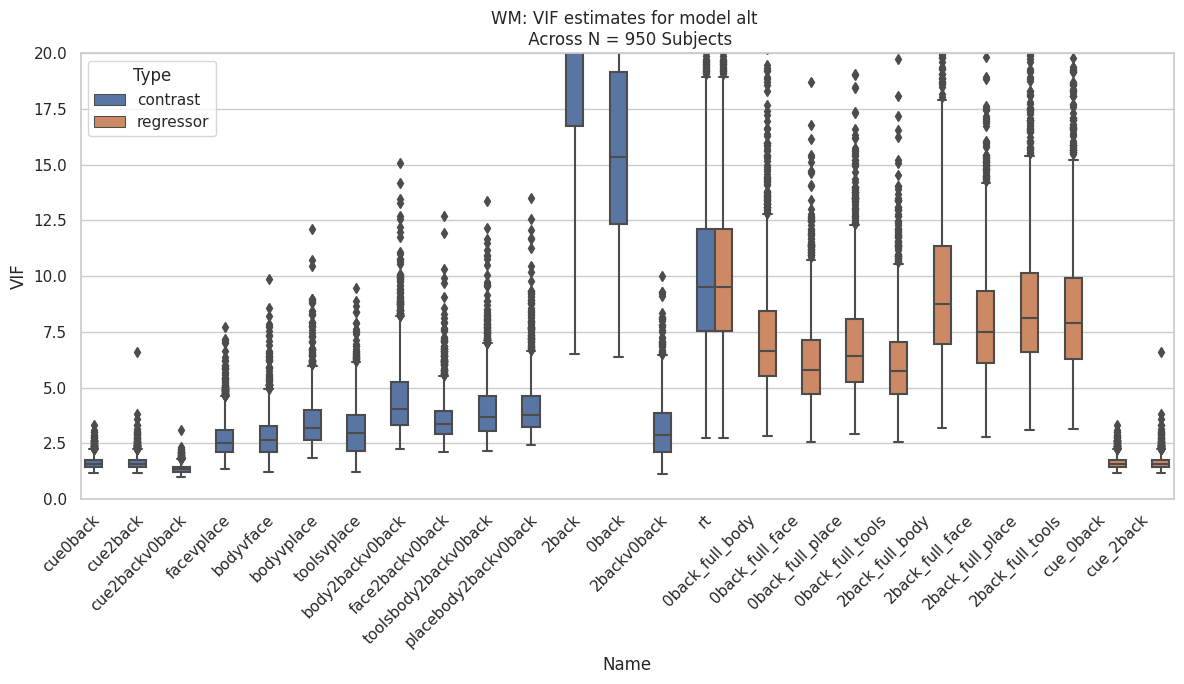

In [12]:
for mod in ['hcp', 'alt']:
    vif_paths = sorted(Path(f'{analysis_out}/{mod}/vifs').rglob('all-tasks_vif-estimates.tsv'))
    all_vif_dfs = []

    for vif_path in vif_paths:
        try:
            vifdf = pd.read_csv(vif_path, sep="\t")
            if not vifdf.empty:
                all_vif_dfs.append(vifdf)
            else:
                print(f"Skipped empty file: {vif_path}")
        except Exception as e:
            print(f"Error reading file {vif_path}: {e}")
    
    if not all_vif_dfs:
        print(f"No valid VIF data found for model {mod}. Skipping plot.")
        continue

    combined_vif_df = pd.concat(all_vif_dfs, ignore_index=True)
    
    # subset by task & generate boxplot
    filtered_vif_df = combined_vif_df[combined_vif_df["task"] == task]
    if filtered_vif_df.empty:
        print(f"No data found for task '{task}' in model {mod}. Skipping plot.")
        continue

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    ax = sns.boxplot(data=filtered_vif_df, x="name", y="value", hue="type", dodge=True)
    plt.xlabel("Name")
    plt.ylabel("VIF")
    plt.title(f"{task.upper()}: VIF estimates for model {mod} \n Across N = {len(all_vif_dfs)} Subjects")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 20)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

## Model Fit (R-squared) Distribution

In [ ]:
hcpmaps = list(Path(f"{analysis_out}/hcp").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
altmaps = list(Path(f"{analysis_out}/alt").rglob(f"*_task-{task}*_stat-rsquared.nii.gz"))
hcp_mean, hcp_sd = calc_niftis_meanstd(hcpmaps)
alt_mean, alt_sd = calc_niftis_meanstd(altmaps)

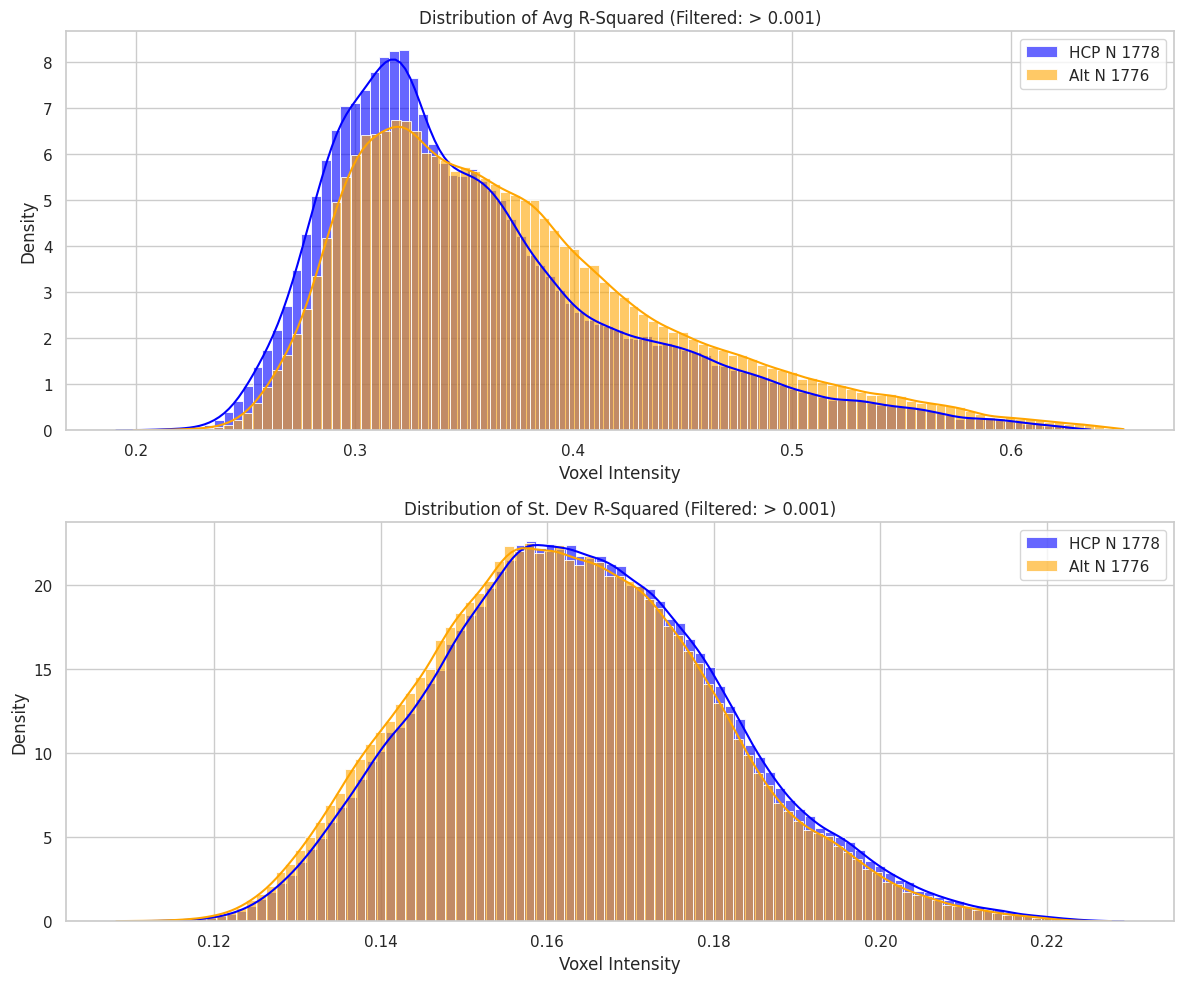

In [14]:
data_pairs = [
    ("Avg R-Squared", hcp_mean, alt_mean),
    ("St. Dev R-Squared", hcp_sd, alt_sd)
]

plt.figure(figsize=(12, 10))  # Increase height for 2 rows

for i, (title, hcp_img, alt_img) in enumerate(data_pairs, start=1):
    hcp_vals = hcp_img.get_fdata().ravel()
    alt_vals = alt_img.get_fdata().ravel()
    
    # Filter values > 0.001
    hcp_vals = hcp_vals[hcp_vals > 0.001]
    alt_vals = alt_vals[alt_vals > 0.001]

    plt.subplot(2, 1, i)
    sns.histplot(hcp_vals, color='blue', label=f'HCP N {len(hcpmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    sns.histplot(alt_vals, color='orange', label=f'Alt N {len(altmaps)}', kde=True, stat='density', bins=100, alpha=0.6)
    
    plt.title(f"Distribution of {title} (Filtered: > 0.001)")
    plt.xlabel("Voxel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Basic Reports of Runs

In [59]:
slurm_out = pd.read_csv(f'{report_out}/ses-3T_modelsran.csv', sep=',')
# Replace NaN with 0 in the status columns
status_cols = ['FirstLvlStatus', 'FixedEffStatus', 'TimeseriesExtracted']
slurm_out[status_cols] = slurm_out[status_cols].fillna(0).astype(int)

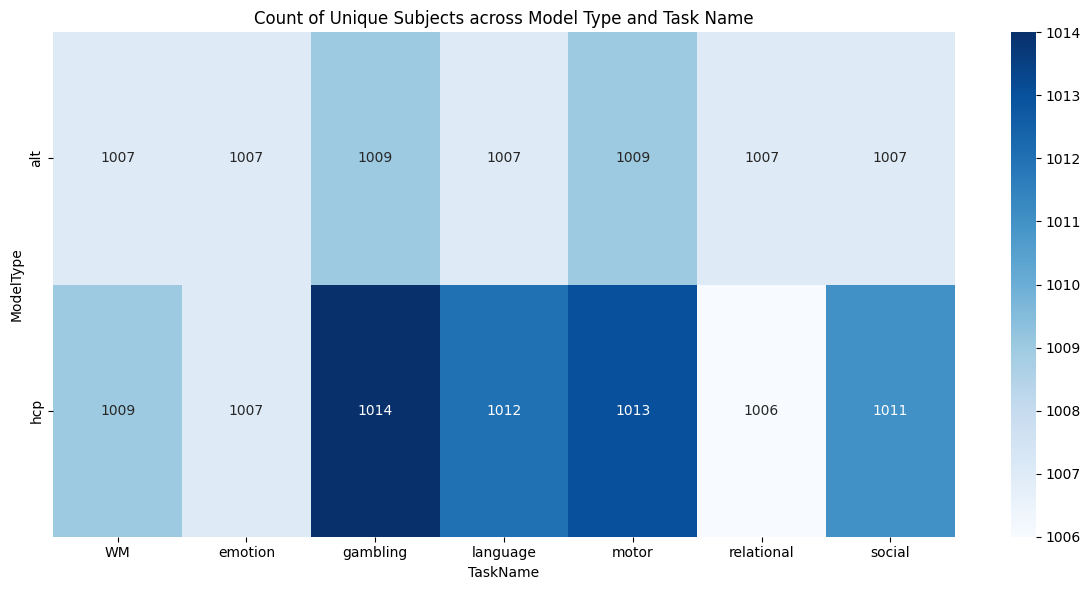

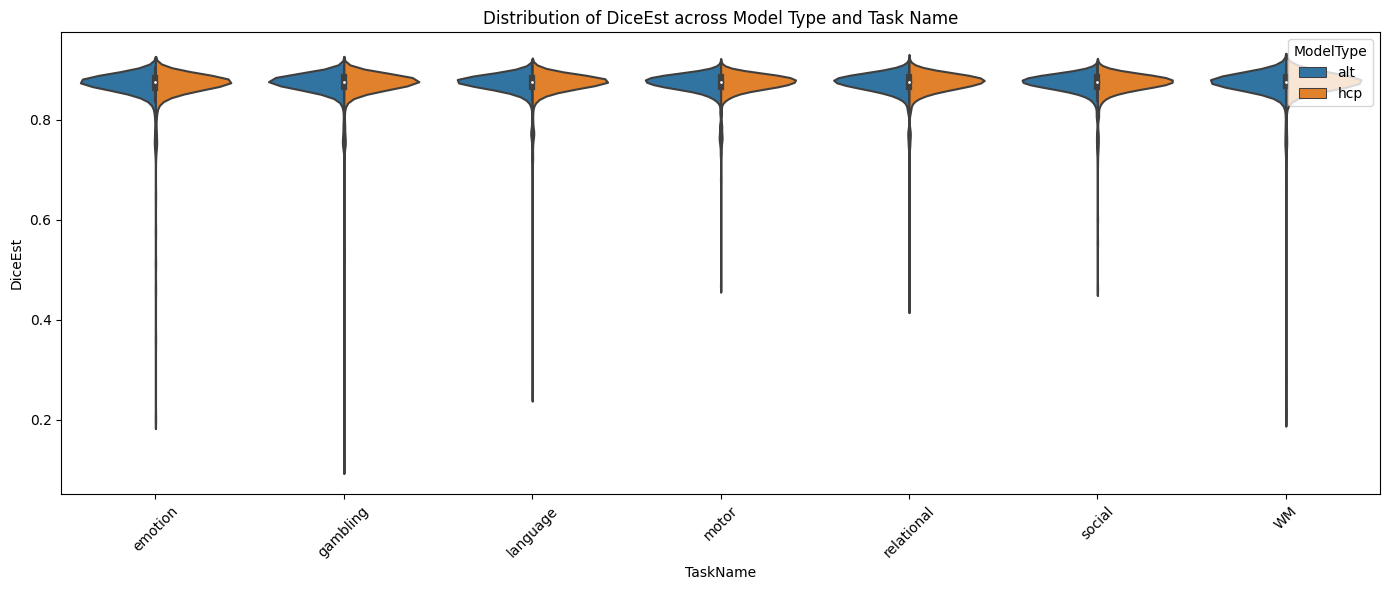

In [62]:
slurm_out['FirstLvlStatus'] = slurm_out['FirstLvlStatus'].astype(int)
slurm_out['FixedEffStatus'] = slurm_out['FixedEffStatus'].astype(int)
slurm_out['TimeseriesExtracted'] = slurm_out['TimeseriesExtracted'].astype(int)

# Plot 1: N Subjects across ModelType and TaskName
plt.figure(figsize=(12, 6))
subject_counts = slurm_out.groupby(['ModelType', 'TaskName'])['Subject'].nunique().reset_index()
subject_counts_pivot = subject_counts.pivot('ModelType', 'TaskName', 'Subject')
sns.heatmap(subject_counts_pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Count of Unique Subjects across Model Type and Task Name')
plt.ylabel('ModelType')
plt.xlabel('TaskName')
plt.tight_layout()
plt.show()

# Plot 2: dist of DiceEst across ModelType and TaskName
plt.figure(figsize=(14, 6))
sns.violinplot(data=slurm_out, x='TaskName', y='DiceEst', hue='ModelType', split=True)
plt.title('Distribution of DiceEst across Model Type and Task Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



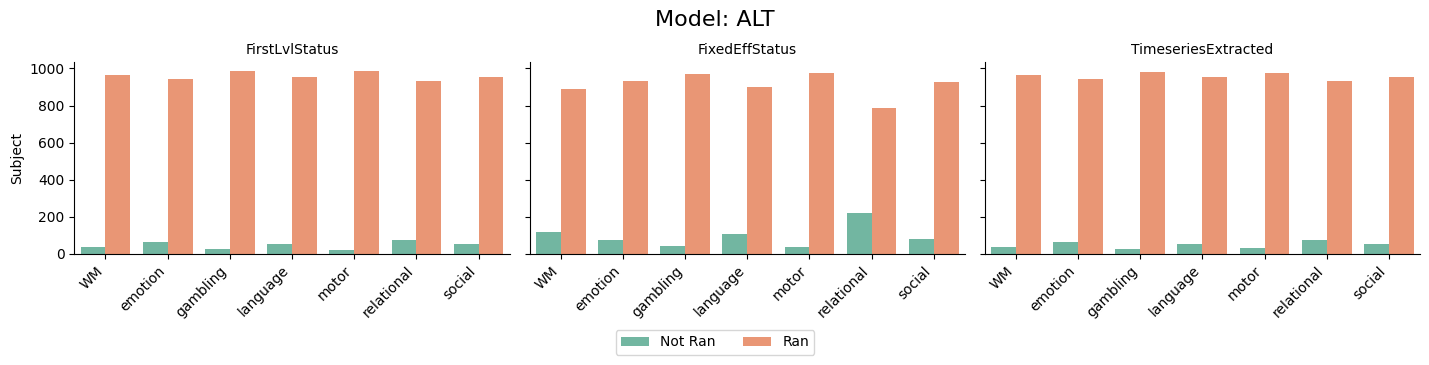

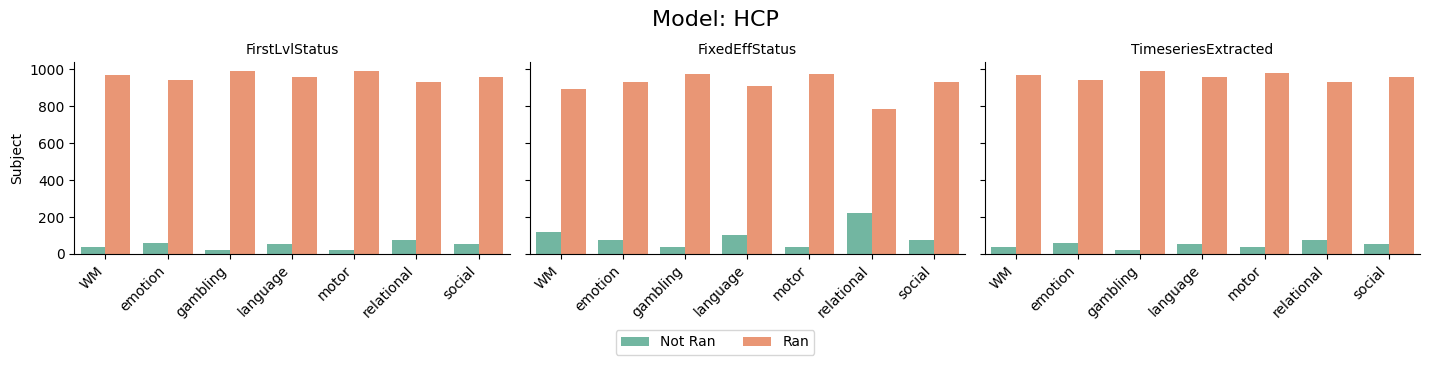

In [66]:
for model_type in slurm_out['ModelType'].unique():
    # Filter data for the current ModelType
    model_data = slurm_out[slurm_out['ModelType'] == model_type]
    
    # Melt the data
    melted = model_data.melt(
        id_vars=['ModelType', 'TaskName', 'Subject'],
        value_vars=['FirstLvlStatus', 'FixedEffStatus', 'TimeseriesExtracted'],
        var_name='StatusType',
        value_name='StatusValue'
    )
    
    # Map values to status labels
    melted['Status'] = melted['StatusValue'].map({1: 'Ran', 0: 'Not Ran'})
    
    # Group by columns
    status_counts = (
        melted.groupby(['TaskName', 'StatusType', 'Status'])
        ['Subject'].nunique()
        .reset_index()
    )
    
    # Plot using FacetGrid
    g = sns.catplot(
        data=status_counts,
        x='TaskName',
        y='Subject',
        hue='Status',
        col='StatusType',
        kind='bar',
        palette='Set2',
        height=4,
        aspect=1.2,
        dodge=True,
        legend=False 
    )
    
    # Set titles and format
    g.fig.suptitle(f'Model: {model_type.upper()}', fontsize=16)
    g.set_titles('{col_name}')
    g.set_xlabels('')
    g.set_xticklabels(rotation=45, ha='right')
    g.fig.subplots_adjust(top=0.85, bottom=0.37)
    
    # Add bottom legend
    handles, labels = g.axes[0][0].get_legend_handles_labels()
    g.fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, 0.1))

    # save fig
    plt.savefig(f"./imgs/modelsran_counts-uniqsubject_model-{model_type}.png", dpi=300, bbox_inches='tight')

    plt.show()

In [6]:
s3_files = pd.read_csv(f'{report_out}/s3_task-glm_file-counts.csv', sep=',')
s3_files.columns

Index(['Type', 'Model', 'Subject', 'Task', 'Run', 'FileCount'], dtype='object')

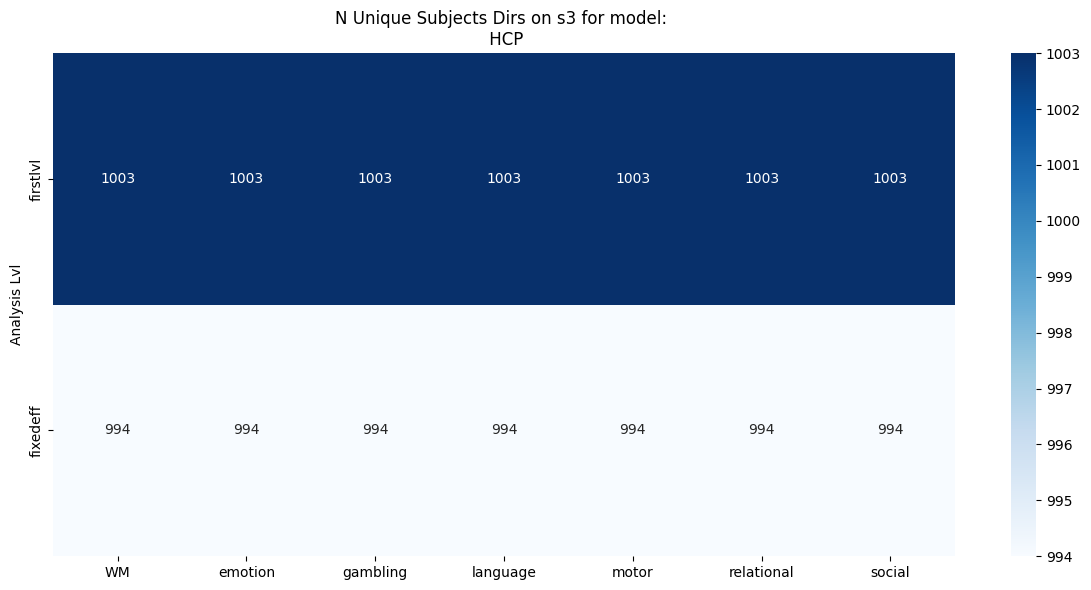

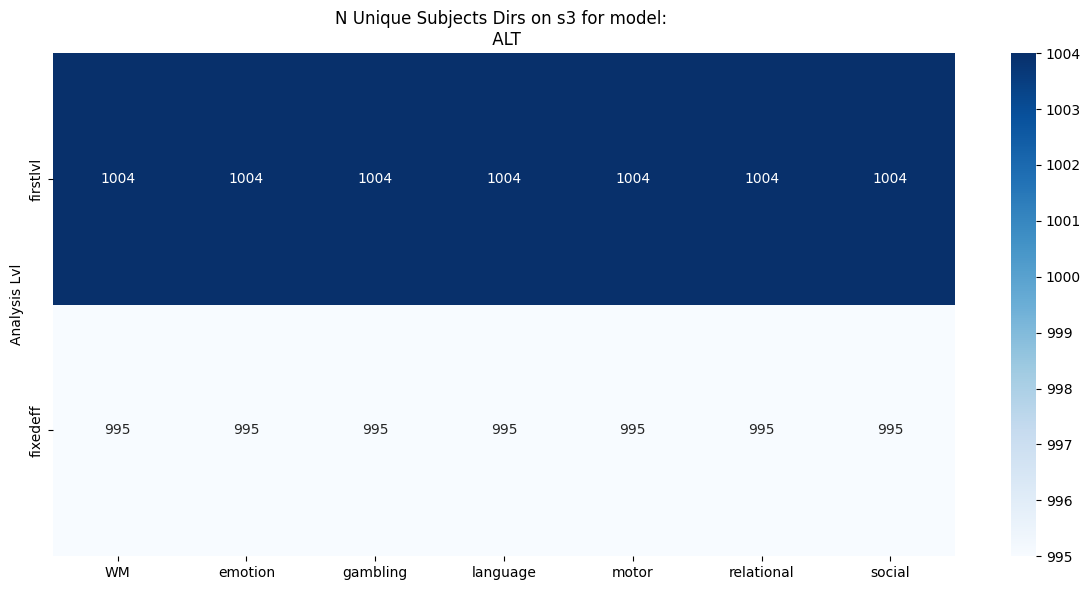

In [70]:
for mod in ['hcp', 'alt']:
    # Filter for the current Type
    filtered = s3_files[s3_files['Type'] == mod]

    # Group and pivot
    subject_counts = filtered.groupby(['Model', 'Task'])['Subject'].nunique().reset_index()
    subject_counts_pivot = subject_counts.pivot(index='Model', columns='Task', values='Subject')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(subject_counts_pivot, annot=True, fmt='d', cmap='Blues')
    plt.title(f'N Unique Subjects Dirs on s3 for model: \n {mod.upper()}')
    plt.ylabel('Analysis Lvl')
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(f"./imgs/s3output_counts-uniqsubject_model-{mod}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [12]:
model = 'firstlvl'
tasks = ['WM','gambling','motor','language','social','relational','emotion']

for task in tasks:
    hcp_subjects = set(
        s3_files[(s3_files['Type'] == 'hcp') &
                 (s3_files['Model'] == model) &
                 (s3_files['Task'] == task)]['Subject']
    )
    
    alt_subjects = set(
        s3_files[(s3_files['Type'] == 'alt') &
                 (s3_files['Model'] == model) &
                 (s3_files['Task'] == task)]['Subject']
    )
    missing_in_hcp = alt_subjects - hcp_subjects
    extra_in_hcp = hcp_subjects - alt_subjects
    print(f"###### {task} ######")
    print(f"Subjects in ALT but not in HCP ({len(missing_in_hcp)}):", missing_in_hcp)
    print(f"Subjects in HCP but not in ALT ({len(extra_in_hcp)}):", extra_in_hcp)

###### WM ######
Subjects in ALT but not in HCP (7): {'sub-146331', 'sub-111716', 'sub-117122', 'sub-207426', 'sub-231928', 'sub-210415', 'sub-117021'}
Subjects in HCP but not in ALT (6): {'sub-212318', 'sub-143224', 'sub-517239', 'sub-137128', 'sub-379657', 'sub-108323'}
###### gambling ######
Subjects in ALT but not in HCP (7): {'sub-146331', 'sub-111716', 'sub-117122', 'sub-207426', 'sub-231928', 'sub-210415', 'sub-117021'}
Subjects in HCP but not in ALT (6): {'sub-212318', 'sub-143224', 'sub-517239', 'sub-137128', 'sub-379657', 'sub-108323'}
###### motor ######
Subjects in ALT but not in HCP (7): {'sub-146331', 'sub-111716', 'sub-117122', 'sub-207426', 'sub-231928', 'sub-210415', 'sub-117021'}
Subjects in HCP but not in ALT (6): {'sub-212318', 'sub-143224', 'sub-517239', 'sub-137128', 'sub-379657', 'sub-108323'}
###### language ######
Subjects in ALT but not in HCP (7): {'sub-146331', 'sub-111716', 'sub-117122', 'sub-207426', 'sub-231928', 'sub-210415', 'sub-117021'}
Subjects in HC

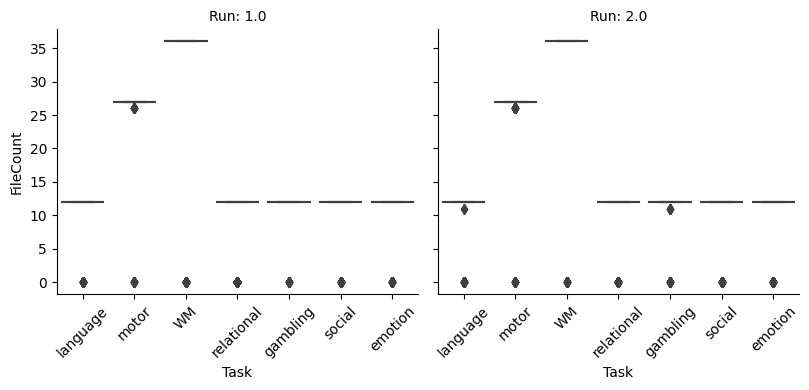

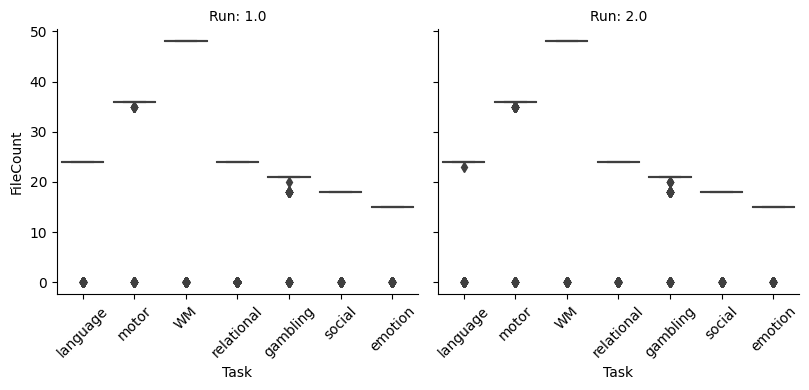

In [69]:
for mod in ['hcp', 'alt']:
    # Filter for the current Type
    filtered = s3_files[s3_files['Type'] == mod]

    g = sns.FacetGrid(filtered, col='Run', col_wrap=3, height=4, sharey=True)
    g.map_dataframe(sns.boxplot, x='Task', y='FileCount')
    g.set_titles(col_template="Run: {col_name}")
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', rotation=45)
    plt.savefig(f"./imgs/s3filecounts_counts-uniqsubject_model-{mod}.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    